In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import quad
import cmath
from scipy.optimize import bisect, brentq
from scipy.stats import norm
from scipy.linalg import expm

In [2]:
# We'll take t = T/2 everywhere, hence, there's no need to considère t for the rest

# CASE 1 : Shaun 2 (a, b, c, rho, V_0, T2)
case_1  = 17.25*0.018,  -17.25, 2.95,-0.68,  0.006, 1.

#CASE 2 : Shaun 1
case_2 = 2.15*0.057,  -2.15, 0.86,-0.70, 0.023, 1.
    
#CASE 3 : ANDERSEN 1  (a, b, c, rho, V_0, T2)
case_3 = 0.5*0.04,  -0.5, 1.,-0.9, 0.04, 10.

case = np.zeros([3, 6])
case[0,:], case[1,:], case[2,:] = case_1, case_2, case_3 

print(case)

[[ 3.1050e-01 -1.7250e+01  2.9500e+00 -6.8000e-01  6.0000e-03  1.0000e+00]
 [ 1.2255e-01 -2.1500e+00  8.6000e-01 -7.0000e-01  2.3000e-02  1.0000e+00]
 [ 2.0000e-02 -5.0000e-01  1.0000e+00 -9.0000e-01  4.0000e-02  1.0000e+01]]


In [3]:
# Algorithme de Micheal et al pour simuler une gaussienne inverse

def inverse_gaussian_sample_vectorized(mu, lambda_, x_n, x_u):
    """
    Vectorized version of the inverse Gaussian sampling function.
    """
    y = x_n ** 2  # std normal squared
    x = mu + (mu ** 2 * y) / (2 * lambda_) - (mu / (2 * lambda_)) * np.sqrt(4 * mu * lambda_ * y + mu ** 2 * y ** 2)
    condition = x_u <= mu / (mu + x)
    samples = np.where(condition, x, (mu ** 2) / x)
    return samples    

# Ivy Method

In [4]:
# Simulate n_paths sample paths of U, V, Z, logS with n time steps
def simulate_paths(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2)!=0:
        print("le nombre de pas doit être pair")
        return
    #discretize time
    dt = T/n_steps
    t_vec = np.linspace(0, T, n_steps + 1)

    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize V,U,Z,logS
    V, U, Z, logS = np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths)), np.zeros((n_steps + 1, n_paths))
    V[0,:] = V_0
    
    for m in range(n_paths):
        for i in range(n_steps):
            alpha_i = V[i, m] * exp_bdt_int + a_int 
            mu = alpha_i 
            lambda_ = (alpha_i / sigma)**2
    
            dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,m], x_uniform[i,m])
            U[i + 1, m] = U[i, m] + dU_i
            Z_i   = (1. / sigma) * (dU_i - alpha_i)
            Z[i + 1, m] = Z[i, m] + Z_i
            V[i + 1, m] = (exp_bdt / exp_bdt_int) * (dU_i + (a / b) * dt) - (a / b)
            logS[i + 1, m] =  logS[i, m] - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,m]
    
    return (t_vec, V, U, Z, S_0*np.exp(logS))

In [5]:
# Simulate n_paths sample paths of U, V, Z, logS with n time steps
def simulate_paths_from_idx(a, b, c, rho, V_idx, idx, T, n_steps, n_paths, S_idx, U_idx=0, Z_idx = 0):
    """ cette fonction simule ivi à partir d'un index quelconque"""
    #discretize time
    dt = T/n_steps
    t_vec = np.linspace(0, T, n_steps + 1)


    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize V,U,Z,logS
    V, U, Z, logS = np.zeros((n_steps - idx + 1, n_paths)), np.zeros((n_steps - idx + 1, n_paths)), np.zeros((n_steps - idx + 1, n_paths)), np.zeros((n_steps - idx + 1, n_paths))
    V[0,:] = V_idx
    U[0, :] = U_idx
    Z[0, :] = Z_idx
    x_norm = np.random.randn(n_steps - idx, n_paths)
    x_uniform = np.random.rand(n_steps - idx, n_paths)
    x_norm2 = np.random.randn(n_steps - idx, n_paths)
    
    for m in range(n_paths):
        for i in range(n_steps - idx):
            alpha_i = V[i, m] * exp_bdt_int + a_int 
            mu = alpha_i 
            lambda_ = (alpha_i / sigma)**2
    
            dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,m], x_uniform[i,m])
            U[i + 1, m] = U[i, m] + dU_i
            Z_i   = (1. / sigma) * (dU_i - alpha_i)
            Z[i + 1, m] = Z[i, m] + Z_i
            V[i + 1, m] = (exp_bdt / exp_bdt_int) * (dU_i + (a / b) * dt) - (a / b)
            logS[i + 1, m] =  logS[i, m] - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,m]
            
    return (t_vec, V, U, Z, S_idx*np.exp(logS))

In [6]:
def simulate_price_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2)!=0:
        print("le nombre de pas doit être pair")
        return
    
    #discretize time
    dt = T / n_steps
    
    #pre-compute certain quantities indepenendt of i and m
    exp_bdt = np.exp(b * dt)
    exp_bdt_int = (exp_bdt - 1 ) / b
    a_int = (a / b) * ( exp_bdt_int - dt )
    sigma = c * exp_bdt_int
    rho_bar = np.sqrt(1 - rho * rho)

    #Initialize logS
    logS = np.zeros(n_paths)
    #Initialize log(St)
    logSt = np.zeros(n_paths)
    V = V_0*np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for i in range(n_steps):
        alpha_i = V * exp_bdt_int + a_int 
        mu = alpha_i 
        lambda_ = (alpha_i / sigma)**2
        
        dU_i = inverse_gaussian_sample_vectorized(mu, lambda_, x_norm[i,:n_paths], x_uniform[i,:n_paths])
        Z_i   = (1. / sigma) * (dU_i - alpha_i)
        V = (exp_bdt / exp_bdt_int  ) * (dU_i + a * dt / b ) - a / b  #V = V + a*dt + b*dU_i + c*Z_i
        
        logS = logS - 0.5 * dU_i + rho * Z_i + rho_bar * np.sqrt(dU_i) * x_norm2[i,:n_paths] 
        if (i == n_steps/2 - 1):
            logSt = logS.copy()          
        U = U + dU_i
    
    return (S_0*np.exp(logSt), S_0*np.exp(logS), V, U)

# QE_method

In [7]:
def simulate_price_QE_vectorized(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if (n_steps % 2 != 0):
        print("le nombre de pas doit être pair")
        return
    
    #discretize time
    dt = T / n_steps
    
    #pre-compute certain quantities indepenendt of i and m
    E0 = np.exp(b * dt)
    E1 = 1 - E0
    E2 = E1 ** 2
    E3 = E0 * E1
    E4 = - (c ** 2) / b
    theta = - a / b
    rho_bar = np.sqrt( 1 - rho * rho)
    
    #Initialize logS
    logS = np.zeros(n_paths)
    #logSt
    logSt = np.zeros(n_paths)
    V = V_0*np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for j in range(n_steps):
        Zj = - V
        dU1 = V*dt/2
        m = theta + (V - theta) * E0
        s2 = E4 * (V * E3 + theta * E2 / 2)
        psi = s2 / (m ** 2)

        mask_1 = (psi <= 1.5) #hyperparameter set to 3/2 
        psi1 = 1 / psi[mask_1]
        b2 = 2 * psi1 - 1 + 2 * psi1 * np.sqrt(1 - psi[mask_1] / 2)
        aa = m[mask_1] / (1 + b2)
        bb = np.sqrt(b2)
        V[mask_1] = aa * (bb + x_norm[j,:n_paths][mask_1]) ** 2

        p = (psi - 1) / (psi + 1)
        beta = (1 - p) / m

        mask_2 = (x_uniform[j,:n_paths] <= p)
        mask_3 = mask_2 & ~mask_1
        mask_4 = ~mask_2 & ~mask_1
        V[mask_3] = 0
        V[mask_4] = (1 / beta[mask_4]) * np.log((1 - p[mask_4]) / (1 - x_uniform[j,:n_paths][mask_4]))
        
        dU2 = V*dt/2
        dU_j = dU1 + dU2
        U = U +  dU_j
        Zj = (1 / c )*( V + Zj - a*dt - b * dU_j)     
        
        logS = logS - 0.5 * dU_j + rho *Zj  + rho_bar * np.sqrt(dU_j) * x_norm2[j,:n_paths] 
        if j == n_steps/2 - 1:
            logSt = logS.copy()          
        
    
    return (S_0*np.exp(logSt), S_0*np.exp(logS), V, U)


In [8]:
def simulate_QE_paths(a, b, c, rho, V_0, T, n_steps, n_paths, S_0=1.):
    
    if n_steps % 2 != 0:
        print("le nombre de pas doit être pair")
        return None
    
    # discretize time
    dt = T / n_steps
    
    # pre-compute certain quantities independent of i and m
    E0 = np.exp(b * dt)
    E1 = 1 - E0
    E2 = E1 ** 2
    E3 = E0 * E1
    E4 = -(c ** 2) / b
    theta = -a / b
    rho_bar = np.sqrt(1 - rho * rho)
    
    # Initialize arrays for full paths
    # Shape: (n_steps+1, n_paths) - +1 to include initial value
    logS_paths = np.zeros((n_steps + 1, n_paths))
    V_paths = np.zeros((n_steps + 1, n_paths))
    U_paths = np.zeros((n_steps + 1, n_paths))
    
    # Set initial values
    logS_paths[0, :] = np.log(S_0)
    V_paths[0, :] = V_0
    U_paths[0, :] = 0.0
    
    # Generate all random numbers at once for efficiency
    #x_norm = np.random.randn(n_steps, n_paths)
    #x_norm2 = np.random.randn(n_steps, n_paths)
    #x_uniform = np.random.rand(n_steps, n_paths)
    
    # Current values (will be updated each step)
    logS = np.log(S_0) * np.ones(n_paths)
    V = V_0 * np.ones(n_paths)
    U = np.zeros(n_paths)
    
    for j in range(n_steps):
        Zj = -V
        
        # dU1 = V * dt / 2
        dU1 = V * dt / 2
        
        # Compute m, s2, psi
        m = theta + (V - theta) * E0
        s2 = E4 * (V * E3 + theta * E2 / 2)
        psi = s2 / (m ** 2)
        
        # Mask for psi <= 1.5
        mask_1 = (psi <= 1.5)
        
        # Handle case 1: psi <= 1.5
        if np.any(mask_1):
            psi1 = 1 / psi[mask_1]
            b2 = 2 * psi1 - 1 + 2 * psi1 * np.sqrt(1 - psi[mask_1] / 2)
            aa = m[mask_1] / (1 + b2)
            bb = np.sqrt(b2)
            V[mask_1] = aa * (bb + x_norm[j, :n_paths][mask_1]) ** 2
        
        # Handle case 2: psi > 1.5
        if np.any(~mask_1):
            p = (psi[~mask_1] - 1) / (psi[~mask_1] + 1)
            beta = (1 - p) / m[~mask_1]
            
            mask_2 = (x_uniform[j, :n_paths][~mask_1] <= p)
            mask_3 = mask_2  # V = 0
            mask_4 = ~mask_2  # V = exponential
            
            # Apply masks
            if np.any(mask_3):
                idx_mask_3 = np.where(~mask_1)[0][mask_3]
                V[idx_mask_3] = 0
            
            if np.any(mask_4):
                idx_mask_4 = np.where(~mask_1)[0][mask_4]
                V[idx_mask_4] = (1 / beta[mask_4]) * np.log(
                    (1 - p[mask_4]) / (1 - x_uniform[j, :n_paths][~mask_1][mask_4])
                )
        
        # dU2 = V * dt / 2 (with updated V)
        dU2 = V * dt / 2
        dU_j = dU1 + dU2
        U = U + dU_j
        
        # Update Zj
        Zj = (1 / c) * (V + Zj - a * dt - b * dU_j)
        
        # Update logS
        logS = logS - 0.5 * dU_j + rho * Zj + rho_bar * np.sqrt(dU_j) * x_norm2[j, :n_paths]
        
        # Store values for this time step
        logS_paths[j + 1, :] = logS.copy()
        V_paths[j + 1, :] = V.copy()
        U_paths[j + 1, :] = U.copy()
    
    # Convert log prices to actual prices
    S_paths = S_0 * np.exp(logS_paths)
    
    return S_paths,  V_paths, U_paths 

In [9]:
def simulate_QE_paths_from_idx(a, b, c, rho, V_idx, T, idx, n_steps, n_paths, S_idx, U_idx, seed=None):
    """
    Simule des trajectoires QE à partir d'un indice idx donné.
    
    Paramètres:
    -----------
    a, b, c, rho : paramètres du modèle
    V_idx, S_idx, U_idx : valeurs initiales à l'indice idx
    T : maturité totale
    idx : indice de départ (0 ≤ idx < n_steps)
    n_steps : nombre total de pas
    n_paths : nombre de trajectoires
    seed : graine aléatoire optionnelle
    
    Retourne:
    ---------
    S_paths, V_paths, U_paths : arrays (n_steps-idx+1, n_paths)
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Vérification
    if idx >= n_steps:
        raise ValueError(f"idx={idx} doit être < n_steps={n_steps}")
    
    # Discrétisation temporelle
    dt = T / n_steps
    
    # Pré-calculs
    E0 = np.exp(b * dt)
    E1 = 1 - E0
    E2 = E1 ** 2
    E3 = E0 * E1
    E4 = -(c ** 2) / b
    theta = -a / b
    rho_bar = np.sqrt(1 - rho * rho)
    
    # Nombre de pas restants
    n_remaining = n_steps - idx
    
    # Initialiser les tableaux
    logS_paths = np.zeros((n_remaining + 1, n_paths))
    V_paths = np.zeros((n_remaining + 1, n_paths))
    U_paths = np.zeros((n_remaining + 1, n_paths))
    
    # Valeurs initiales (répliquées sur toutes les trajectoires)
    logS_paths[0, :] = np.log(S_idx)
    V_paths[0, :] = V_idx
    U_paths[0, :] = U_idx
    
    # Générer les nombres aléatoires
    x_norm = np.random.randn(n_remaining, n_paths)
    x_norm2 = np.random.randn(n_remaining, n_paths)
    x_uniform = np.random.rand(n_remaining, n_paths)
    
    # Variables courantes
    logS = np.log(S_idx) * np.ones(n_paths)
    V = V_idx * np.ones(n_paths)
    U = U_idx * np.ones(n_paths)  # CORRECTION ICI
    
    # Boucle sur les pas restants
    for j in range(n_remaining):
        Zj = -V
        
        # dU1 = V * dt / 2
        dU1 = V * dt / 2
        
        # Calculer m, s2, psi
        m = theta + (V - theta) * E0
        s2 = E4 * (V * E3 + theta * E2 / 2)
        psi = s2 / (m ** 2)
        
        # Masque pour psi <= 1.5
        mask_small = (psi <= 1.5)
        
        if np.any(mask_small):
            # Cas 1: psi <= 1.5
            psi_small = psi[mask_small]
            psi1 = 1 / psi_small
            b2 = 2 * psi1 - 1 + 2 * psi1 * np.sqrt(1 - psi_small / 2)
            aa = m[mask_small] / (1 + b2)
            bb = np.sqrt(b2)
            
            # Mettre à jour V pour les trajectoires avec petit psi
            V[mask_small] = aa * (bb + x_norm[j, mask_small]) ** 2
        
        if np.any(~mask_small):
            # Cas 2: psi > 1.5
            psi_large = psi[~mask_small]
            m_large = m[~mask_small]
            
            p = (psi_large - 1) / (psi_large + 1)
            beta = (1 - p) / m_large
            
            # Masques pour ce sous-ensemble
            mask_uniform = x_uniform[j, ~mask_small] <= p
            
            # Trajectoires avec V = 0
            zero_mask = mask_uniform
            if np.any(zero_mask):
                # Trouver les indices dans le tableau complet
                large_indices = np.where(~mask_small)[0]
                zero_indices = large_indices[zero_mask]
                V[zero_indices] = 0.0
            
            # Trajectoires avec V exponentielle
            exp_mask = ~mask_uniform
            if np.any(exp_mask):
                large_indices = np.where(~mask_small)[0]
                exp_indices = large_indices[exp_mask]
                
                # Extraire les valeurs correspondantes
                beta_exp = beta[exp_mask]
                p_exp = p[exp_mask]
                u_exp = x_uniform[j, ~mask_small][exp_mask]
                
                # Calculer V exponentielle
                V[exp_indices] = (1 / beta_exp) * np.log((1 - p_exp) / (1 - u_exp))
        
        # Mettre à jour U
        dU2 = V * dt / 2
        dU_j = dU1 + dU2
        U = U + dU_j
        
        # Mettre à jour Zj
        Zj = (1 / c) * (V + Zj - a * dt - b * dU_j)
        
        # Mettre à jour logS
        logS = logS - 0.5 * dU_j + rho * Zj + rho_bar * np.sqrt(dU_j) * x_norm2[j, :]
        
        # Stocker
        logS_paths[j + 1, :] = logS.copy()
        V_paths[j + 1, :] = V.copy()
        U_paths[j + 1, :] = U.copy()
    
    # Convertir log prix en prix
    S_paths = np.exp(logS_paths)  # Note: S_idx est déjà dans logS
    
    return S_paths, V_paths, U_paths

## Fonction caractéristique:
on travaille ici dans le cas $r=0$
> A. cas $t < T_{1}$
$$
\psi(u, t, T_1, T_2) = \ e^{\phi_{hest}(T_2 - T_1)} \ \bigg(\frac{1} {1 - 2 \ \bar{c}(T_1, t)} \bigg)^{\delta / 2}
e^{\frac{A \bar{c}(T_1,t) \ \bar{\kappa}(T1, t)} {1 - 2 A \bar{c}(T_1,t)}}
$$

avec

$
\bar{c}(T_1, t) = \frac{\gamma^2}{4 \kappa} (1 - e^{- \kappa(T_1 - t)})
$

$
\bar{\kappa}(T_1, t) = \frac{4 \ \kappa \ V_t \ e^{- \kappa(T_1 - t)}}{\gamma^2 \ (1 - e^{- \kappa(T_1 - t)})}
$

$
A = \psi_{hest}(T_2 - T_1)
$
et

$
\delta = \frac{4 \kappa \theta}{\gamma^2}
$

> B. cas $T_{1} \leq t < T_{2}$ : 
$
\psi(u, t, T_1, T_2) = e^{(\phi_{hest}(T_2 - t) \ + \ \psi_{hest}(T_2 - t) \ V_t) + i \ u \ \ln(\frac{S_t}{S_{T_1}})}
$


> ##  Hedging 

>. cas t $\leq T_{1}$
$$
\mathbb{E}(\xi |\mathcal{F}_t) =  
 1- \frac{K}{\pi}
 \int_{0}^{\infty} \Re(e^{-i(u-i/2) \log{K}} \frac{\psi(u-i/2, t, T_1, T_2)}{u^2 + 1/4}) \, du
$$
où $\xi$ est le payoff. $\xi = \max(\frac{S_{T2}}{S_{T1}} - K, 0)$

>. cas $T_{1} \leq t < T_{2}$
$$
\mathbb{E}(\xi |\mathcal{F}_t) =  
 \frac{S_t}{S_{T1}} - \frac{K}{\pi}
 \int_{0}^{\infty} \Re(e^{-i(u-i/2) \log{K}} \frac{\psi(u-i/2, t, T_1, T_2)}{u^2 + 1/4}) \, du
$$

Posons $M_t(u) = \psi(u, t, T_1, T_2)$ et $w(u) = \frac{K}{\pi} \frac{K^{-i \tilde{u}}}{u^2 + 1/4}$ où $\tilde{u} = u - i/2$


>1. Si $t \leq T_1$

$$
dE(\xi |\mathcal{F}_t) = - \int_{0}^{\infty} 
Re(w(u) dM_t(\tilde{u})) \, du
$$
comme $\mathbb{E}(\xi |\mathcal{F}_t)$ est une martingale, elle n'a pas de drift et donc, on peut ne conserver que les termes devant le brownien.
soit $dM_t(\tilde{u})^*$ cette partie.
Alors,

Posons 
$$
C_{deriv} = 
 \frac{ 4 \kappa (e^{- \kappa(T_1 - t)})} {\gamma^2 (1 - e^{- \kappa(T_1 - t)})}
 \frac{A \bar{c}(T_1, t)} {1 - 2 A \bar{c}(T_1, t)}
$$
où $A = \psi_{hest}(T_2 - T_1)$

Alors, 
$$
dM_t(\tilde{u})^* = C_{deriv} M_t(\tilde{u}) \gamma \sqrt(V_t) dW_t^1
$$,

$$
Z_t = - \int_{0}^{\infty}  Re(w(u) C_{deriv} M_t(\tilde{u}) \gamma \sqrt(V_t)) \, du
$$
et $Z_t^{\perp} = 0$.

>2. si $T_1 \leq t < T_2$:

$$
dE(\xi |\mathcal{F}_t) = \frac{dS_t}{S_{T_1}} - \int_{0}^{\infty} 
Re(w(u) dM_t(\tilde{u})) \, du
$$
comme $\mathbb{E}(\xi |\mathcal{F}_t)$ est une martingale, elle n'a pas de drift et donc, on peut ne conserver que les termes devant le brownien.
soit $dM_t(\tilde{u})^*$ cette partie.
Alors,


$$
dM_t(\tilde{u})^* = 
 \psi_{hest}(T_2 - t) \ M_t(\tilde{u}) \ \gamma \ \sqrt{V_t} \ dW_t^1
 +
 i \ \tilde{u} \ M_t(\tilde{u}) \ \sqrt{V_t} \ (\rho dW_t^{1} + \sqrt{1 - \rho^2} dW_t^2)
$$ 

$$
= M_t(\tilde{u}) \ \sqrt{V_t} \ (\psi_{hest}(T2 - t) \ \gamma + i \ \tilde{u} \ \rho ) \ dW_t^1
+ i \ \tilde{u} \ \sqrt{V_t} \ M_t(\tilde{u}) \sqrt{1 - \rho ^ 2} \ dW_t^2
$$
donc

$$
Z_t = \frac{\rho S_t \sqrt{V_t}}{S_{T_1}} - \int_{0}^{\infty} \Re(w(u) M_t(\tilde{u}) \ \sqrt{V_t} \ (\psi_{hest}(T_2 - t) \ \gamma + i \ \tilde{u} \ \rho )) \, du
$$
et 
$$
Z_t^{\perp} = \frac{\sqrt{1 - \rho^2} S_t \sqrt{V_t}}{S_{T_1}} - \int_{0}^{\infty} \ \Re(w(u) \ i \ \tilde{u} \ \sqrt{V_t} \ M_t(\tilde{u}) \sqrt{1 - \rho ^ 2}) \ \, du
$$

D'où

$$
X_t = \ X_0^\star \ + \ \int_{0}^{t} \ \rho Z_s \ + \ \sqrt{1 - \rho^2} \ Z_s^{\perp} \, dB_s
$$

avec 
$$
X_0^\star = \mathbb{E}(\xi) 
= 1- \frac{K}{\pi}
 \int_{0}^{\infty} \Re(e^{-i(u-i/2) \log{K}} \frac{\psi(u-i/2, 0, T_1, T_2)}{u^2 + 1/4}) \, du
$$

et 

$$
J(X_0^\star, \alpha^\star) = \mathbb{E} \bigg (\int_{0}^{T} \ (Z_t^2 + (Z_t^{\perp})^2) \, dt \ - \ \int_{0}^{T} \ (\rho Z_t + \sqrt{1 - \rho^2} Z_t^{\perp})^2 \, dt \bigg ) 
$$ 
avec 
$\alpha_t^{\star} = \rho Z_t + \sqrt{1 - \rho^2} Z_t^{\perp}$



In [10]:
def heston_phi_psi(u, kappa, theta, sigma, rho, tau, r=0):
    """
    Calcule les fonctions phi et psi du modèle de Heston.
    
    Paramètres:
    -----------
    u : complexe
        Variable de Fourier
    kappa : float
        Vitesse de retour à la moyenne
    theta : float
        Niveau moyen à long terme de la variance
    sigma : float
        Volatilité de la volatilité
    rho : float
        Corrélation entre le prix et la volatilité
    tau : float
        Intervalle de temps (T - t)
    r : float, optionnel
        Taux d'intérêt sans risque (défaut: 0)
    
    Retourne:
    ---------
    tuple (phi, psi)
    """
    # Calcul des paramètres
    beta = kappa - u * rho * sigma
    D = cmath.sqrt(beta**2 + sigma**2 * (u - u**2))
    
    G = (beta - D) / (beta + D)
    exp_D_tau = np.exp(-D * tau)
    
    # Fonction psi
    psi = ((beta - D) / sigma**2) * (1 - exp_D_tau) / (1 - G * exp_D_tau)
    
    # Fonction phi
    numerator_log = (G * exp_D_tau - 1) / (G - 1)
    phi = (kappa * theta / sigma**2) * ((beta - D) * tau - 2 * cmath.log(numerator_log))
    
    # Ajouter le terme de taux d'intérêt
    phi += r * u * tau
    
    return phi, psi


def char_func_t_t1(u, t, T1, T2, v_t, kappa, theta, sigma, rho, r=0):
    """
    Fonction caractéristique pour t < T1.
    
    ψ(u, t, T1, T2) = exp(φ_hest(T2-T1)) * [1/(1 - 2A*c_bar)]^(δ/2) 
                     * exp(A*c_bar*κ_bar/(1 - 2A*c_bar))
    """
    # 1. Calculer A = ψ_hest(T2 - T1)
    tau_A = T2 - T1
    phi_A, psi_A = heston_phi_psi(1j*u, kappa, theta, sigma, rho, tau_A, r)
    A = psi_A
    
    # 2. Calculer c_bar(T1, t)
    tau_t_T1 = T1 - t
    if tau_t_T1 < 1e-10:
        c_bar = 0.0
    else:
        c_bar = (sigma**2 / (4 * kappa)) * (1 - np.exp(-kappa * tau_t_T1))
    
    # 3. Calculer κ_bar(T1, t)
    if tau_t_T1 < 1e-10:
        kappa_bar = 0.0
    else:
        denom = sigma**2 * (1 - np.exp(-kappa * tau_t_T1))
        if abs(denom) < 1e-12:
            kappa_bar = 0.0
        else:
            kappa_bar = (4 * kappa * v_t * np.exp(-kappa * tau_t_T1)) / denom
    
    # 4. Calculer δ
    delta = 4 * kappa * theta / sigma**2
    
    # 5. Calculer les termes
    denom = 1 - 2 * A * c_bar
    
    term1 = np.exp(phi_A)  # exp(φ_hest(T2-T1))
    
    if abs(denom) < 1e-12:
        term2 = 0.0 + 0.0j
    else:
        term2 = (1 / denom) ** (delta / 2)
    
    if abs(denom) < 1e-12:
        term3 = 1.0 + 0.0j
    else:
        term3 = np.exp(A * c_bar * kappa_bar / denom)
    
    return term1 * term2 * term3


"""
def char_func_t_t1(u, t, T1, T2, v0, kappa, theta, sigma, rho, r=0):
    ""
    Fonction caractéristique pour t < T1 - VERSION CORRIGÉE
    ""
    # 1. Calculer A = ψ_hest(T2 - T1)
    tau_A = T2 - T1
    phi_A, psi_A = heston_phi_psi(1j*u, kappa, theta, sigma, rho, tau_A, r)
    A = psi_A
    
    # DEBUG
    print(f"DEBUG t={t}, u={u}: phi_A={phi_A}, psi_A={psi_A}, |psi_A|={np.abs(psi_A)}")
    
    # 2. Calculer c_bar(T1, t)
    tau_t_T1 = T1 - t
    if tau_t_T1 < 1e-10:
        c_bar = 0.0
    else:
        c_bar = (sigma**2 / (4 * kappa)) * (1 - np.exp(-kappa * tau_t_T1))
    
    # 3. Calculer κ_bar(T1, t)
    if tau_t_T1 < 1e-10 or abs(1 - np.exp(-kappa * tau_t_T1)) < 1e-12:
        kappa_bar = 0.0
    else:
        denom = sigma**2 * (1 - np.exp(-kappa * tau_t_T1))
        kappa_bar = (4 * kappa * v0 * np.exp(-kappa * tau_t_T1)) / denom
    
    # 4. Calculer δ
    delta = 4 * kappa * theta / sigma**2
    
    # 5. Calculer les termes AVEC PROTECTION NUMÉRIQUE
    denom = 1 - 2 * A * c_bar
    
    print(f"  c_bar={c_bar}, kappa_bar={kappa_bar}, delta={delta}")
    print(f"  denom={denom}, |denom|={np.abs(denom)}")
    
    # Vérifier que denom n'est pas trop petit
    if np.abs(denom) < 1e-12:
        print(f"WARNING: Very small denominator {denom}")
        # Pour denom très petit, utiliser l'approximation
        # denom ≈ -2A c_bar pour |A| grand
        return np.exp(phi_A) * np.exp(-0.1 * np.abs(u))  # fallback simple
    
    # TERME 1 : simple
    term1 = np.exp(phi_A)
    
    # TERME 2 : (1/denom)^(delta/2) - CALCUL EN LOG
    # Au lieu de (1/D)^(δ/2), calculer exp(-(δ/2)*log(D))
    log_term2 = -(delta/2) * np.log(denom)
    
    # Vérifier si log_term2 est trop grand (positif ou négatif)
    if np.abs(log_term2) > 100:
        print(f"WARNING: Large log_term2 = {log_term2}")
        # Limiter
        log_term2 = 100 * log_term2 / np.abs(log_term2)
    
    term2 = np.exp(log_term2)
    
    # TERME 3 : exp(A c_bar κ_bar / denom)
    exponent3 = A * c_bar * kappa_bar / denom
    
    # Vérifier la magnitude de l'exposant
    if np.abs(exponent3) > 100:
        print(f"WARNING: Large exponent3 = {exponent3}")
        # Limiter pour éviter overflow/underflow
        exponent3 = 100 * exponent3 / np.abs(exponent3)
    
    term3 = np.exp(exponent3)
    
    result = term1 * term2 * term3
    
    print(f"  term1={term1}, term2={term2}, term3={term3}")
    print(f"  |result|={np.abs(result)}")
    
    # Vérification finale
    if np.isnan(result.real) or np.isnan(result.imag):
        print(f"ERROR: NaN in result at u={u}")
        return 0.0 + 0.0j
    
    return result
    """

def char_func_t_t2(u, t, T1, T2, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0):
    """
    Fonction caractéristique pour T1 ≤ t < T2.
    
    ψ(u, t, T1, T2) = exp(φ_hest(T2-t) + ψ_hest(T2-t)*V_t + i*u*ln(S_t/S_T1))
    """
    # 1. Calculer φ_hest et ψ_hest pour (T2 - t)
    tau = T2 - t
    phi_tau, psi_tau = heston_phi_psi(1j*u, kappa, theta, sigma, rho, tau, r)
    
    # 2. Calculer le terme exponentiel
    exponent = phi_tau + psi_tau * v_t + 1j * u * np.log(s_t / s_T1)
    
    return np.exp(exponent)


def char_func_general(u, t, T1, T2, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Fonction caractéristique générale qui choisit le bon cas.
    
    Paramètres:
    -----------
    v0 : float, optionnel
        Variance initiale (nécessaire seulement pour t < T1)
    """
    if t < T1:
        return char_func_t_t1(u, t, T1, T2, v_t, kappa, theta, sigma, rho, r)
    else :
        return char_func_t_t2(u, t, T1, T2, v_t, s_t, s_T1, kappa, theta, sigma, rho, r)
    

In [11]:
### FONCTIONS DE PRICING (ESPÉRANCE CONDITIONNELLE)

def conditional_expectation(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Calcule E[ξ|F_t] où ξ est un payoff de type call.
    
    Formule: 1 - K/π ∫_0^∞ Re(e^{-iũ log K} ψ(ũ, t, T1, T2)/(u² + 1/4)) du
    où ũ = u - i/2
    """
    def integrand(u):
        # u est réel, ũ = u - i/2
        u_tilde = u - 0.5j
        
        #try:
            # Calculer ψ(ũ, t, T1, T2)
        psi_val = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                                 kappa, theta, sigma, rho, r, v0)
            
            # Calculer le terme complexe
        complex_term = np.exp(-1j * u_tilde * np.log(K)) * psi_val / (u**2 + 0.25)
            
        return complex_term.real
        #except (OverflowError, ValueError) as e:
            # Pour les grandes valeurs de u, retourner 0
            #return 0.0
    
    try:
        result, error = quad(integrand, 0, np.inf, limit=10000, epsabs=1e-10, epsrel=1e-10)
        if t<T1:
           return 1 - (K / np.pi) * result
        else:
           return s_t/s_T1 - (K / np.pi) * result
    except Exception as e:
        print(f"Error in integration at t={t}: {e}")
        return np.nan

def compute_X0_star(T1, T2, K, v0, S0, kappa, theta, sigma, rho, r=0):
    """
    Calcule X0* = E[ξ] (prix initial de l'option).
    """
    return conditional_expectation(0, T1, T2, K, v0, S0, S0, 
                                  kappa, theta, sigma, rho, r, v0)


In [12]:
## 3. FONCTIONS POUR LE HEDGING (Z_t ET Z_t^⊥)

def compute_w(u, K):
    """
    Calcule w(u) = K/π * K^{-iũ} / (u² + 1/4)
    où ũ = u - i/2
    """
    u_tilde = u - 0.5j
    return (K / np.pi) * np.power(K, -1j * u_tilde) / (u**2 + 0.25)


def compute_Z_t_t1(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Calcule Z_t pour t < T1.
    
    Z_t = -∫_0^∞ Re(w(u) * C_deriv * M_t(ũ) * γ * √V_t) du
    """
    # Pré-calculer C_deriv
    tau = T1 - t
    if tau < 1e-10:
        c_bar = 0.0
    else:
        c_bar = (sigma**2 / (4 * kappa)) * (1 - np.exp(-kappa * tau))
    
    # Calculer A = ψ_hest(T2 - T1)
    tau_A = T2 - T1
    _, psi_A = heston_phi_psi(0.5j, kappa, theta, sigma, rho, tau_A, r)  # ũ = u - i/2
    A = psi_A
    
    # C_deriv
    if abs(c_bar) < 1e-12:
        C_deriv = A
    else:
        C_deriv = (4 * kappa * np.exp(-kappa * tau) / 
                  (sigma**2 * (1 - np.exp(-kappa * tau)))) * (A * c_bar / (1 - 2 * A * c_bar))
    
    def integrand(u):
        u_tilde = u - 0.5j
        
        # Calculer M_t(ũ) = ψ(ũ, t, T1, T2)
        M_t = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                         kappa, theta, sigma, rho, r, v0)
        
        # Calculer w(u)
        w_u = compute_w(u, K)
        
        # Terme complet
        term = w_u * C_deriv * M_t * sigma * np.sqrt(v_t)
        
        return -term.real
    
    # Intégration numérique
    Z_t, error = quad(integrand, 0, np.inf, limit=200, epsabs=1e-8, epsrel=1e-8)
    
    return Z_t


def compute_Z_t_t2(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0):
    """
    Calcule Z_t et Z_t^⊥ pour T1 ≤ t < T2.
    """
    # Calculer ψ_hest(T2 - t)
    tau = T2 - t
    _, psi_tau = heston_phi_psi(0.5j, kappa, theta, sigma, rho, tau, r)
    
    def integrand_Z(u):
        u_tilde = u - 0.5j
        
        # Calculer M_t(ũ)
        M_t = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                         kappa, theta, sigma, rho, r)
        
        # Calculer w(u)
        w_u = compute_w(u, K)
        
        # Coefficient pour dW_t^1
        coeff = psi_tau * sigma + 1j * u_tilde * rho
        
        # Terme complet
        term = w_u * M_t * np.sqrt(v_t) * coeff
        
        return - term.real
    
    def integrand_Zperp(u):
        u_tilde = u - 0.5j
        
        # Calculer M_t(ũ)
        M_t = char_func_general(u_tilde, t, T1, T2, v_t, s_t, s_T1, 
                         kappa, theta, sigma, rho, r)
        
        # Calculer w(u)
        w_u = compute_w(u, K)
        
        # Coefficient pour dW_t^2
        coeff = 1j * u_tilde * np.sqrt(1 - rho**2)
        
        # Terme complet
        term = w_u * M_t * np.sqrt(v_t) * coeff
        
        return - term.real
    
    # Intégrations numériques
    Z_t, error1 = quad(integrand_Z, 0, np.inf, limit=200, epsabs=1e-8, epsrel=1e-8)
    Z_t_perp, error2 = quad(integrand_Zperp, 0, np.inf, limit=200, epsabs=1e-8, epsrel=1e-8)
    
    Z_t = Z_t + s_t * rho * np.sqrt(v_t)/ s_T1
    Z_t_perp = Z_t_perp + s_t * np.sqrt(v_t) * np.sqrt(1 - rho**2) / s_T1 
    
    return Z_t, Z_t_perp


def compute_Z_t_general(t, T1, T2, K, v_t, s_t, s_T1, kappa, theta, sigma, rho, r=0, v0=None):
    """
    Fonction générale pour calculer Z_t et Z_t^⊥ selon le cas.
    """
    if t < T1:
        Z_t = compute_Z_t_t1(t, T1, T2, K, v_t, s_t, s_T1, 
                            kappa, theta, sigma, rho, r, v0)
        Z_t_perp = 0.0
    elif T1 <= t < T2:
        Z_t, Z_t_perp = compute_Z_t_t2(t, T1, T2, K, v_t, s_t, s_T1, 
                                      kappa, theta, sigma, rho, r)
    else:  # t ≥ T2
        Z_t, Z_t_perp = 0.0, 0.0
    
    return Z_t, Z_t_perp


In [13]:
# ============================================================================
# 4. SIMULATION DE LA STRATÉGIE DE HEDGING
# ============================================================================

def simulate_hedging_strategy(S_paths, V_paths, T1, T2, K, kappa, theta, sigma, rho, r=0):
    """
    Simule la stratégie de hedging quadratique sur les trajectoires simulées.
    
    Paramètres:
    -----------
    S_paths : array (n_steps+1, n_paths)
        Trajectoires du prix de l'actif
    V_paths : array (n_steps+1, n_paths)
        Trajectoires de la variance
    T1, T2 : float
        Dates de début et fin de la période d'observation
    K : float
        Strike de l'option
    kappa, theta, sigma, rho : float
        Paramètres du modèle de Heston
    r : float, optionnel
        Taux d'intérêt sans risque
    
    Retourne:
    ---------
    dict avec:
        - X_paths : valeur du portefeuille de hedging
        - alpha_paths : stratégie optimale
        - Z_paths, Zperp_paths : processus Z
    """
    n_steps, n_paths = S_paths.shape
    n_steps -= 1  # car shape est (n_steps+1, n_paths)
    
    # Initialiser les tableaux
    X_paths = np.zeros_like(S_paths)
    alpha_paths = np.zeros((n_steps, n_paths))  # stratégie au pas de temps
    Z_paths = np.zeros((n_steps, n_paths))
    Zperp_paths = np.zeros((n_steps, n_paths))
    
    # Grille temporelle (supposée régulière)
    dt = T2 / n_steps
    time_grid = np.linspace(0, T2, n_steps + 1)
    
    # Variance initiale (première valeur)
    v0 = V_paths[0, 0]
    
    # Pour chaque trajectoire
    for path_idx in range(n_paths):
        # Calculer X0*
        S0 = S_paths[0, path_idx]
        X0_star = compute_X0_star(T1, T2, K, v0, S0, kappa, theta, sigma, rho, r)
        X_paths[0, path_idx] = X0_star
        
        T1_idx = int(T1 / dt)
        s_T1 = S_paths[T1_idx, path_idx] 
        # Pour chaque pas de temps
        for step_idx in range(0, n_steps):
            t = time_grid[step_idx]
            t_suiv = time_grid[step_idx + 1]
            
            # Valeurs courantes
            s_t = S_paths[step_idx, path_idx]
            v_t = V_paths[step_idx, path_idx]
            s_suiv = S_paths[step_idx + 1, path_idx]
            
            
            # Calculer Z_t et Z_t^⊥
            Z_t, Z_t_perp = compute_Z_t_general(t, T1, T2, K, v_t, s_t, s_T1,
                                               kappa, theta, sigma, rho, r, v0)
            
            Z_paths[step_idx, path_idx] = Z_t
            Zperp_paths[step_idx, path_idx] = Z_t_perp
            
            # Calculer α_t*
            alpha_t = rho * Z_t + np.sqrt(1 - rho**2) * Z_t_perp
            
            alpha_paths[step_idx, path_idx] = alpha_t
            
            # Mettre à jour X_t (schéma d'Euler)
            # dX_t = α_t dB_t, avec dB_t = dS_t/(S_t√V_t)
            
            # Approximation de dB_t
            dS = s_suiv - s_t
            if abs(s_t) > 1e-12 and v_t > 1e-12:
                dB = dS / (s_t * np.sqrt(v_t))
            else:
                dB = 0.0
                
            # Mettre à jour X_t
            X_paths[step_idx + 1, path_idx] = (X_paths[step_idx, path_idx] + 
                                              alpha_t * dB)
    
    return {
        'X_paths': X_paths,
        'alpha_paths': alpha_paths,
        'Z_paths': Z_paths,
        'Zperp_paths': Zperp_paths,
        'time_grid': time_grid
    }

def compute_hedging_errors_direct(X_paths, S_paths, T1, T2, K):
    """
    Calcule l'erreur de hedging à l'échéance.
    
    Erreur = X_T - ξ, où ξ est le payoff.
    """
    n_paths = S_paths.shape[1]
    errors = np.zeros(n_paths)
    
    for path_idx in range(n_paths):
        # Calculer le payoff ξ
        # Supposons que ξ = max(S_T2/S_T1 - K, 0) (call sur rendement)
        # Trouver S_T1 et S_T2
        
        # Pour simplifier, prenons les dernières valeurs
        # En pratique, il faudrait interpoler pour avoir exactement à T1 et T2
        s_T2 = S_paths[-1, path_idx]
        s_T1 = S_paths[len(S_paths)//2, path_idx]  # approximation
        
        payoff = max(s_T2 / s_T1 - K, 0)
        
        # Valeur du portefeuille à T2
        X_T = X_paths[-1, path_idx]
        
        # Erreur de hedging
        errors[path_idx] = X_T - payoff
    
    return errors

def compute_optimal_J_value(S_paths, V_paths, Z_paths, Zperp_paths, T2, rho):
    """
    Calcule CORRECTEMENT la valeur optimale de J.
    
    J* = E[ ∫_0^T (Z_t² + (Z_t^⊥)²) dt - ∫_0^T (ρZ_t + √(1-ρ²)Z_t^⊥)² dt ]
    
    Pour chaque trajectoire, on calcule l'intégrale temporelle,
    PUIS on prend la moyenne sur les trajectoires.
    """
    n_steps, n_paths = S_paths.shape
    n_steps -= 1
    
    dt = T2 / n_steps
    
    # Pour chaque trajectoire, calculer son J individuel
    J_per_path = np.zeros(n_paths)
    
    for path_idx in range(n_paths):
        integral_term1 = 0.0  # ∫ (Z_t² + (Z_t^⊥)²) dt pour cette trajectoire
        integral_term2 = 0.0  # ∫ (ρZ_t + √(1-ρ²)Z_t^⊥)² dt pour cette trajectoire
        
        for step_idx in range(n_steps):
            Z_t = Z_paths[step_idx, path_idx]
            Zperp_t = Zperp_paths[step_idx, path_idx]
            
            # Terme 1 pour cet instant
            term1 = Z_t**2 + Zperp_t**2
            integral_term1 += term1 * dt
            
            # Terme 2 pour cet instant
            alpha_t = rho * Z_t + np.sqrt(1 - rho**2) * Zperp_t
            term2 = alpha_t**2
            integral_term2 += term2 * dt
        
        # J pour cette trajectoire
        J_per_path[path_idx] = integral_term1 - integral_term2
    
    # Moyenne sur les trajectoires
    J_star = np.mean(J_per_path)
    std_J = np.std(J_per_path)
    
    # Calculer aussi les termes séparément pour analyse
    # Version alternative avec Fubini (devrait être équivalent)
    integral_term1_total = 0.0
    integral_term2_total = 0.0
    
    for step_idx in range(n_steps):
        # Moyenne spatiale d'abord
        Z_t_mean2 = np.mean(Z_paths[step_idx, :] ** 2)
        Zperp_t_mean2 = np.mean(Zperp_paths[step_idx, :] ** 2)
        term1_mean = Z_t_mean2 + Zperp_t_mean2
        integral_term1_total += term1_mean * dt
        
        # Pour le terme 2, attention: (E[α²] ≠ E[α]²)
        alpha_t = rho * Z_paths[step_idx, :] + np.sqrt(1 - rho**2) * Zperp_paths[step_idx, :]
        term2_mean = np.mean(alpha_t ** 2)
        integral_term2_total += term2_mean * dt
    
    J_star_fubini = integral_term1_total - integral_term2_total
    
    return {
        'J_star': J_star,  # Correct: E[∫(...)dt]
        'J_star_fubini': J_star_fubini,  # Avec Fubini: ∫E[...]dt
        'std_J': std_J,
        'J_per_path': J_per_path,
        'integral_term1_total': integral_term1_total,
        'integral_term2_total': integral_term2_total,
        'relative_diff': abs(J_star - J_star_fubini) / (abs(J_star) + 1e-10)
    }


In [14]:
def compute_objective_function_J(S_paths, V_paths, X_paths, alpha_paths, 
                                          Z_paths, Zperp_paths, T1, T2, K, 
                                          kappa, theta, sigma, rho, r=0):
    """
    Calcule J de deux façons et vérifie la cohérence.
    """
    n_steps, n_paths = S_paths.shape
    n_steps -= 1
    
    dt = T2 / n_steps
    
    # 1. Calcul théorique: E[∫(Z² + Z⊥² - α²)dt]
    J_theoretical_per_path = np.zeros(n_paths)
    
    for path_idx in range(n_paths):
        integral_val = 0.0
        for step_idx in range(n_steps):
            Z_t = Z_paths[step_idx, path_idx]
            Zperp_t = Zperp_paths[step_idx, path_idx]
            alpha_t = alpha_paths[step_idx, path_idx]
            
            term = Z_t**2 + Zperp_t**2 - alpha_t**2
            integral_val += term * dt
        
        J_theoretical_per_path[path_idx] = integral_val
    
    J_theoretical = np.mean(J_theoretical_per_path)
    
    # 2. Calcul empirique: E[(X_T - ξ)²]
    errors = compute_hedging_errors_direct(S_paths, X_paths, T1, T2, K)
    J_empirical = np.mean(errors ** 2)
    
    # 3. Vérification intermédiaire avec Fubini
    integral_Z2 = 0.0
    integral_Zperp2 = 0.0
    integral_alpha2 = 0.0
    
    for step_idx in range(n_steps):
        # Attention: E[f(t)] pour chaque t
        Z_t_mean2 = np.mean(Z_paths[step_idx, :] ** 2)
        Zperp_t_mean2 = np.mean(Zperp_paths[step_idx, :] ** 2)
        alpha_t_mean2 = np.mean(alpha_paths[step_idx, :] ** 2)
        
        integral_Z2 += Z_t_mean2 * dt
        integral_Zperp2 += Zperp_t_mean2 * dt
        integral_alpha2 += alpha_t_mean2 * dt
    
    J_theoretical_fubini = integral_Z2 + integral_Zperp2 - integral_alpha2
    
    # Statistiques sur les erreurs
    squared_errors = errors ** 2
    
    return {
        'J_theoretical': J_theoretical,           # E[∫(...)dt]
        'J_theoretical_fubini': J_theoretical_fubini,  # ∫E[...]dt
        'J_empirical': J_empirical,               # E[(X_T-ξ)²]
        'diff_theoretical_empirical': abs(J_theoretical - J_empirical),
        'diff_fubini_empirical': abs(J_theoretical_fubini - J_empirical),
        'integral_Z2': integral_Z2,
        'integral_Zperp2': integral_Zperp2,
        'integral_alpha2': integral_alpha2,
        'RMSE': np.sqrt(J_empirical),
        'mean_error': np.mean(errors),
        'std_error': np.std(errors),
        'mean_squared_error': J_empirical,
        'std_squared_error': np.std(squared_errors),
        'J_per_path': J_theoretical_per_path,
        'squared_errors': squared_errors
    }


In [15]:
def prices_over_the_traj(t_vec, V_paths, U_paths, Z_paths , S_paths, n_steps, a, b, c, rho, T2, T1, n_paths, K_star):
    
    # S est une suele trajectoire, donc de taille (n_steps, 1) 
    
    kappa, theta, sigma = -b, a/(-b), c
    
    dt = T2/(n_steps - 1)
    T1_idx = int(T1/dt)
    S_T1 = S_paths[T1_idx, 0]
    
    ivi_prices = []
    QE_prices = []
    analytic_prices = []
    
    for idx in range(n_steps):
        _, _, _, _, S_curr = simulate_paths_from_idx(
            a=a, b=b, c=c, rho=rho, 
            V_idx=V_paths[idx, 0], 
            idx=idx, 
            T=T2, 
            n_steps=n_steps, 
            n_paths=n_paths,
            S_idx=S_paths[idx, 0], 
            U_idx=U_paths[idx, 0], 
            Z_idx=Z_paths[idx, 0]
        )
        
    
        if idx < T1_idx:
            # Avant T1: S_T1 est dans le futur, on l'observe dans les simulations
            relative_T1_idx = T1_idx - idx  # Position de T1 dans S_curr
            S_T1_curr = S_curr[relative_T1_idx, :]  # Chaque trajectoire a son S_T1
        else:
            # Après T1: S_T1 est fixé (celui observé sur la trajectoire de référence)
            S_T1_curr = S_T1 * np.ones(n_paths)  # Tous les paths ont le même S_T1
        
        # S_T2 est toujours à la fin du tableau
        S_T2_curr = S_curr[-1, :]
        
        price = np.mean(np.maximum(S_T2_curr / S_T1_curr - K_star, 0))
        ivi_prices.append(price)
        
        
    for idx in range(n_steps):
        S_curr, _, _ = simulate_QE_paths_from_idx(
            a=a, b=b, c=c, rho=rho, 
            V_idx=V_paths[idx, 0], 
            idx=idx, 
            T=T2, 
            n_steps=n_steps, 
            n_paths=n_paths,
            S_idx=S_paths[idx, 0], 
            U_idx=U_paths[idx, 0]
        )
        
        # (identique à IVI)
        if idx < T1_idx:
            relative_T1_idx = T1_idx - idx
            S_T1_curr = S_curr[relative_T1_idx, :]
        else:
            S_T1_curr = S_T1 * np.ones(n_paths)
        
        S_T2_curr = S_curr[-1, :]
        
        price = np.mean(np.maximum(S_T2_curr / S_T1_curr - K_star, 0))
        QE_prices.append(price)

    
    
    for i in range(n_steps):
        t = t_vec[i]
        s_ti = S_paths[i, 0]
        v_ti = V_paths[i, 0]
        analytic_prices.append(conditional_expectation(t=t, T1=T1, T2=T2, K=K_star, v_t=v_ti, s_t=s_ti,
                                             s_T1 = S_T1, kappa=kappa, theta=theta, sigma=sigma, rho=rho, v0=V_paths[0,0]))
       
    return ivi_prices, QE_prices, analytic_prices


In [16]:
#Generate random normals and uniforms and stock them 
#random.seed(1)
NNN = 500 #steps
MMM = 1400000 #number of sample paths
x_norm = np.random.normal(0, 1, (NNN,MMM))
x_norm2 = np.random.normal(0, 1, (NNN,MMM))
x_uniform = np.random.uniform(0, 1, (NNN,MMM))

In [17]:
N_steps = [2, 4, 6, 8, 16, 26, 36, 50, 66, 80]
n_paths = 1400000

In [18]:
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[0]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K_star = 1
r = 0

## Prices at every stpes of the process

### Case 1

n_steps = 2
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.028203, QE: 0.032212, Analytic: 0.028906
  Calcul du prix à t = 0.500 (index 1)
    IVI: 0.028752, QE: 0.029432, Analytic: 0.029273


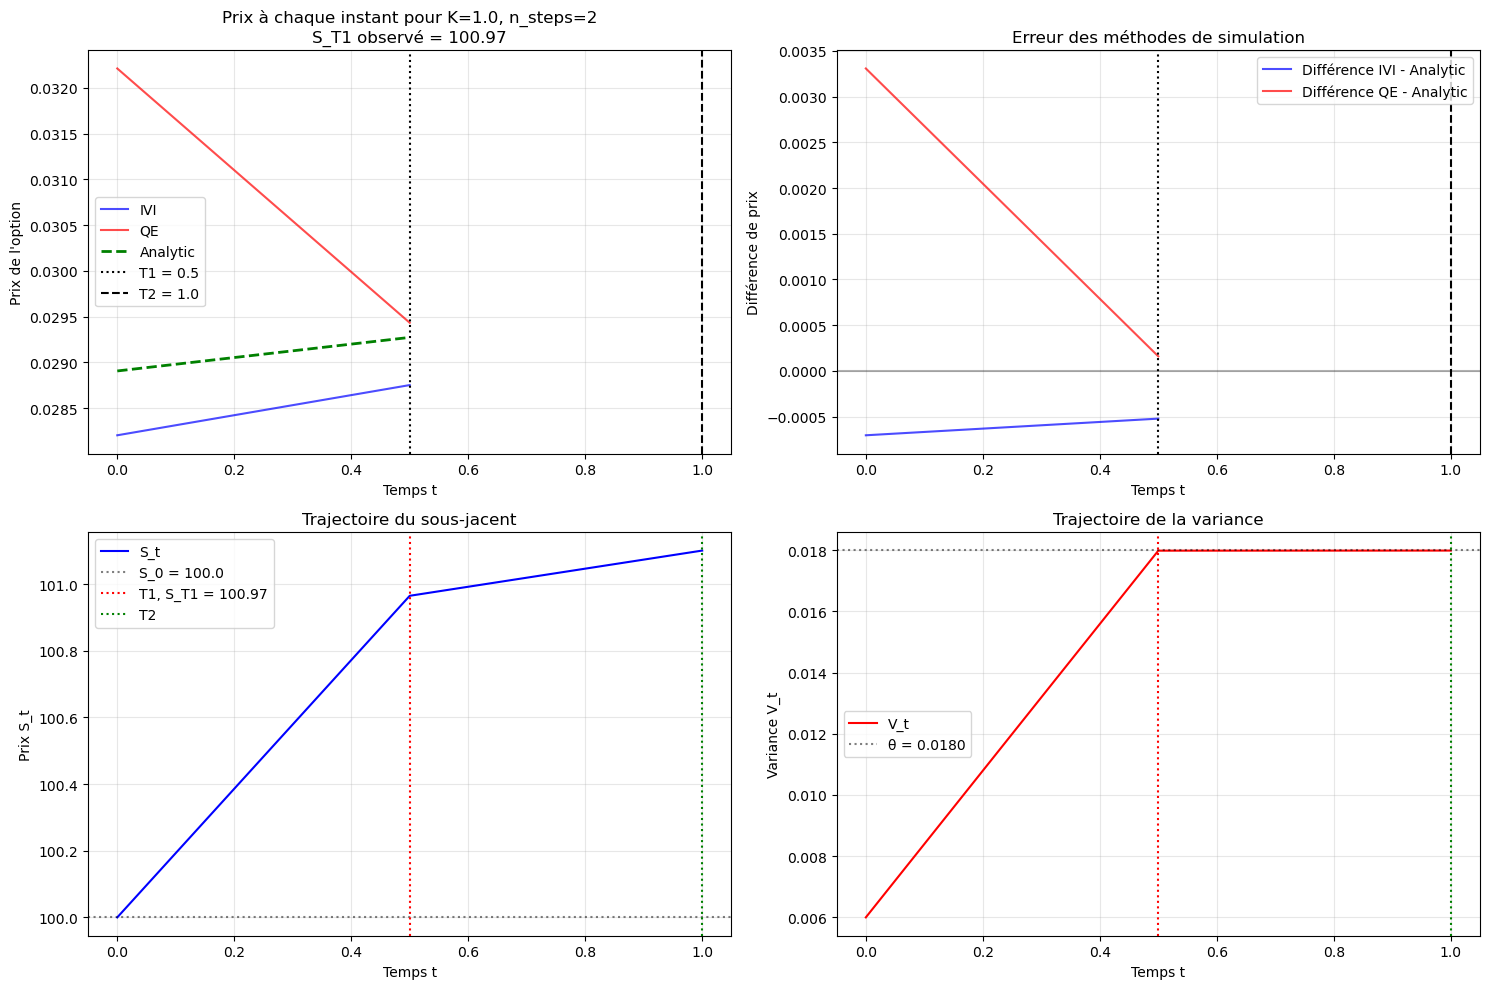


Analyse pour n_steps=2:
  Prix initial (t=0):
    IVI: 0.028203
    QE: 0.032212
    Analytic: 0.028906
  Prix à t=T1: (index 1)
    IVI: 0.028752
    QE: 0.029432
    Analytic: 0.029273
n_steps = 4
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.027818, QE: 0.031093, Analytic: 0.028906
  Calcul du prix à t = 0.250 (index 1)
    IVI: 0.028271, QE: 0.031174, Analytic: 0.028905
  Calcul du prix à t = 0.500 (index 2)
    IVI: 0.027804, QE: 0.030420, Analytic: 0.029189
  Calcul du prix à t = 0.750 (index 3)
    IVI: 0.076949, QE: 0.077879, Analytic: 0.078644


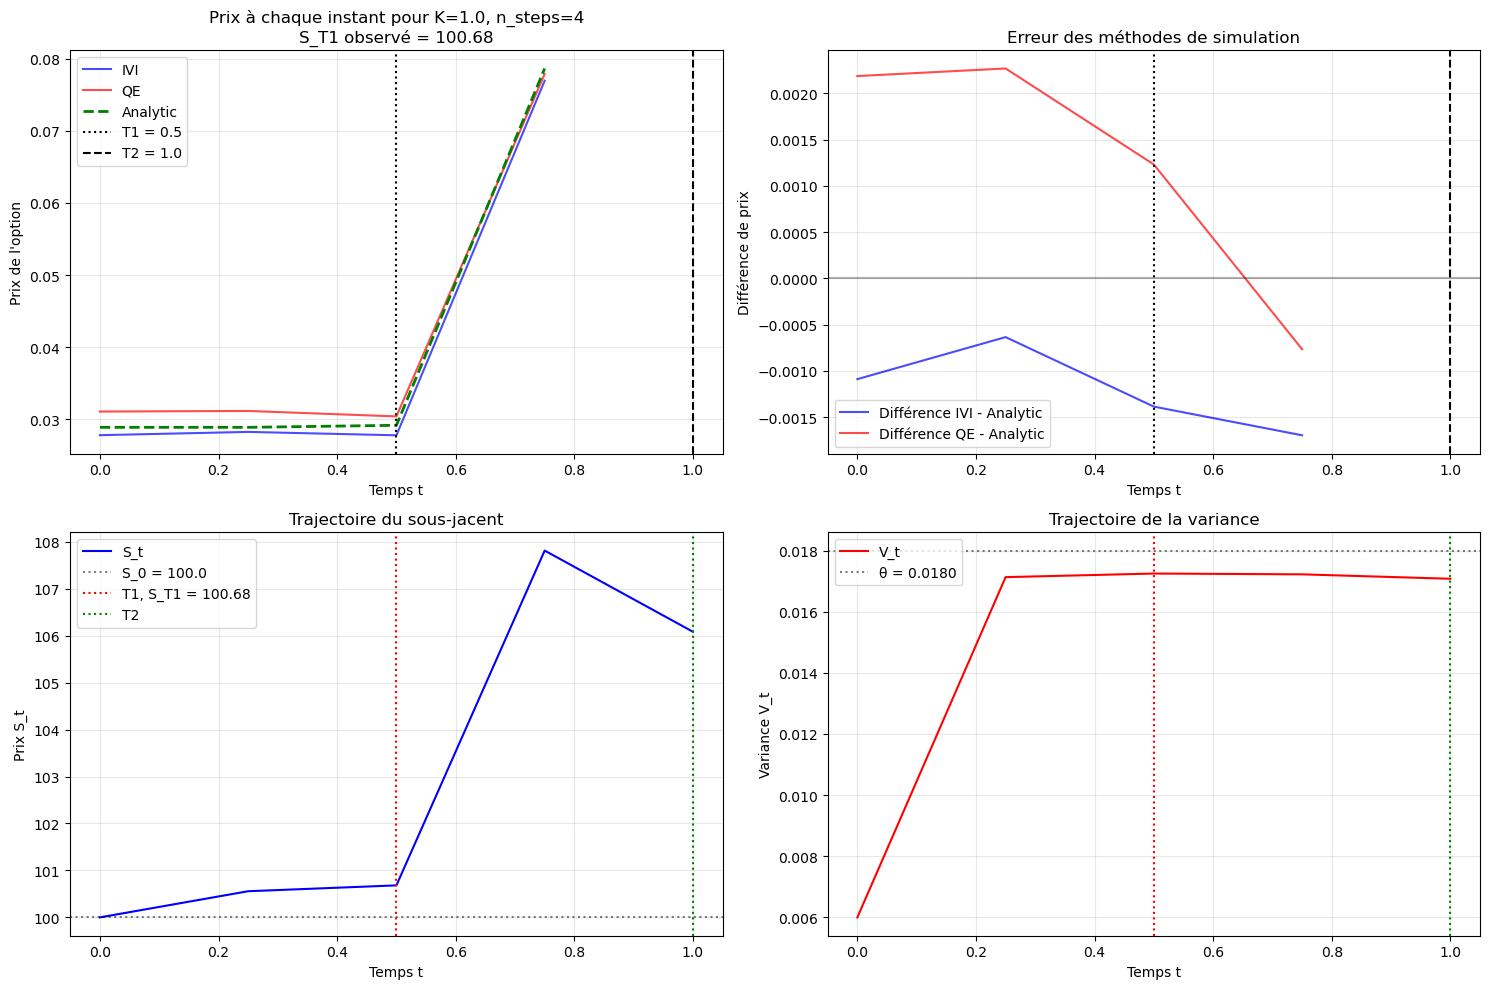


Analyse pour n_steps=4:
  Prix initial (t=0):
    IVI: 0.027818
    QE: 0.031093
    Analytic: 0.028906
  Prix à t=T1: (index 2)
    IVI: 0.027804
    QE: 0.030420
    Analytic: 0.029189
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.000468
    QE: -0.000754
    Analytic: 0.000284
n_steps = 6
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.028037, QE: 0.031717, Analytic: 0.028906
  Calcul du prix à t = 0.167 (index 1)
    IVI: 0.027831, QE: 0.030993, Analytic: 0.028905
  Calcul du prix à t = 0.333 (index 2)
    IVI: 0.028269, QE: 0.031181, Analytic: 0.028895
  Calcul du prix à t = 0.500 (index 3)
    IVI: 0.028406, QE: 0.030949, Analytic: 0.028991
  Calcul du prix à t = 0.667 (index 4)
    IVI: 0.014457, QE: 0.015747, Analytic: 0.015653
  Calcul du prix à t = 0.833 (index 5)
    IVI: 0.013307, QE: 0.015741, Analytic: 0.014719


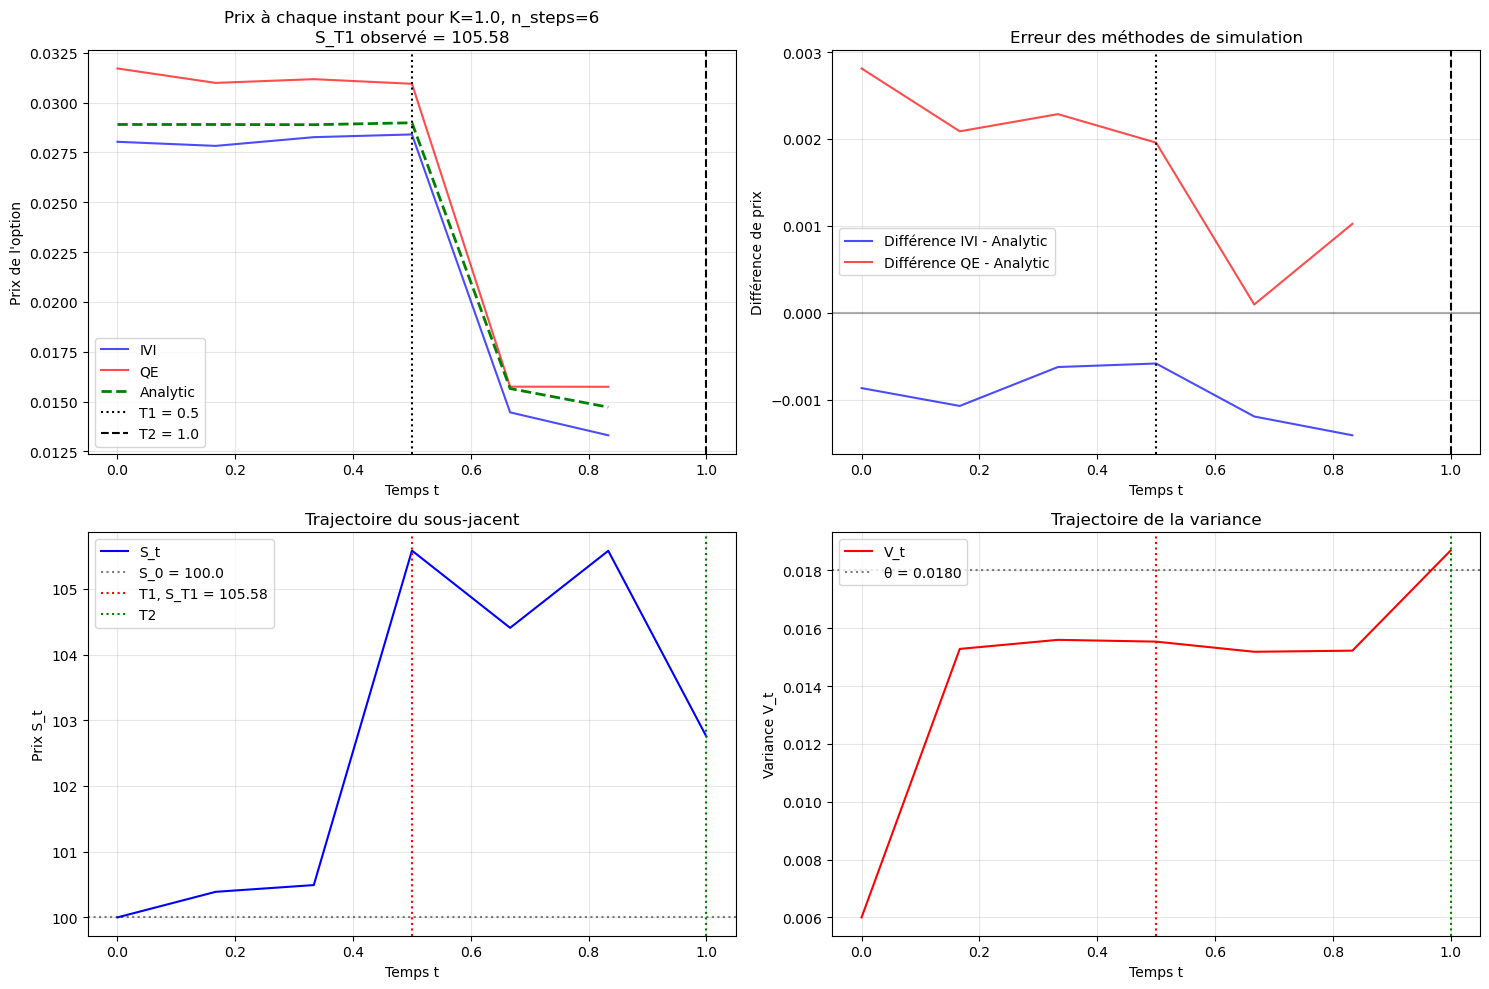


Analyse pour n_steps=6:
  Prix initial (t=0):
    IVI: 0.028037
    QE: 0.031717
    Analytic: 0.028906
  Prix à t=T1: (index 3)
    IVI: 0.028406
    QE: 0.030949
    Analytic: 0.028991
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: 0.000137
    QE: -0.000232
    Analytic: 0.000096
n_steps = 8
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.027677, QE: 0.030898, Analytic: 0.028906
  Calcul du prix à t = 0.125 (index 1)
    IVI: 0.028669, QE: 0.030207, Analytic: 0.028905
  Calcul du prix à t = 0.250 (index 2)
    IVI: 0.028520, QE: 0.030416, Analytic: 0.028901
  Calcul du prix à t = 0.375 (index 3)
    IVI: 0.028724, QE: 0.031219, Analytic: 0.028867
  Calcul du prix à t = 0.500 (index 4)
    IVI: 0.027968, QE: 0.030273, Analytic: 0.028730
  Calcul du prix à t = 0.625 (index 5)
    IVI: 0.029084, QE: 0.031842, Analytic: 0.029965
  Calcul du prix à t = 0.750 (index 6)
    IVI: 0.009632, QE: 0.011383, Analytic: 0.011032
  Calcul du prix à t = 0.875 (index 7)
    IVI: 0.000086, QE: 0.00

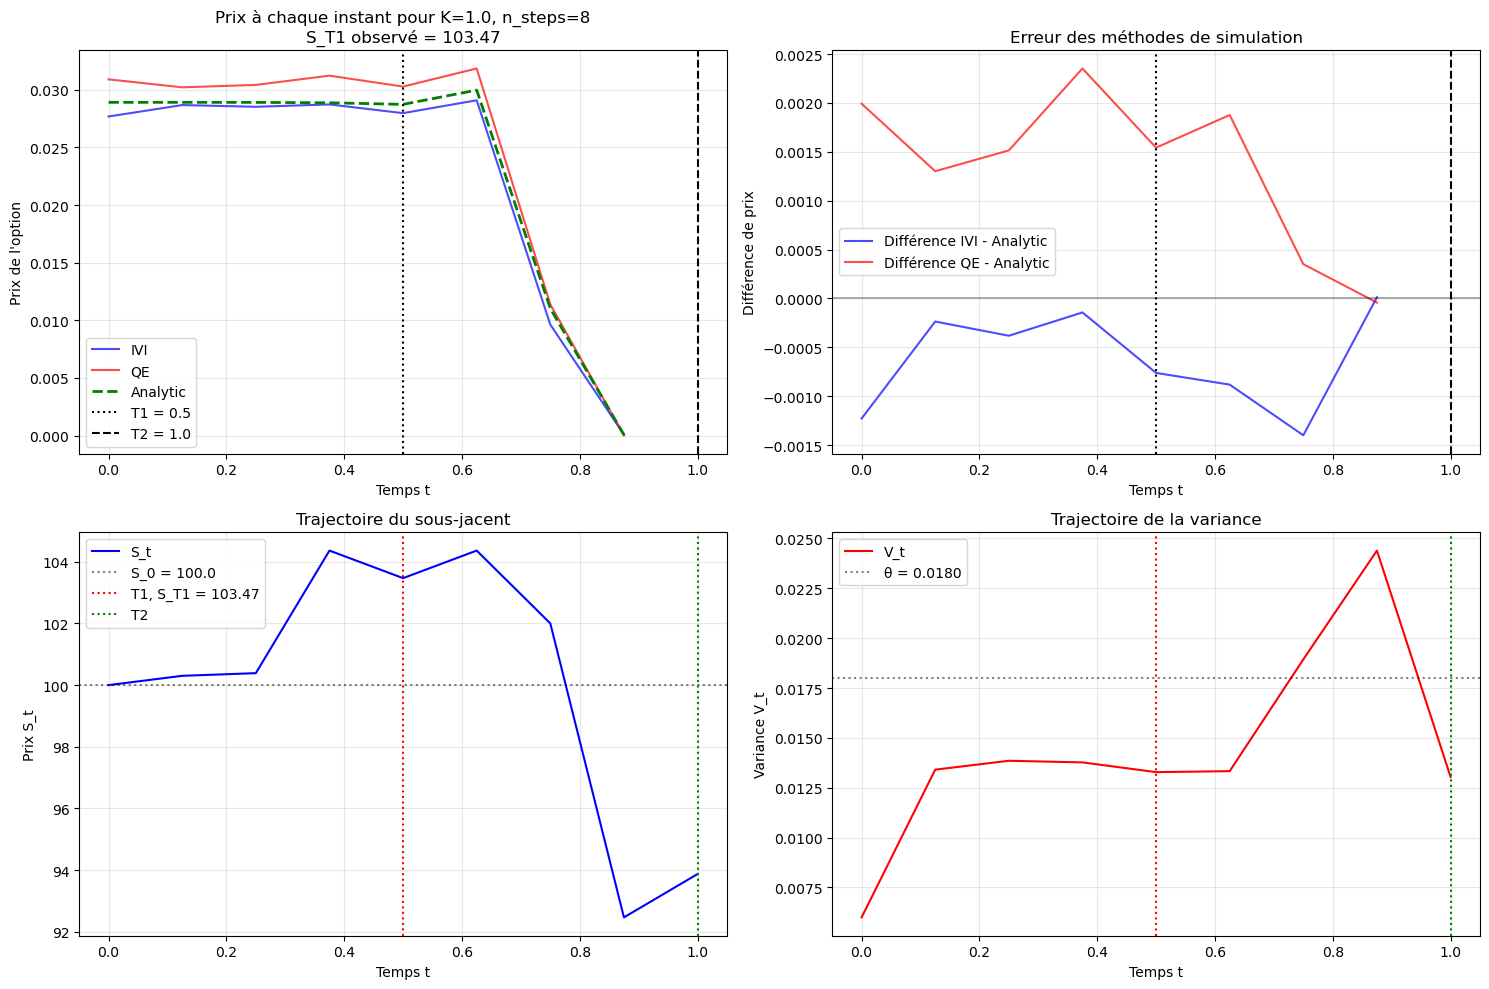


Analyse pour n_steps=8:
  Prix initial (t=0):
    IVI: 0.027677
    QE: 0.030898
    Analytic: 0.028906
  Prix à t=T1: (index 4)
    IVI: 0.027968
    QE: 0.030273
    Analytic: 0.028730
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.000755
    QE: -0.000946
    Analytic: -0.000136
n_steps = 16
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.027589, QE: 0.029183, Analytic: 0.028906
  Calcul du prix à t = 0.062 (index 1)
    IVI: 0.028402, QE: 0.029699, Analytic: 0.028906
  Calcul du prix à t = 0.125 (index 2)
    IVI: 0.027780, QE: 0.029947, Analytic: 0.028905
  Calcul du prix à t = 0.188 (index 3)
    IVI: 0.029385, QE: 0.030046, Analytic: 0.028903
  Calcul du prix à t = 0.250 (index 4)
    IVI: 0.027960, QE: 0.029745, Analytic: 0.028895
  Calcul du prix à t = 0.312 (index 5)
    IVI: 0.028060, QE: 0.029715, Analytic: 0.028875
  Calcul du prix à t = 0.375 (index 6)
    IVI: 0.027918, QE: 0.029384, Analytic: 0.028903
  Calcul du prix à t = 0.438 (index 7)
    IVI: 0.030025, QE: 0

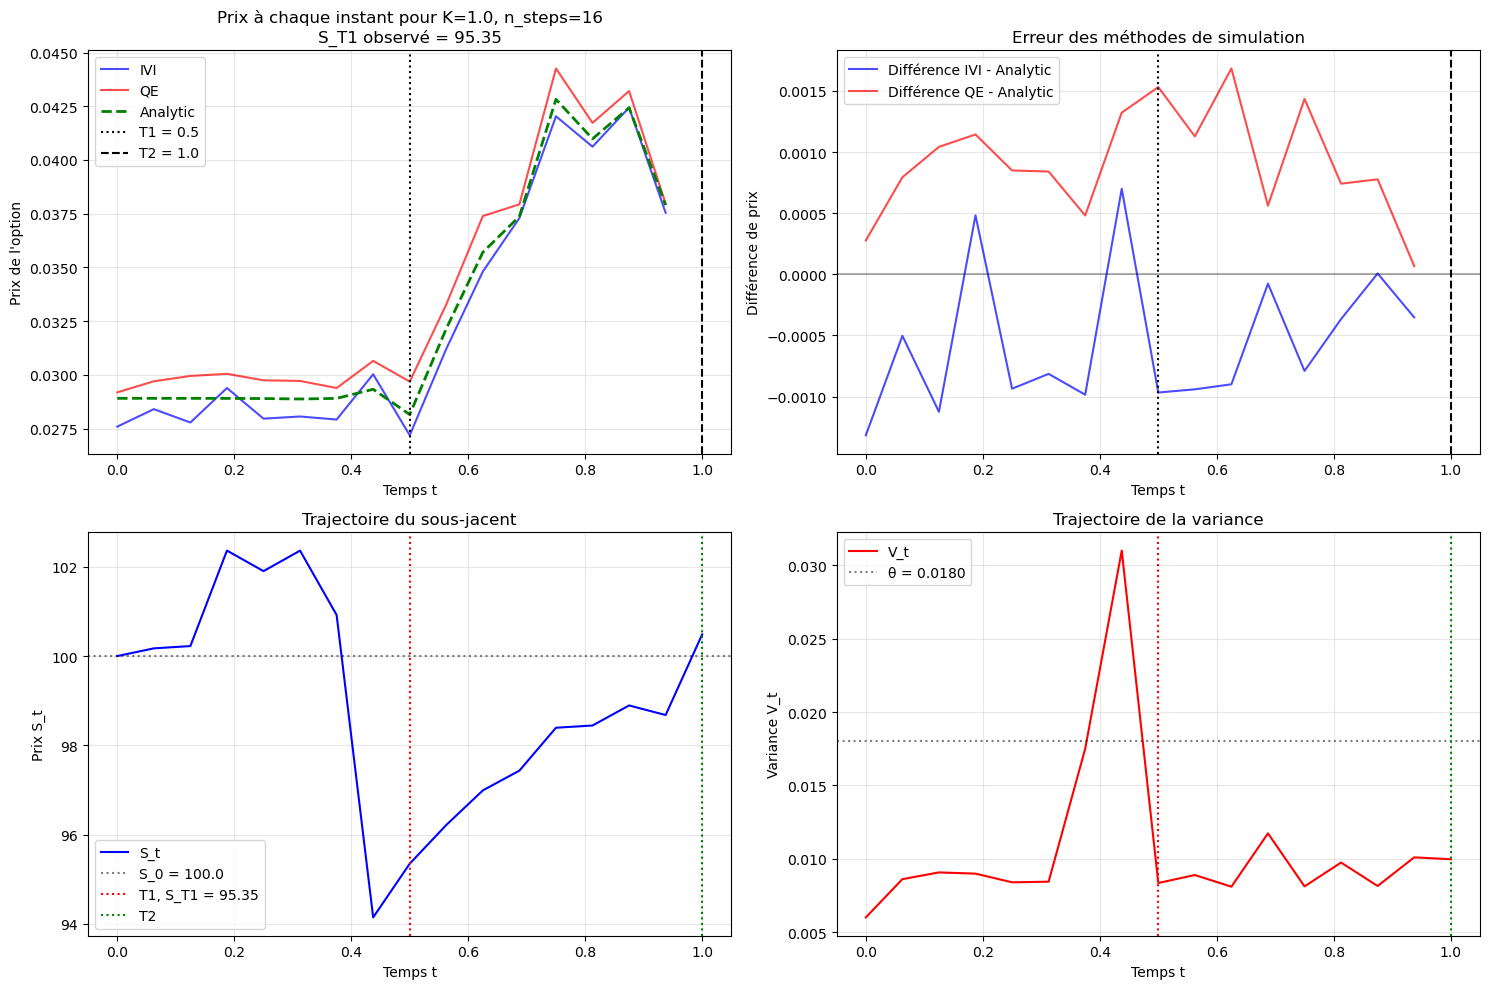


Analyse pour n_steps=16:
  Prix initial (t=0):
    IVI: 0.027589
    QE: 0.029183
    Analytic: 0.028906
  Prix à t=T1: (index 8)
    IVI: 0.027186
    QE: 0.029684
    Analytic: 0.028153
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.002839
    QE: -0.000964
    Analytic: -0.001173
n_steps = 26
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.029823, QE: 0.029501, Analytic: 0.028906
  Calcul du prix à t = 0.038 (index 1)
    IVI: 0.028712, QE: 0.029470, Analytic: 0.028906
  Calcul du prix à t = 0.077 (index 2)
    IVI: 0.028402, QE: 0.028811, Analytic: 0.028905
  Calcul du prix à t = 0.115 (index 3)
    IVI: 0.029127, QE: 0.029381, Analytic: 0.028905
  Calcul du prix à t = 0.154 (index 4)
    IVI: 0.029319, QE: 0.028515, Analytic: 0.028903
  Calcul du prix à t = 0.192 (index 5)
    IVI: 0.029098, QE: 0.029770, Analytic: 0.028901
  Calcul du prix à t = 0.231 (index 6)
    IVI: 0.028676, QE: 0.030239, Analytic: 0.028903
  Calcul du prix à t = 0.269 (index 7)
    IVI: 0.028743, QE: 

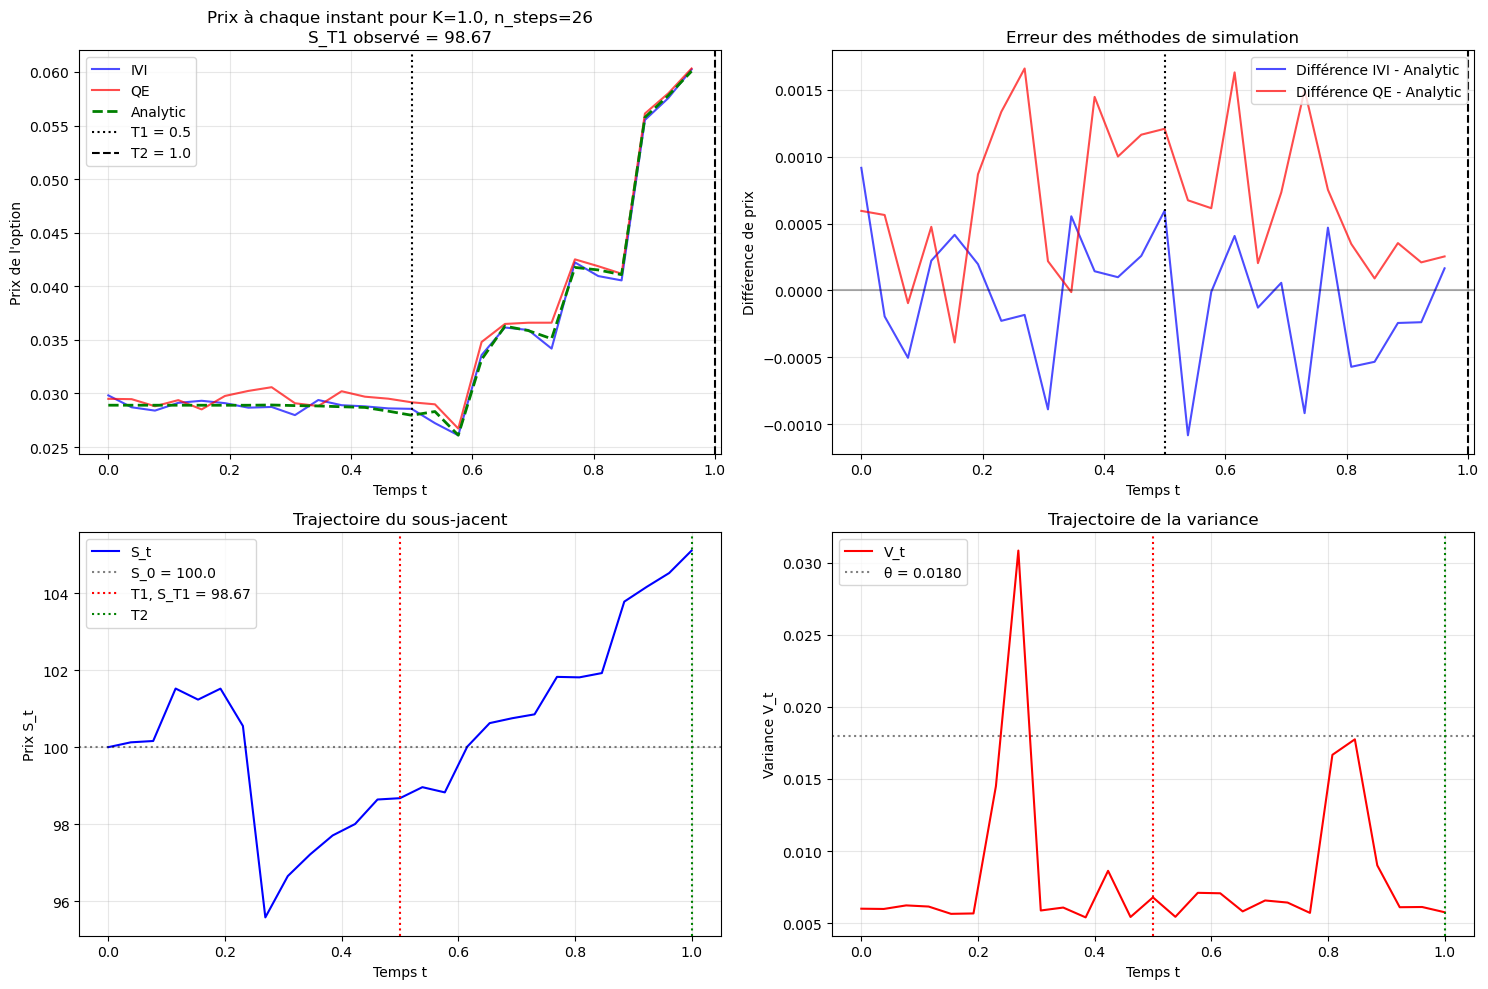


Analyse pour n_steps=26:
  Prix initial (t=0):
    IVI: 0.029823
    QE: 0.029501
    Analytic: 0.028906
  Prix à t=T1: (index 13)
    IVI: 0.028565
    QE: 0.029177
    Analytic: 0.027969
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.000043
    QE: -0.000337
    Analytic: -0.000381
n_steps = 36
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.028821, QE: 0.030456, Analytic: 0.028906
  Calcul du prix à t = 0.028 (index 1)
    IVI: 0.028408, QE: 0.029063, Analytic: 0.028906
  Calcul du prix à t = 0.056 (index 2)
    IVI: 0.029197, QE: 0.028505, Analytic: 0.028905
  Calcul du prix à t = 0.083 (index 3)
    IVI: 0.028636, QE: 0.029037, Analytic: 0.028905
  Calcul du prix à t = 0.111 (index 4)
    IVI: 0.028938, QE: 0.029166, Analytic: 0.028905
  Calcul du prix à t = 0.139 (index 5)
    IVI: 0.028087, QE: 0.028468, Analytic: 0.028904
  Calcul du prix à t = 0.167 (index 6)
    IVI: 0.028687, QE: 0.030405, Analytic: 0.028904
  Calcul du prix à t = 0.194 (index 7)
    IVI: 0.029959, QE:

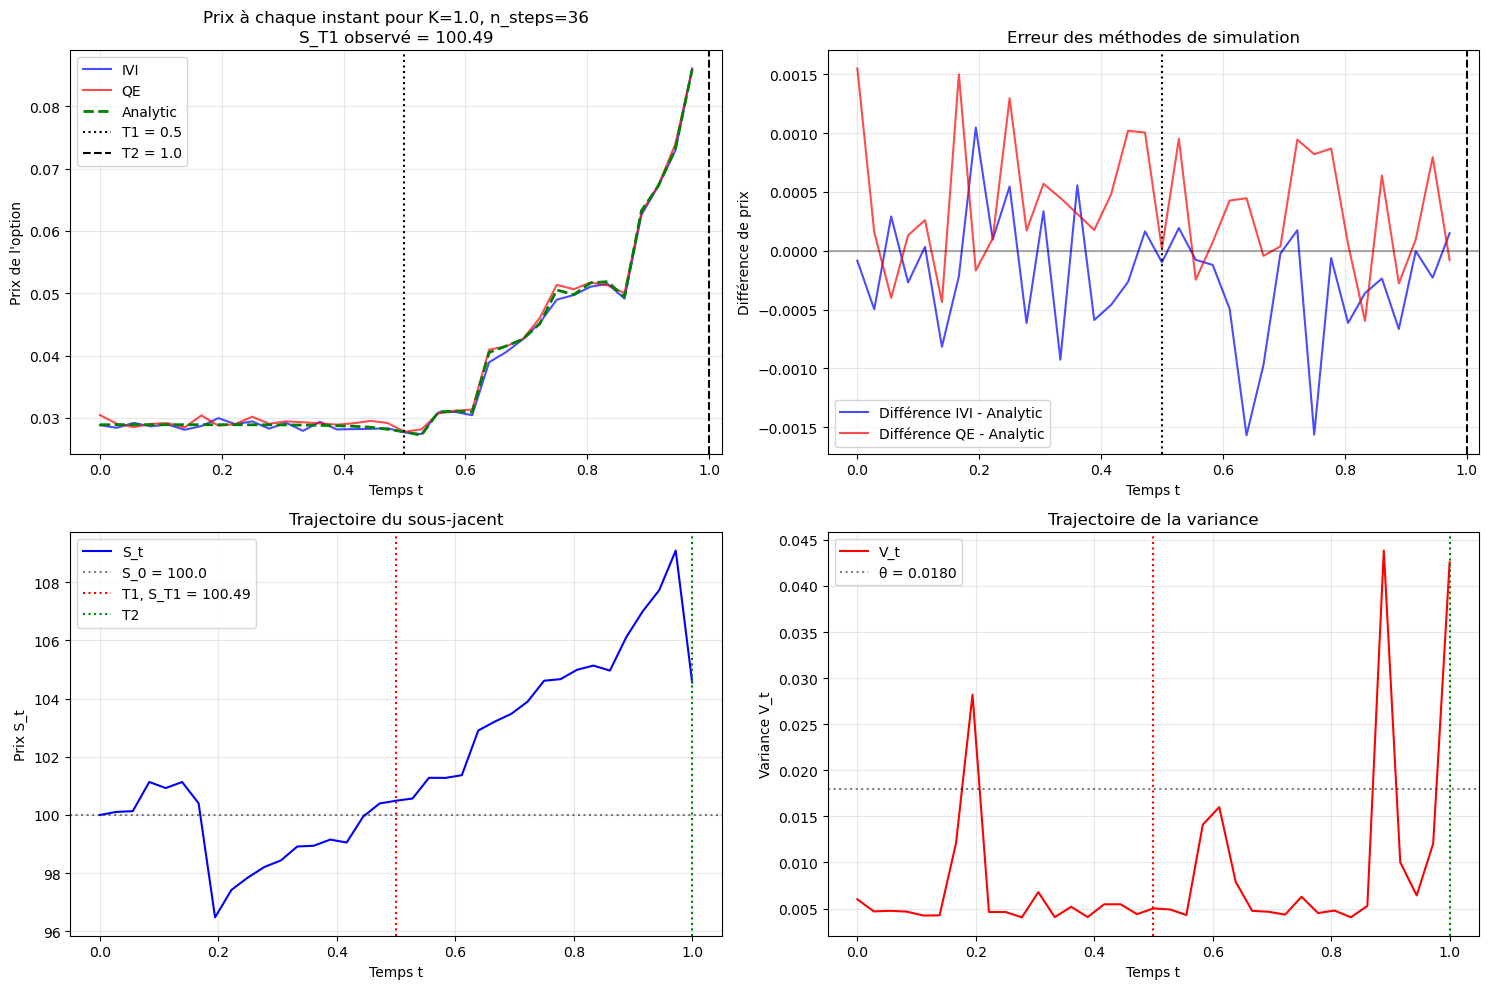


Analyse pour n_steps=36:
  Prix initial (t=0):
    IVI: 0.028821
    QE: 0.030456
    Analytic: 0.028906
  Prix à t=T1: (index 18)
    IVI: 0.027660
    QE: 0.027774
    Analytic: 0.027758
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.000675
    QE: -0.001401
    Analytic: -0.000412
n_steps = 50
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.028338, QE: 0.028602, Analytic: 0.028906
  Calcul du prix à t = 0.020 (index 1)
    IVI: 0.029884, QE: 0.029325, Analytic: 0.028906
  Calcul du prix à t = 0.040 (index 2)
    IVI: 0.029323, QE: 0.029201, Analytic: 0.028906
  Calcul du prix à t = 0.060 (index 3)
    IVI: 0.029151, QE: 0.028439, Analytic: 0.028905
  Calcul du prix à t = 0.080 (index 4)
    IVI: 0.030015, QE: 0.029014, Analytic: 0.028905
  Calcul du prix à t = 0.100 (index 5)
    IVI: 0.027760, QE: 0.028897, Analytic: 0.028905
  Calcul du prix à t = 0.120 (index 6)
    IVI: 0.028911, QE: 0.029234, Analytic: 0.028905
  Calcul du prix à t = 0.140 (index 7)
    IVI: 0.028466, QE:

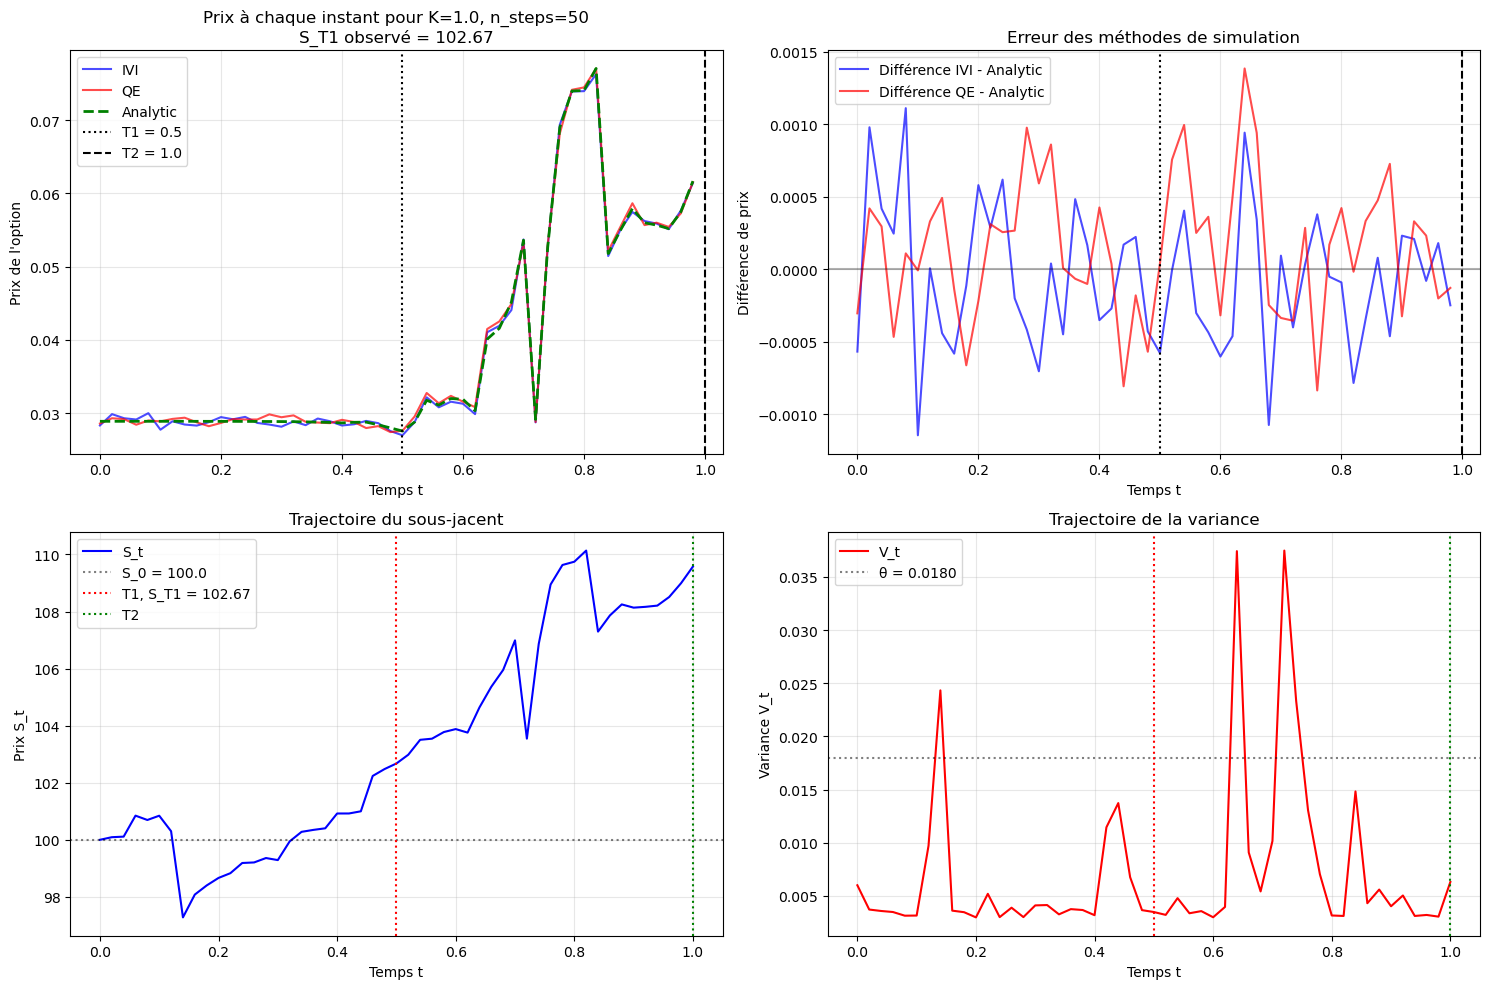


Analyse pour n_steps=50:
  Prix initial (t=0):
    IVI: 0.028338
    QE: 0.028602
    Analytic: 0.028906
  Prix à t=T1: (index 25)
    IVI: 0.026999
    QE: 0.027614
    Analytic: 0.027576
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.000577
    QE: 0.000178
    Analytic: -0.000429
n_steps = 66
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.029795, QE: 0.029688, Analytic: 0.028906
  Calcul du prix à t = 0.015 (index 1)
    IVI: 0.029294, QE: 0.028211, Analytic: 0.028906
  Calcul du prix à t = 0.030 (index 2)
    IVI: 0.028638, QE: 0.028380, Analytic: 0.028906
  Calcul du prix à t = 0.045 (index 3)
    IVI: 0.028743, QE: 0.028811, Analytic: 0.028905
  Calcul du prix à t = 0.061 (index 4)
    IVI: 0.028974, QE: 0.029920, Analytic: 0.028905
  Calcul du prix à t = 0.076 (index 5)
    IVI: 0.027026, QE: 0.029037, Analytic: 0.028905
  Calcul du prix à t = 0.091 (index 6)
    IVI: 0.028532, QE: 0.029961, Analytic: 0.028905
  Calcul du prix à t = 0.106 (index 7)
    IVI: 0.028778, QE: 

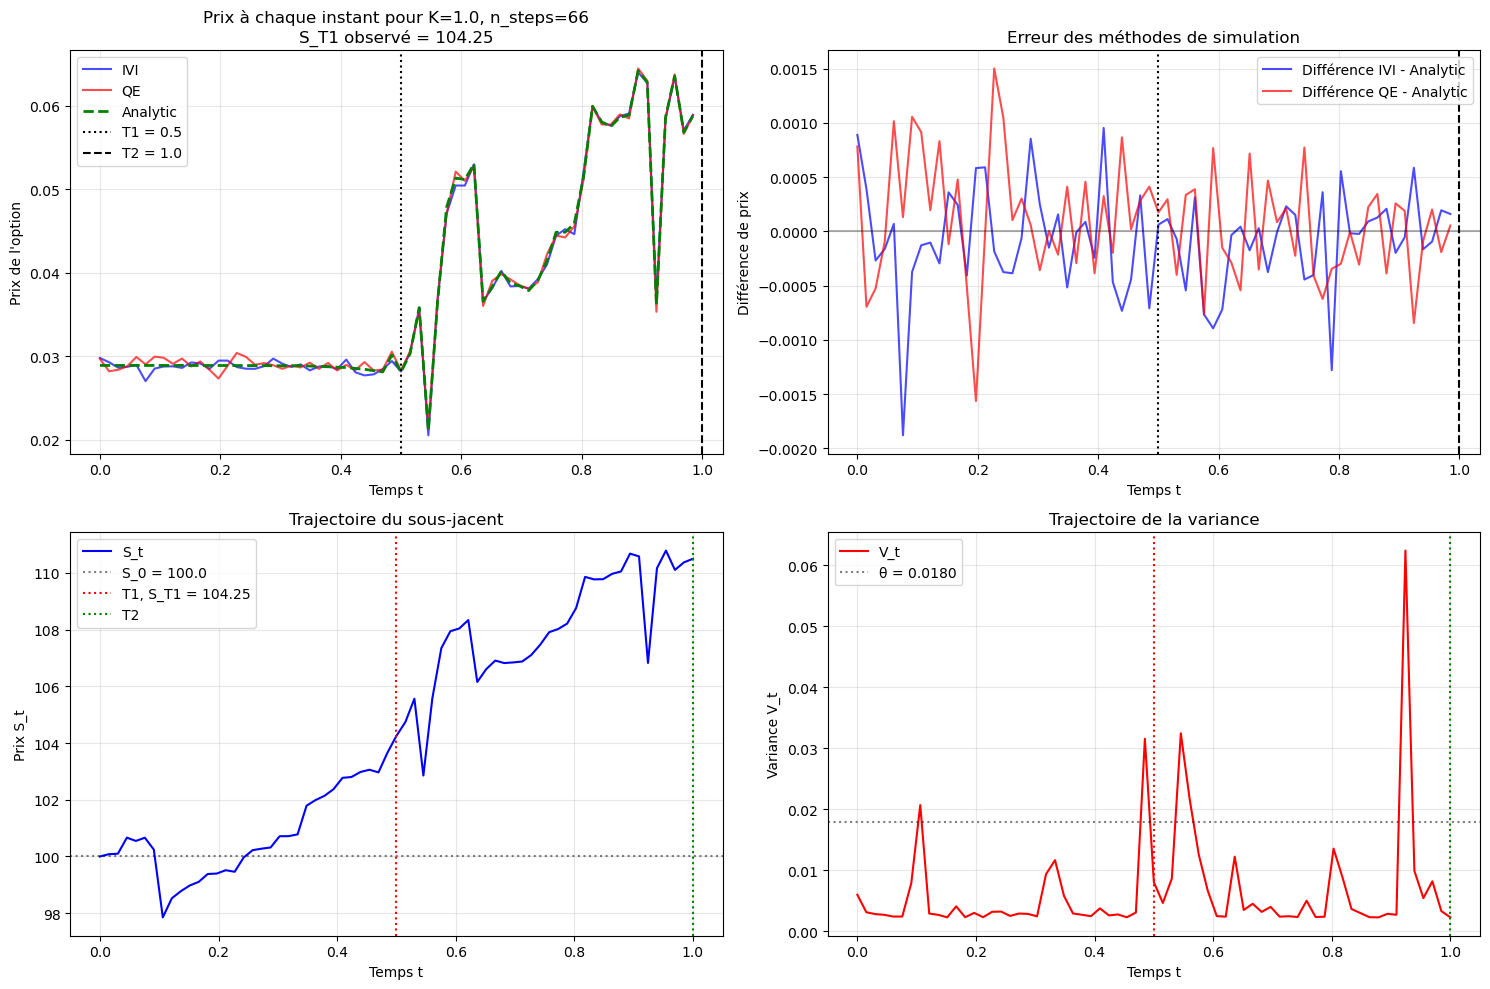


Analyse pour n_steps=66:
  Prix initial (t=0):
    IVI: 0.029795
    QE: 0.029688
    Analytic: 0.028906
  Prix à t=T1: (index 33)
    IVI: 0.028181
    QE: 0.028295
    Analytic: 0.028120
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.001248
    QE: -0.002256
    Analytic: -0.002019
n_steps = 80
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.028024, QE: 0.028786, Analytic: 0.028906
  Calcul du prix à t = 0.013 (index 1)
    IVI: 0.027936, QE: 0.029644, Analytic: 0.028906
  Calcul du prix à t = 0.025 (index 2)
    IVI: 0.028076, QE: 0.029120, Analytic: 0.028906
  Calcul du prix à t = 0.038 (index 3)
    IVI: 0.028815, QE: 0.028816, Analytic: 0.028906
  Calcul du prix à t = 0.050 (index 4)
    IVI: 0.027867, QE: 0.029268, Analytic: 0.028905
  Calcul du prix à t = 0.062 (index 5)
    IVI: 0.028511, QE: 0.028729, Analytic: 0.028905
  Calcul du prix à t = 0.075 (index 6)
    IVI: 0.029242, QE: 0.029417, Analytic: 0.028905
  Calcul du prix à t = 0.088 (index 7)
    IVI: 0.028775, QE:

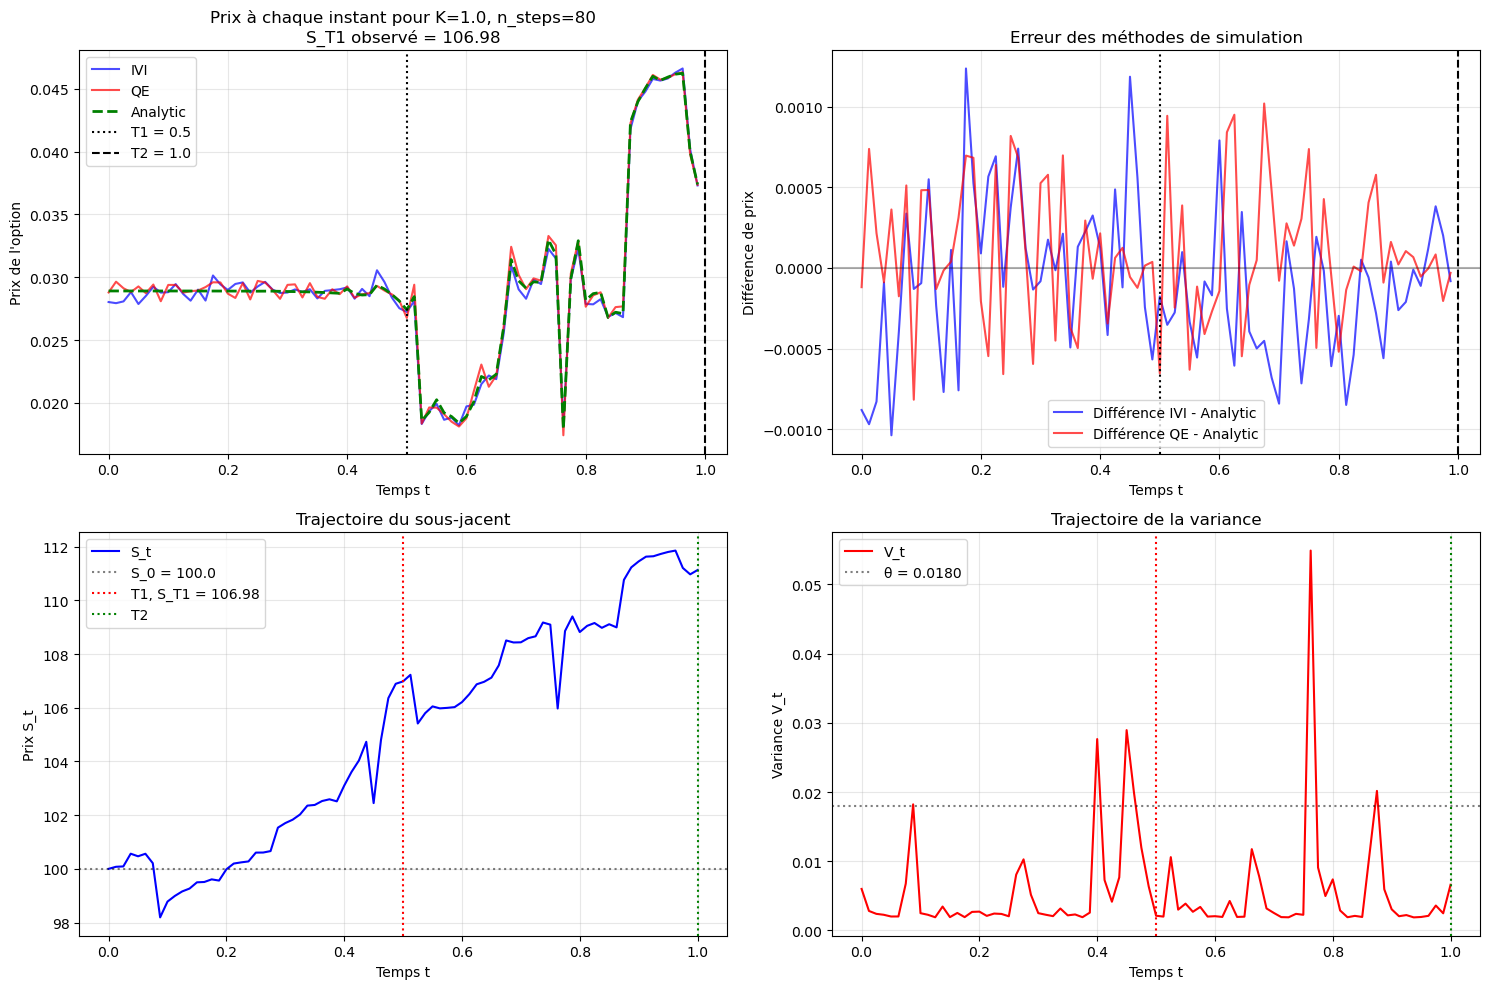


Analyse pour n_steps=80:
  Prix initial (t=0):
    IVI: 0.028024
    QE: 0.028786
    Analytic: 0.028906
  Prix à t=T1: (index 40)
    IVI: 0.027237
    QE: 0.026760
    Analytic: 0.027415
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.000296
    QE: -0.001379
    Analytic: -0.000687


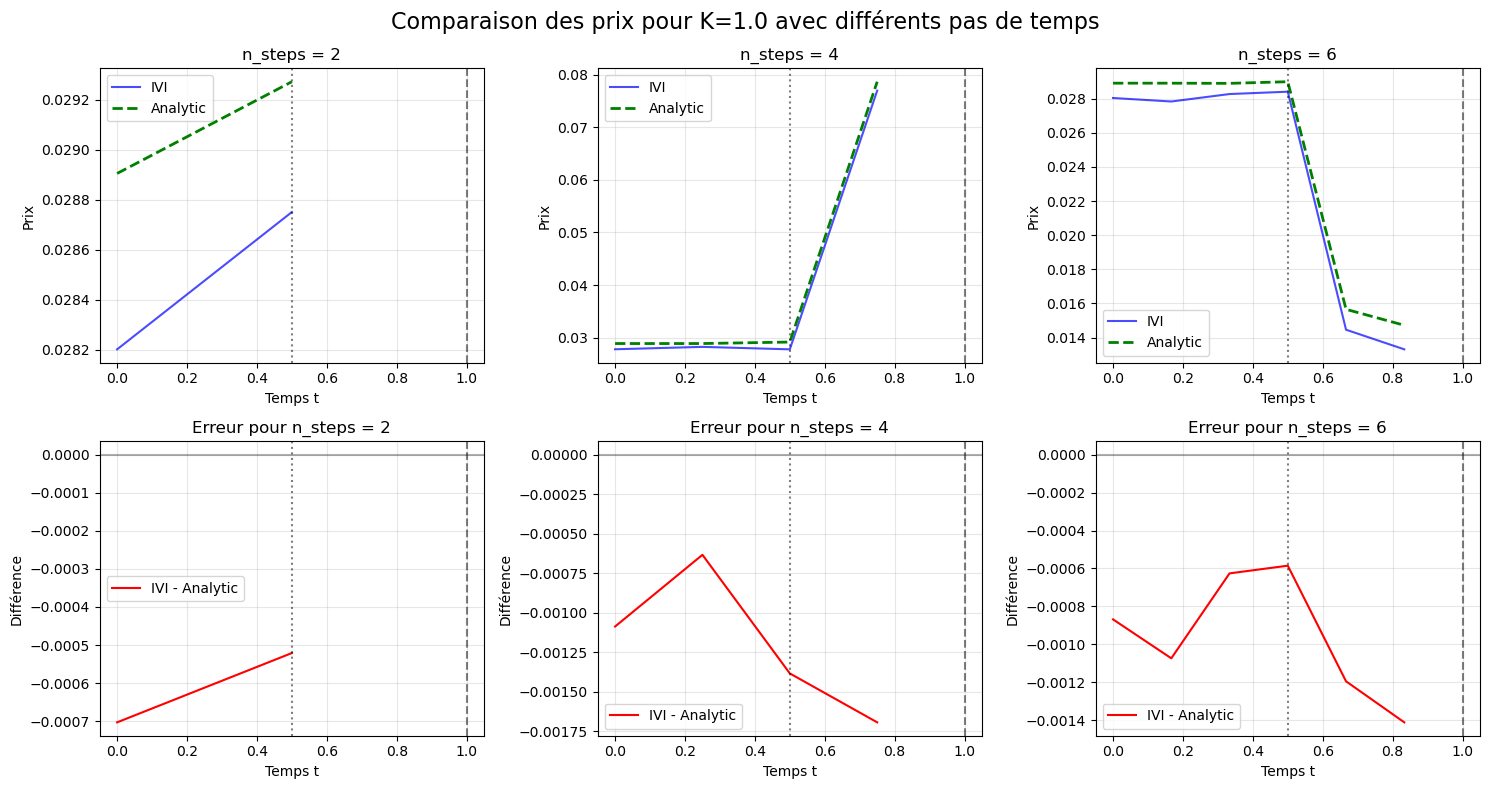


RÉCAPITULATIF DES RÉSULTATS

Paramètres du modèle:
  S_0 = 100.0
  V_0 = 0.006
  K = 1.0
  T1 = 0.5, T2 = 1.0
  kappa = 17.2500, theta = 0.0180, sigma = 2.9500, rho = -0.6800

Comparaison des méthodes (prix initial à t=0):
 n_steps          IVI           QE     Analytic     Diff IVI      Diff QE
       2     0.028203     0.032212     0.028906    -0.000703     0.003307
       4     0.027818     0.031093     0.028906    -0.001088     0.002187
       6     0.028037     0.031717     0.028906    -0.000869     0.002811
       8     0.027677     0.030898     0.028906    -0.001229     0.001992
      16     0.027589     0.029183     0.028906    -0.001317     0.000277
      26     0.029823     0.029501     0.028906     0.000917     0.000595
      36     0.028821     0.030456     0.028906    -0.000085     0.001550
      50     0.028338     0.028602     0.028906    -0.000568    -0.000304
      66     0.029795     0.029688     0.028906     0.000889     0.000782
      80     0.028024     0.028786  

In [ ]:
# FIXER K
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[0]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K = 1.0  # Strike fixé
r = 0

# Liste pour stocker les résultats par n_steps
results_by_nsteps = {}

for n_steps in N_steps:
    print(f"n_steps = {n_steps}")
    
    # Indices temporels
    T1_idx = int(n_steps/2)
    T2_idx = n_steps
    
    # On génère UNE trajectoire de référence
    t_vec, V_paths, U_paths, Z_paths, S_paths = simulate_paths(
        a, b, c, rho, V_0, T2, n_steps, n_paths=1, S_0=S_0
    )
    
    # Valeur de S_T1 observée sur cette trajectoire
    S_T1 = S_paths[T1_idx, 0]
    
    # Initialisation des listes pour chaque instant
    times = []
    ivi_prices_at_t = []
    QE_prices_at_t = []
    analytic_prices_at_t = []
    
    # On calcule le prix à CHAQUE instant (sauf le dernier)
    for i in range(len(t_vec)):
        t_i = t_vec[i]
        
        # On ne peut pas calculer le prix à T2 (payoff connu)
        if i == T2_idx:
            continue
            
        print(f"  Calcul du prix à t = {t_i:.3f} (index {i})")
        
        # Valeurs à l'instant t_i
        S_ti = S_paths[i, 0]
        V_ti = V_paths[i, 0]
        
        
        # DÉTERMINER SI ON EST AVANT OU APRÈS T1
       
        if i <= T1_idx:
            # AVANT T1: S_T1 est encore inconnu
            # Pour les simulations, on doit simuler jusqu'à T1 ET jusqu'à T2
            
            # 1. SIMULATION IVI
            _, _, _, _, S_curr = simulate_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,  # Réduit pour performance
                S_idx=S_ti,
                U_idx=U_paths[i, 0], 
                Z_idx=Z_paths[i, 0]
            )
            
            # À t < T1, on doit extraire S_T1 et S_T2
            relative_T1_idx = T1_idx - i
            S_T1_sim = S_curr[relative_T1_idx, :]  # S_T1 simulé
            S_T2_sim = S_curr[-1, :]  # S_T2
            
            payoff_ivi = np.maximum(S_T2_sim / S_T1_sim - K, 0)
            price_ivi = np.mean(payoff_ivi)
            
            # 2. SIMULATION QE
            S_curr_qe, _, _ = simulate_QE_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0]
            )
            
            S_T1_sim_qe = S_curr_qe[relative_T1_idx, :]
            S_T2_sim_qe = S_curr_qe[-1, :]
            
            payoff_qe = np.maximum(S_T2_sim_qe / S_T1_sim_qe - K, 0)
            price_qe = np.mean(payoff_qe)
            
            # 3. FORMULE ANALYTIQUE (t < T1)
            # Pour t < T1, on utilise char_func_t_t1 qui nécessite v0
            price_analytic = conditional_expectation(
                t=t_i, 
                T1=T1, 
                T2=T2, 
                K=K, 
                v_t=V_ti, 
                s_t=S_ti,
                s_T1=S_T1,  # Cette valeur ne sera pas utilisée pour t < T1 dans char_func_t_t1
                kappa=kappa, 
                theta=theta, 
                sigma=sigma, 
                rho=rho, 
                r=r,
                v0=V_0  # Nécessaire pour t < T1
            )
            
        else:
            # APRÈS T1: S_T1 est connu
            # 1. SIMULATION IVI
            _, _, _, _, S_curr = simulate_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0], 
                Z_idx=Z_paths[i, 0]
            )
            
            # À t >= T1, S_T1 est fixé (celui de la trajectoire de référence)
            S_T1_fixed = S_T1 * np.ones(5000)
            S_T2_sim = S_curr[-1, :]
            
            payoff_ivi = np.maximum(S_T2_sim / S_T1_fixed - K, 0)
            price_ivi = np.mean(payoff_ivi)
            
            # 2. SIMULATION QE
            S_curr_qe, _, _ = simulate_QE_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0]
            )
            
            S_T1_fixed_qe = S_T1 * np.ones(5000)
            S_T2_sim_qe = S_curr_qe[-1, :]
            
            payoff_qe = np.maximum(S_T2_sim_qe / S_T1_fixed_qe - K, 0)
            price_qe = np.mean(payoff_qe)
            
            # 3. FORMULE ANALYTIQUE (t >= T1)
            price_analytic = conditional_expectation(
                t=t_i, 
                T1=T1, 
                T2=T2, 
                K=K, 
                v_t=V_ti, 
                s_t=S_ti,
                s_T1=S_T1,  # S_T1 connu
                kappa=kappa, 
                theta=theta, 
                sigma=sigma, 
                rho=rho, 
                r=r
                # v0 pas nécessaire pour t >= T1
            )
        
        # Stocker les résultats
        times.append(t_i)
        ivi_prices_at_t.append(price_ivi)
        QE_prices_at_t.append(price_qe)
        analytic_prices_at_t.append(price_analytic)
        
        print(f"    IVI: {price_ivi:.6f}, QE: {price_qe:.6f}, Analytic: {price_analytic:.6f}")
    
    # Stocker les résultats pour ce n_steps
    results_by_nsteps[n_steps] = {
        'times': times,
        'ivi_prices': ivi_prices_at_t,
        'qe_prices': QE_prices_at_t,
        'analytic_prices': analytic_prices_at_t,
        'S_path': S_paths[:, 0],
        'V_path': V_paths[:, 0],
        't_vec': t_vec,
        'S_T1': S_T1
    }
    
    
    # VISUALISATION POUR CE n_steps
  
    plt.figure(figsize=(15, 10))
    
    # Sous-figure 1: Prix à chaque instant
    plt.subplot(2, 2, 1)
    plt.plot(times, ivi_prices_at_t, 'b-', label='IVI', alpha=0.7)
    plt.plot(times, QE_prices_at_t, 'r-', label='QE', alpha=0.7)
    plt.plot(times, analytic_prices_at_t, 'g--', label='Analytic', linewidth=2)
    
    # Marquer T1 et T2
    plt.axvline(x=T1, color='k', linestyle=':', label=f'T1 = {T1}')
    plt.axvline(x=T2, color='k', linestyle='--', label=f'T2 = {T2}')
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix de l\'option')
    plt.title(f'Prix à chaque instant pour K={K}, n_steps={n_steps}\nS_T1 observé = {S_T1:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 2: Différences par rapport à la formule analytique
    plt.subplot(2, 2, 2)
    diff_ivi = np.array(ivi_prices_at_t) - np.array(analytic_prices_at_t)
    diff_qe = np.array(QE_prices_at_t) - np.array(analytic_prices_at_t)
    
    plt.plot(times, diff_ivi, 'b-', label='Différence IVI - Analytic', alpha=0.7)
    plt.plot(times, diff_qe, 'r-', label='Différence QE - Analytic', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=T1, color='k', linestyle=':')
    plt.axvline(x=T2, color='k', linestyle='--')
    
    plt.xlabel('Temps t')
    plt.ylabel('Différence de prix')
    plt.title('Erreur des méthodes de simulation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 3: Trajectoire du sous-jacent
    plt.subplot(2, 2, 3)
    plt.plot(t_vec, S_paths[:, 0], 'b-', label='S_t')
    plt.axhline(y=S_0, color='k', linestyle=':', alpha=0.5, label=f'S_0 = {S_0}')
    plt.axvline(x=T1, color='r', linestyle=':', label=f'T1, S_T1 = {S_T1:.2f}')
    plt.axvline(x=T2, color='g', linestyle=':', label=f'T2')
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix S_t')
    plt.title('Trajectoire du sous-jacent')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 4: Trajectoire de la variance
    plt.subplot(2, 2, 4)
    plt.plot(t_vec, V_paths[:, 0], 'r-', label='V_t')
    plt.axhline(y=theta, color='k', linestyle=':', alpha=0.5, label=f'θ = {theta:.4f}')
    plt.axvline(x=T1, color='r', linestyle=':')
    plt.axvline(x=T2, color='g', linestyle=':')
    
    plt.xlabel('Temps t')
    plt.ylabel('Variance V_t')
    plt.title('Trajectoire de la variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
    # ANALYSE DES RÉSULTATS
  
    print(f"\nAnalyse pour n_steps={n_steps}:")
    print(f"  Prix initial (t=0):")
    print(f"    IVI: {ivi_prices_at_t[0]:.6f}")
    print(f"    QE: {QE_prices_at_t[0]:.6f}")
    print(f"    Analytic: {analytic_prices_at_t[0]:.6f}")
    
    print(f"  Prix à t=T1: (index {T1_idx})")
    print(f"    IVI: {ivi_prices_at_t[T1_idx]:.6f}")
    print(f"    QE: {QE_prices_at_t[T1_idx]:.6f}")
    print(f"    Analytic: {analytic_prices_at_t[T1_idx]:.6f}")
    
    # Vérifier la continuité à T1
    if T1_idx > 0 and T1_idx < len(times)-1:
        jump_ivi = ivi_prices_at_t[T1_idx] - ivi_prices_at_t[T1_idx-1]
        jump_qe = QE_prices_at_t[T1_idx] - QE_prices_at_t[T1_idx-1]
        jump_analytic = analytic_prices_at_t[T1_idx] - analytic_prices_at_t[T1_idx-1]
        
        print(f"  Saut à T1 (prix(T1) - prix(T1-dt)):")
        print(f"    IVI: {jump_ivi:.6f}")
        print(f"    QE: {jump_qe:.6f}")
        print(f"    Analytic: {jump_analytic:.6f}")


# VISUALISATION COMPARATIVE POUR DIFFÉRENTS n_steps

plt.figure(figsize=(15, 8))

for idx, n_steps in enumerate(list(results_by_nsteps.keys())[:3]):  # Limiter à 3 n_steps pour lisibilité
    results = results_by_nsteps[n_steps]
    
    plt.subplot(2, 3, idx+1)
    plt.plot(results['times'], results['ivi_prices'], 'b-', label='IVI', alpha=0.7)
    plt.plot(results['times'], results['analytic_prices'], 'g--', label='Analytic', linewidth=2)
    plt.axvline(x=T1, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=T2, color='k', linestyle='--', alpha=0.5)
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix')
    plt.title(f'n_steps = {n_steps}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, idx+4)
    diff = np.array(results['ivi_prices']) - np.array(results['analytic_prices'])
    plt.plot(results['times'], diff, 'r-', label='IVI - Analytic')
    plt.axvline(x=T1, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=T2, color='k', linestyle='--', alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    plt.xlabel('Temps t')
    plt.ylabel('Différence')
    plt.title(f'Erreur pour n_steps = {n_steps}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle(f'Comparaison des prix pour K={K} avec différents pas de temps', fontsize=16)
plt.tight_layout()
plt.show()


# TABLEAU RÉCAPITULATIF

print("\n" + "="*80)
print("RÉCAPITULATIF DES RÉSULTATS")
print("="*80)

print(f"\nParamètres du modèle:")
print(f"  S_0 = {S_0}")
print(f"  V_0 = {V_0}")
print(f"  K = {K}")
print(f"  T1 = {T1}, T2 = {T2}")
print(f"  kappa = {kappa:.4f}, theta = {theta:.4f}, sigma = {sigma:.4f}, rho = {rho:.4f}")

print(f"\nComparaison des méthodes (prix initial à t=0):")
print(f"{'n_steps':>8} {'IVI':>12} {'QE':>12} {'Analytic':>12} {'Diff IVI':>12} {'Diff QE':>12}")

for n_steps in results_by_nsteps:
    results = results_by_nsteps[n_steps]
    price_ivi_0 = results['ivi_prices'][0]
    price_qe_0 = results['qe_prices'][0]
    price_analytic_0 = results['analytic_prices'][0]
    
    diff_ivi = price_ivi_0 - price_analytic_0
    diff_qe = price_qe_0 - price_analytic_0
    
    print(f"{n_steps:>8} {price_ivi_0:>12.6f} {price_qe_0:>12.6f} {price_analytic_0:>12.6f} {diff_ivi:>12.6f} {diff_qe:>12.6f}")

## Case 2

n_steps = 2
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.045627, QE: 0.050086, Analytic: 0.050203
  Calcul du prix à t = 0.500 (index 1)
    IVI: 0.041020, QE: 0.050946, Analytic: 0.048146


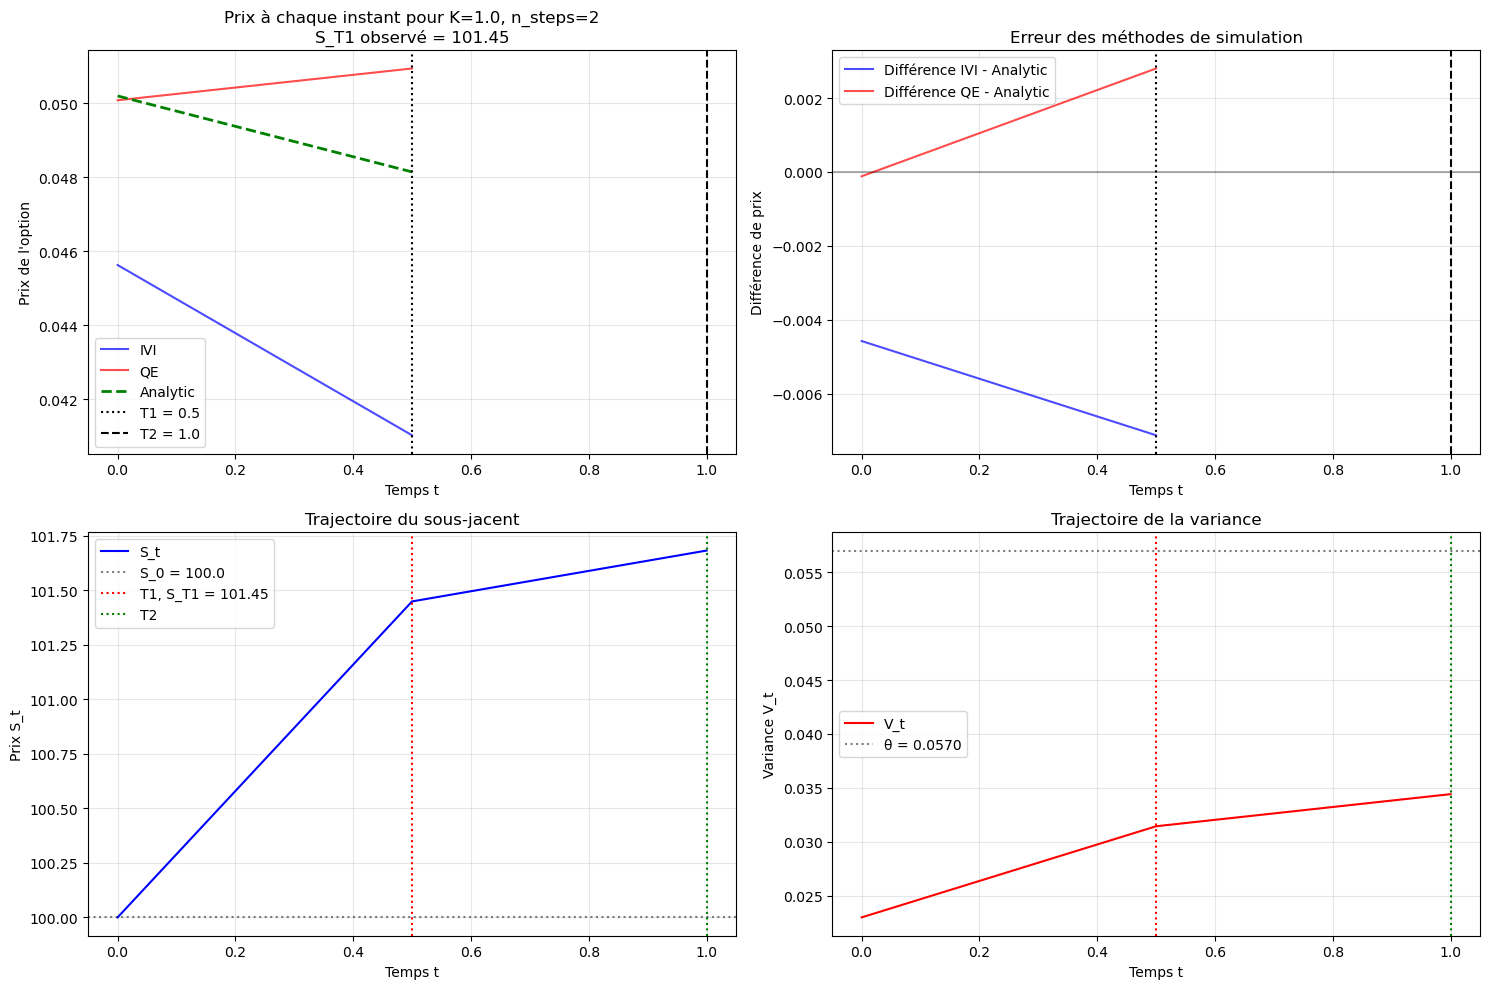


Analyse pour n_steps=2:
  Prix initial (t=0):
    IVI: 0.045627
    QE: 0.050086
    Analytic: 0.050203
  Prix à t=T1: (index 1)
    IVI: 0.041020
    QE: 0.050946
    Analytic: 0.048146
n_steps = 4
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.048637, QE: 0.051925, Analytic: 0.050203
  Calcul du prix à t = 0.250 (index 1)
    IVI: 0.045764, QE: 0.047926, Analytic: 0.047698
  Calcul du prix à t = 0.500 (index 2)
    IVI: 0.040488, QE: 0.045230, Analytic: 0.044443
  Calcul du prix à t = 0.750 (index 3)
    IVI: 0.116208, QE: 0.116528, Analytic: 0.116097


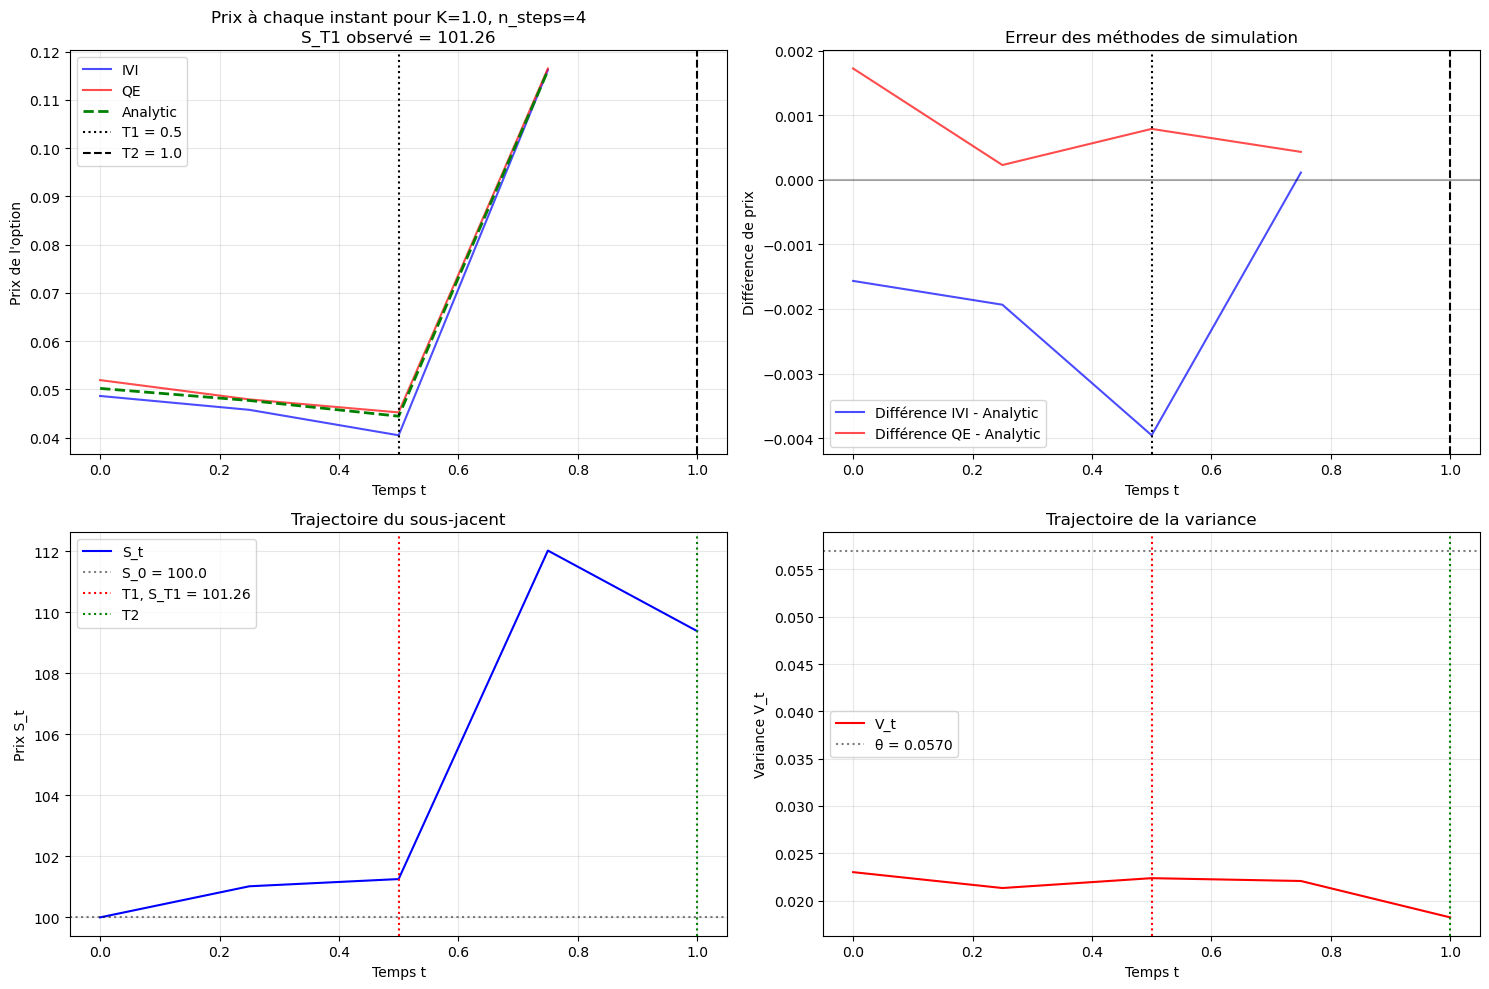


Analyse pour n_steps=4:
  Prix initial (t=0):
    IVI: 0.048637
    QE: 0.051925
    Analytic: 0.050203
  Prix à t=T1: (index 2)
    IVI: 0.040488
    QE: 0.045230
    Analytic: 0.044443
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.005276
    QE: -0.002696
    Analytic: -0.003255
n_steps = 6
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.048816, QE: 0.050717, Analytic: 0.050203
  Calcul du prix à t = 0.167 (index 1)
    IVI: 0.047547, QE: 0.048706, Analytic: 0.048092
  Calcul du prix à t = 0.333 (index 2)
    IVI: 0.044721, QE: 0.045936, Analytic: 0.045634
  Calcul du prix à t = 0.500 (index 3)
    IVI: 0.039595, QE: 0.043005, Analytic: 0.041983
  Calcul du prix à t = 0.667 (index 4)
    IVI: 0.017688, QE: 0.020664, Analytic: 0.020743
  Calcul du prix à t = 0.833 (index 5)
    IVI: 0.015743, QE: 0.019357, Analytic: 0.019213


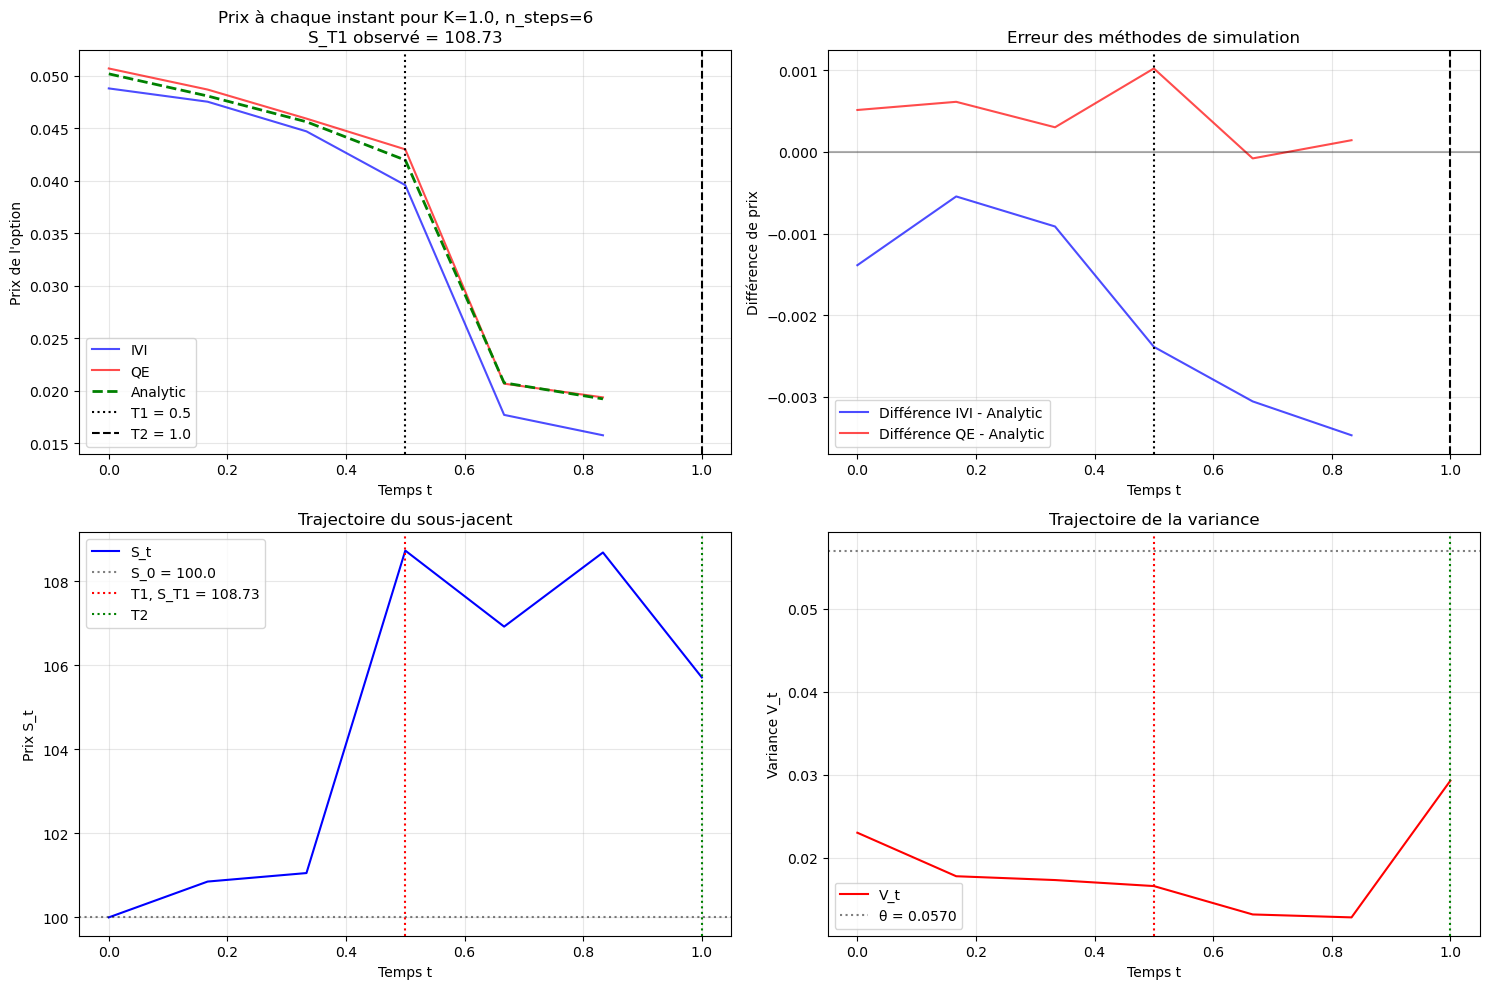


Analyse pour n_steps=6:
  Prix initial (t=0):
    IVI: 0.048816
    QE: 0.050717
    Analytic: 0.050203
  Prix à t=T1: (index 3)
    IVI: 0.039595
    QE: 0.043005
    Analytic: 0.041983
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.005125
    QE: -0.002931
    Analytic: -0.003651
n_steps = 8
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.049190, QE: 0.049490, Analytic: 0.050203
  Calcul du prix à t = 0.125 (index 1)
    IVI: 0.047486, QE: 0.047805, Analytic: 0.048332
  Calcul du prix à t = 0.250 (index 2)
    IVI: 0.045570, QE: 0.046343, Analytic: 0.046448
  Calcul du prix à t = 0.375 (index 3)
    IVI: 0.042396, QE: 0.044377, Analytic: 0.043853
  Calcul du prix à t = 0.500 (index 4)
    IVI: 0.038272, QE: 0.040379, Analytic: 0.039257
  Calcul du prix à t = 0.625 (index 5)
    IVI: 0.039179, QE: 0.041451, Analytic: 0.040407
  Calcul du prix à t = 0.750 (index 6)
    IVI: 0.023862, QE: 0.025399, Analytic: 0.024946
  Calcul du prix à t = 0.875 (index 7)
    IVI: 0.000205, QE: 0.

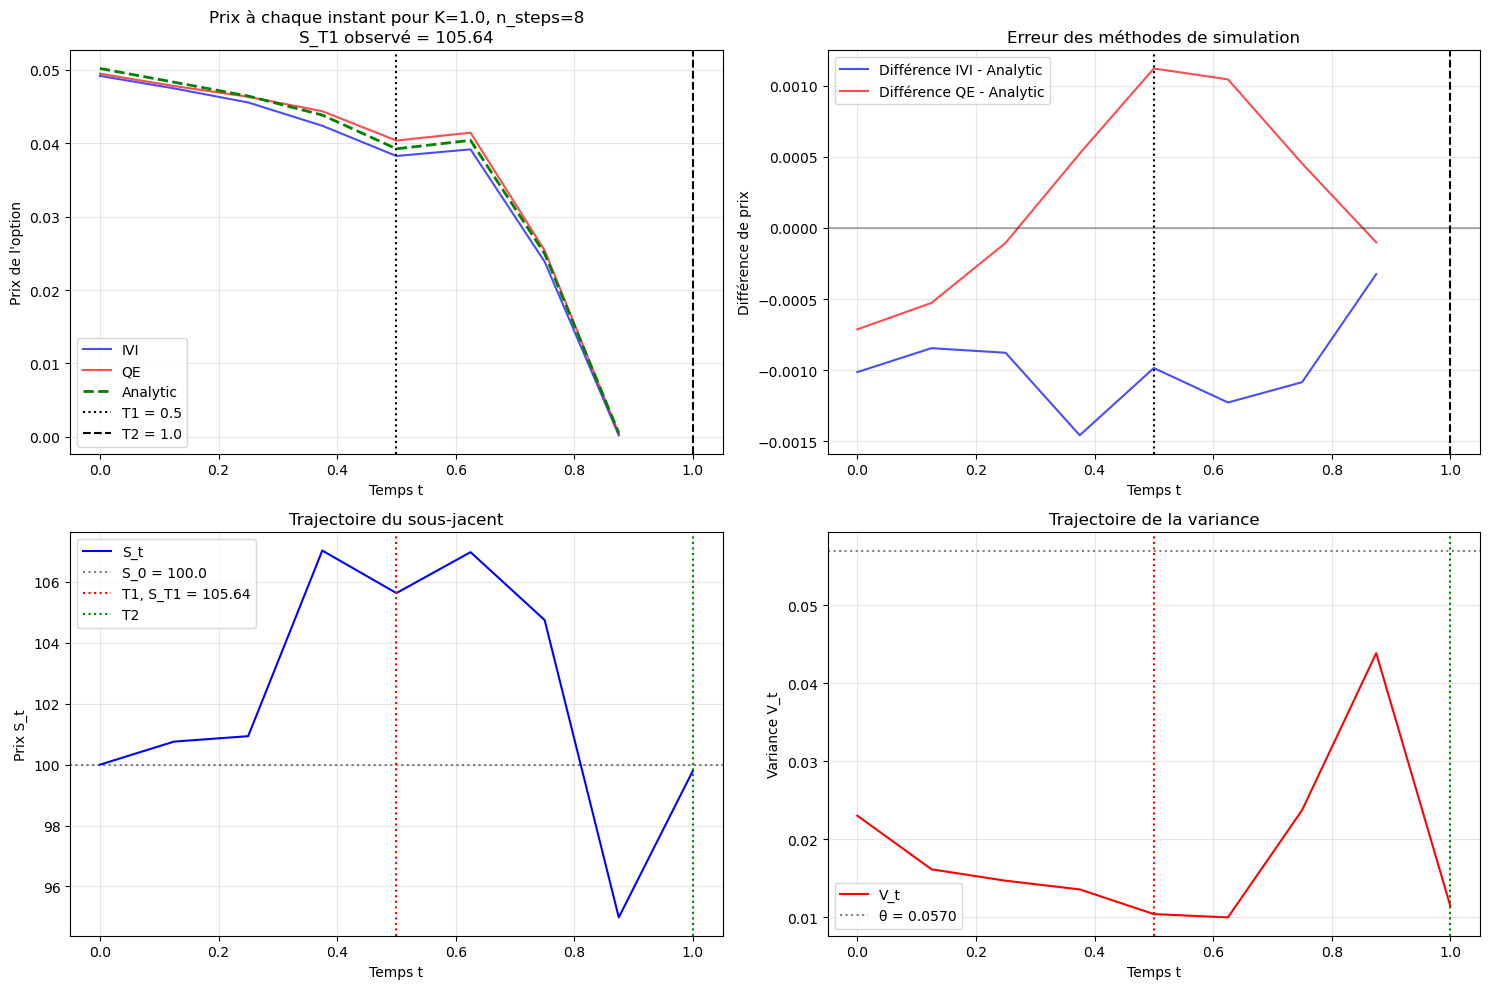


Analyse pour n_steps=8:
  Prix initial (t=0):
    IVI: 0.049190
    QE: 0.049490
    Analytic: 0.050203
  Prix à t=T1: (index 4)
    IVI: 0.038272
    QE: 0.040379
    Analytic: 0.039257
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.004123
    QE: -0.003998
    Analytic: -0.004596
n_steps = 16
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.049659, QE: 0.050250, Analytic: 0.050203
  Calcul du prix à t = 0.062 (index 1)
    IVI: 0.048652, QE: 0.049296, Analytic: 0.048782
  Calcul du prix à t = 0.125 (index 2)
    IVI: 0.047448, QE: 0.046844, Analytic: 0.047656
  Calcul du prix à t = 0.188 (index 3)
    IVI: 0.046288, QE: 0.047758, Analytic: 0.046446
  Calcul du prix à t = 0.250 (index 4)
    IVI: 0.043420, QE: 0.043710, Analytic: 0.044805
  Calcul du prix à t = 0.312 (index 5)
    IVI: 0.042145, QE: 0.042598, Analytic: 0.043277
  Calcul du prix à t = 0.375 (index 6)
    IVI: 0.042658, QE: 0.044426, Analytic: 0.043837
  Calcul du prix à t = 0.438 (index 7)
    IVI: 0.047554, QE: 0

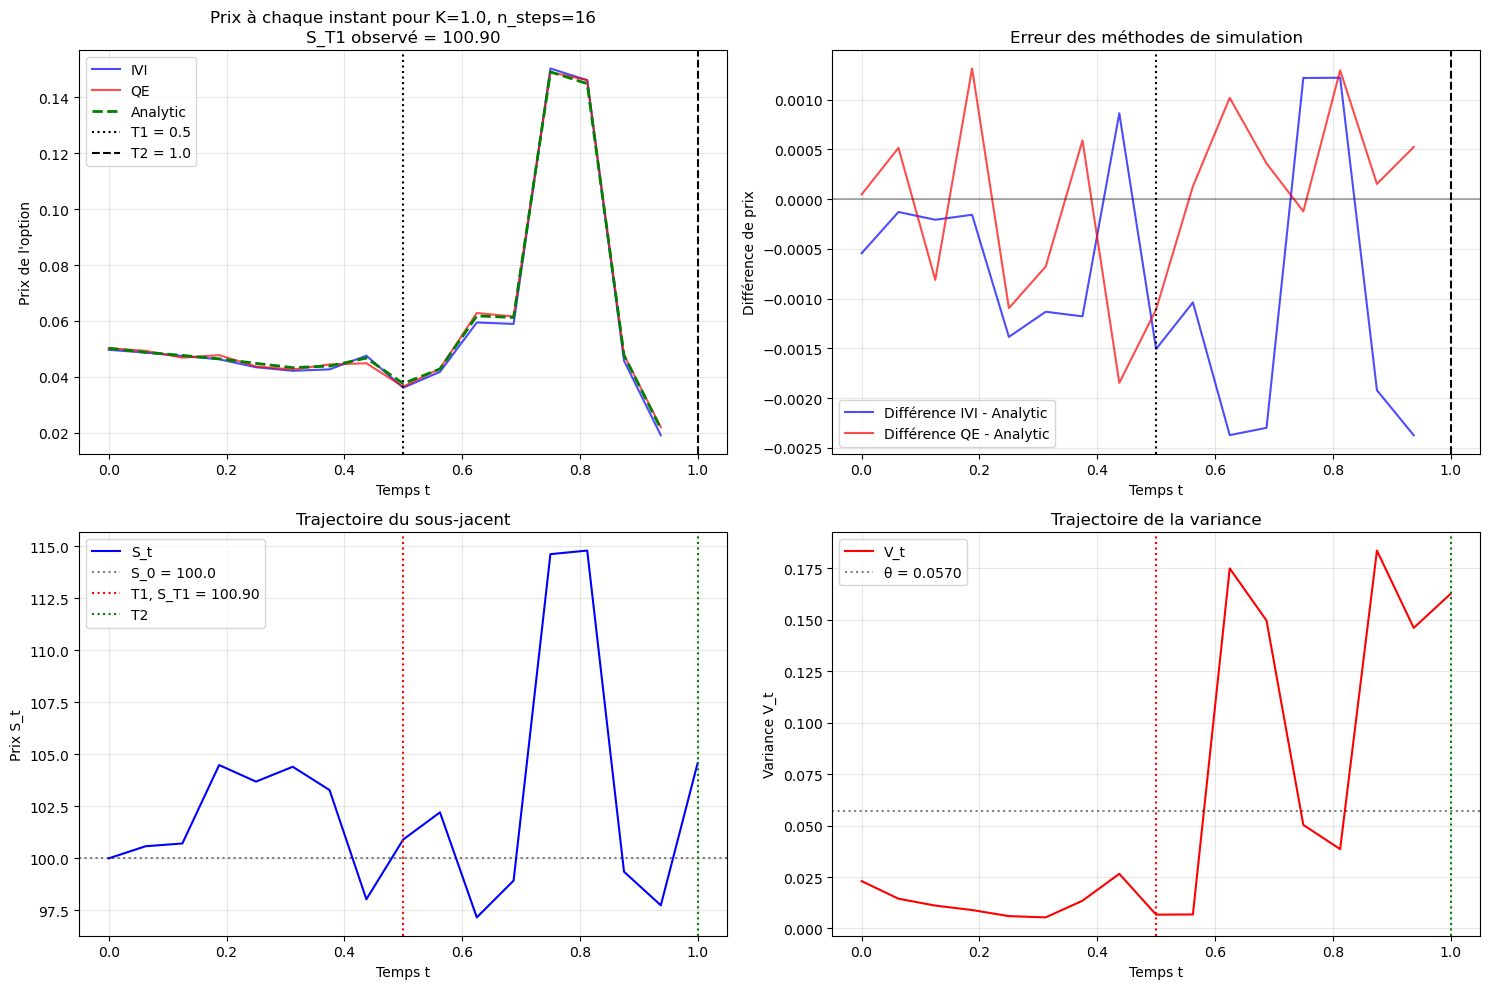


Analyse pour n_steps=16:
  Prix initial (t=0):
    IVI: 0.049659
    QE: 0.050250
    Analytic: 0.050203
  Prix à t=T1: (index 8)
    IVI: 0.036090
    QE: 0.036487
    Analytic: 0.037596
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.011465
    QE: -0.008360
    Analytic: -0.009097
n_steps = 26
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.050250, QE: 0.049488, Analytic: 0.050203
  Calcul du prix à t = 0.038 (index 1)
    IVI: 0.048209, QE: 0.049610, Analytic: 0.049025
  Calcul du prix à t = 0.077 (index 2)
    IVI: 0.048108, QE: 0.048061, Analytic: 0.048158
  Calcul du prix à t = 0.115 (index 3)
    IVI: 0.045973, QE: 0.044853, Analytic: 0.047318
  Calcul du prix à t = 0.154 (index 4)
    IVI: 0.045172, QE: 0.044716, Analytic: 0.046297
  Calcul du prix à t = 0.192 (index 5)
    IVI: 0.043367, QE: 0.046091, Analytic: 0.045496
  Calcul du prix à t = 0.231 (index 6)
    IVI: 0.045816, QE: 0.045782, Analytic: 0.045709
  Calcul du prix à t = 0.269 (index 7)
    IVI: 0.046927, QE: 

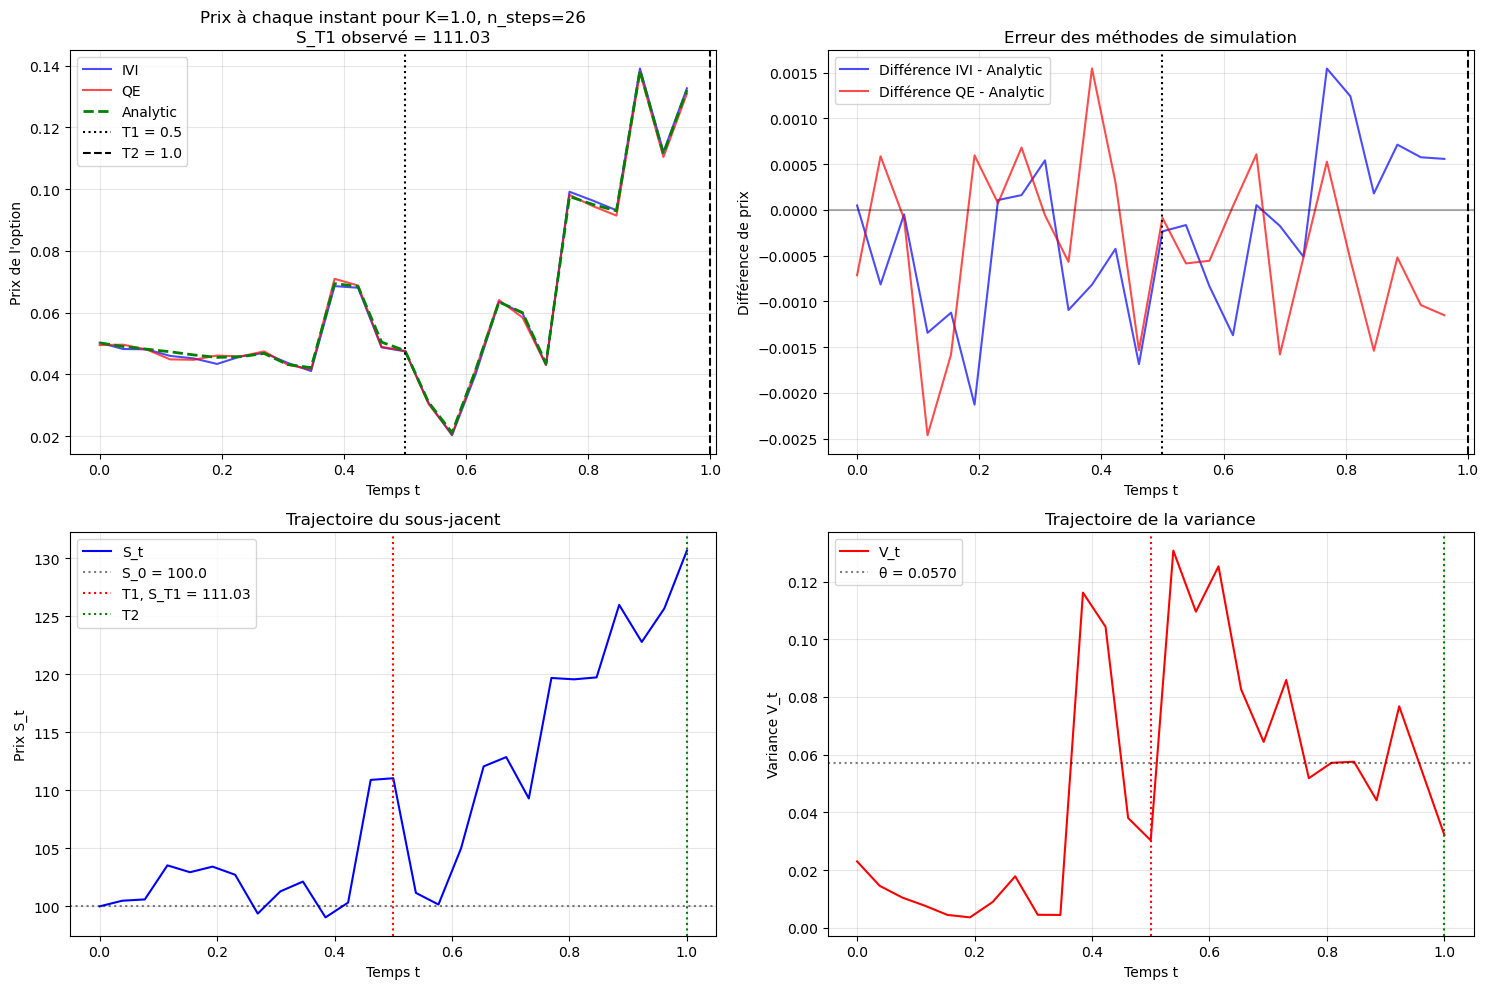


Analyse pour n_steps=26:
  Prix initial (t=0):
    IVI: 0.050250
    QE: 0.049488
    Analytic: 0.050203
  Prix à t=T1: (index 13)
    IVI: 0.047452
    QE: 0.047601
    Analytic: 0.047688
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.001301
    QE: -0.001303
    Analytic: -0.002752
n_steps = 36
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.050876, QE: 0.049463, Analytic: 0.050203
  Calcul du prix à t = 0.028 (index 1)
    IVI: 0.048813, QE: 0.049573, Analytic: 0.049165
  Calcul du prix à t = 0.056 (index 2)
    IVI: 0.048383, QE: 0.048229, Analytic: 0.048417
  Calcul du prix à t = 0.083 (index 3)
    IVI: 0.046660, QE: 0.046562, Analytic: 0.047716
  Calcul du prix à t = 0.111 (index 4)
    IVI: 0.046519, QE: 0.047381, Analytic: 0.046894
  Calcul du prix à t = 0.139 (index 5)
    IVI: 0.046755, QE: 0.047109, Analytic: 0.046312
  Calcul du prix à t = 0.167 (index 6)
    IVI: 0.046051, QE: 0.046325, Analytic: 0.046444
  Calcul du prix à t = 0.194 (index 7)
    IVI: 0.045695, QE:

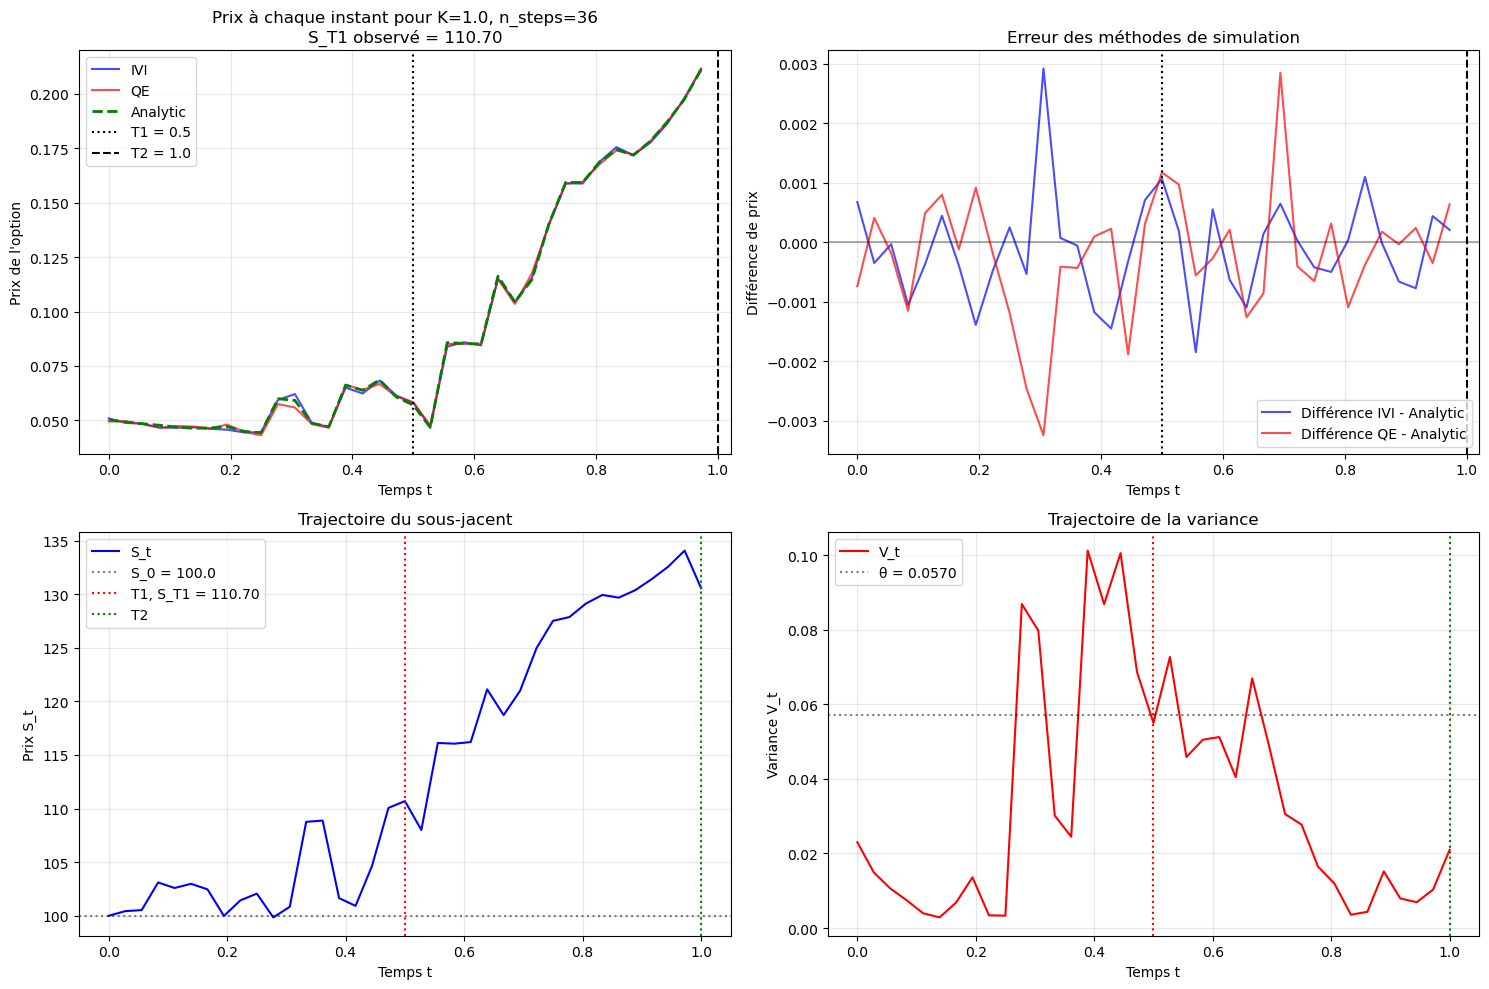


Analyse pour n_steps=36:
  Prix initial (t=0):
    IVI: 0.050876
    QE: 0.049463
    Analytic: 0.050203
  Prix à t=T1: (index 18)
    IVI: 0.058062
    QE: 0.058169
    Analytic: 0.056998
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.003278
    QE: -0.002772
    Analytic: -0.003634
n_steps = 50
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.051185, QE: 0.051766, Analytic: 0.050203
  Calcul du prix à t = 0.020 (index 1)
    IVI: 0.048585, QE: 0.050846, Analytic: 0.049292
  Calcul du prix à t = 0.040 (index 2)
    IVI: 0.047982, QE: 0.047400, Analytic: 0.048639
  Calcul du prix à t = 0.060 (index 3)
    IVI: 0.048398, QE: 0.046710, Analytic: 0.048033
  Calcul du prix à t = 0.080 (index 4)
    IVI: 0.046441, QE: 0.047449, Analytic: 0.047326
  Calcul du prix à t = 0.100 (index 5)
    IVI: 0.046620, QE: 0.046017, Analytic: 0.046862
  Calcul du prix à t = 0.120 (index 6)
    IVI: 0.047311, QE: 0.047603, Analytic: 0.046951
  Calcul du prix à t = 0.140 (index 7)
    IVI: 0.046288, QE:

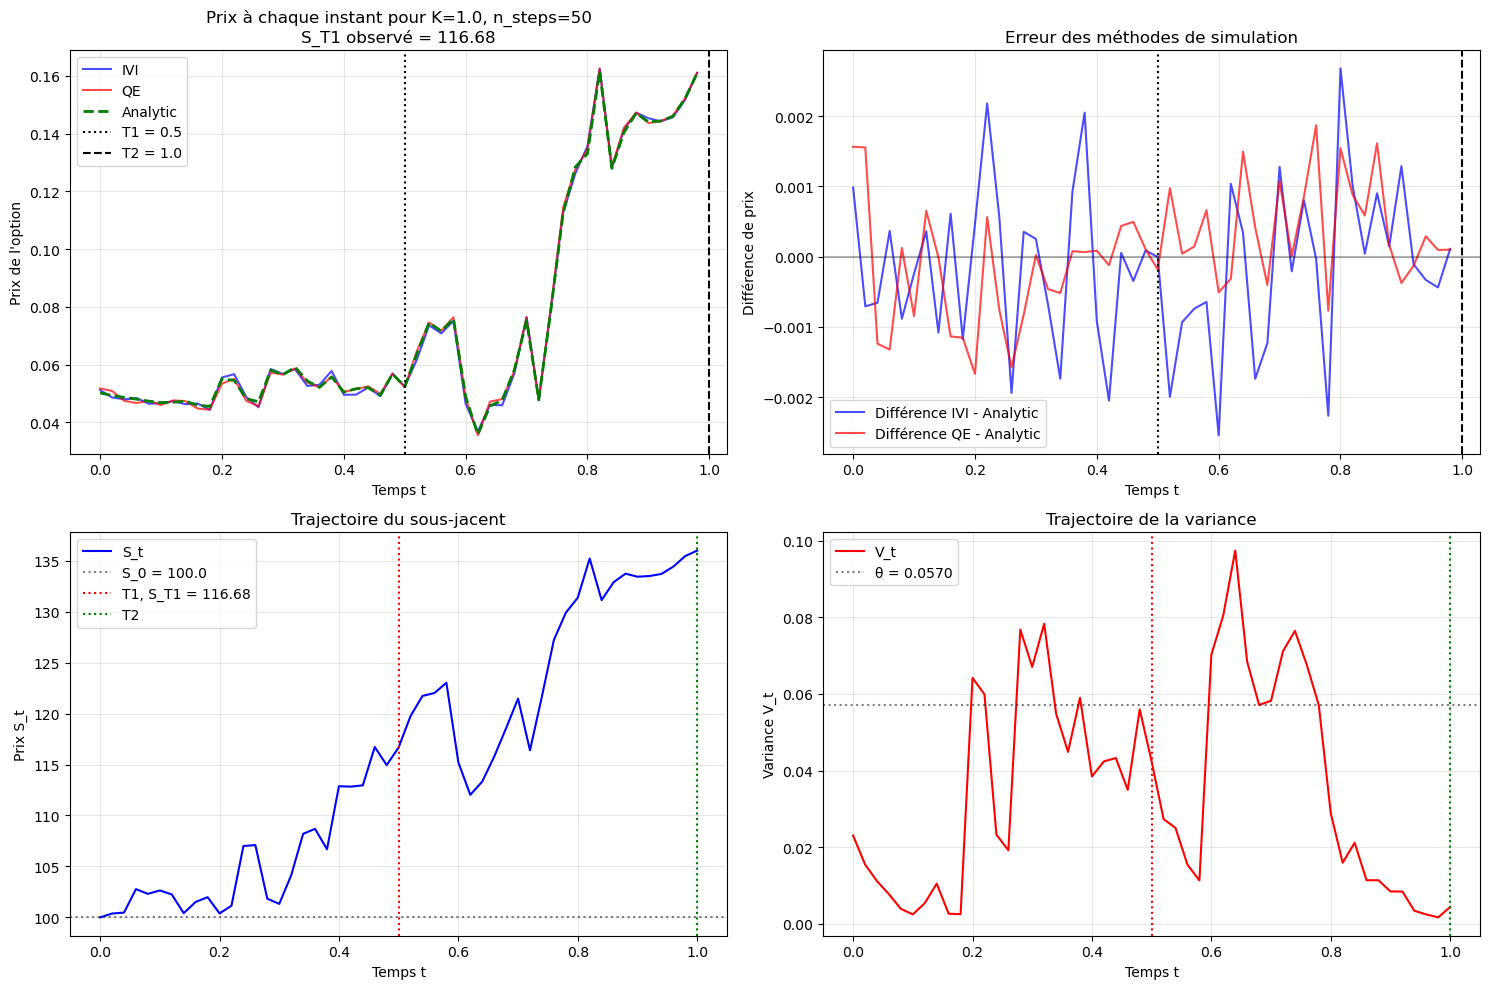


Analyse pour n_steps=50:
  Prix initial (t=0):
    IVI: 0.051185
    QE: 0.051766
    Analytic: 0.050203
  Prix à t=T1: (index 25)
    IVI: 0.052366
    QE: 0.052189
    Analytic: 0.052371
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.004501
    QE: -0.004698
    Analytic: -0.004409
n_steps = 66
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.050700, QE: 0.050836, Analytic: 0.050203
  Calcul du prix à t = 0.015 (index 1)
    IVI: 0.050920, QE: 0.050339, Analytic: 0.049389
  Calcul du prix à t = 0.030 (index 2)
    IVI: 0.047033, QE: 0.047633, Analytic: 0.048804
  Calcul du prix à t = 0.045 (index 3)
    IVI: 0.048301, QE: 0.048945, Analytic: 0.048260
  Calcul du prix à t = 0.061 (index 4)
    IVI: 0.047990, QE: 0.047581, Analytic: 0.047612
  Calcul du prix à t = 0.076 (index 5)
    IVI: 0.045518, QE: 0.047047, Analytic: 0.047200
  Calcul du prix à t = 0.091 (index 6)
    IVI: 0.047335, QE: 0.047182, Analytic: 0.047267
  Calcul du prix à t = 0.106 (index 7)
    IVI: 0.048489, QE:

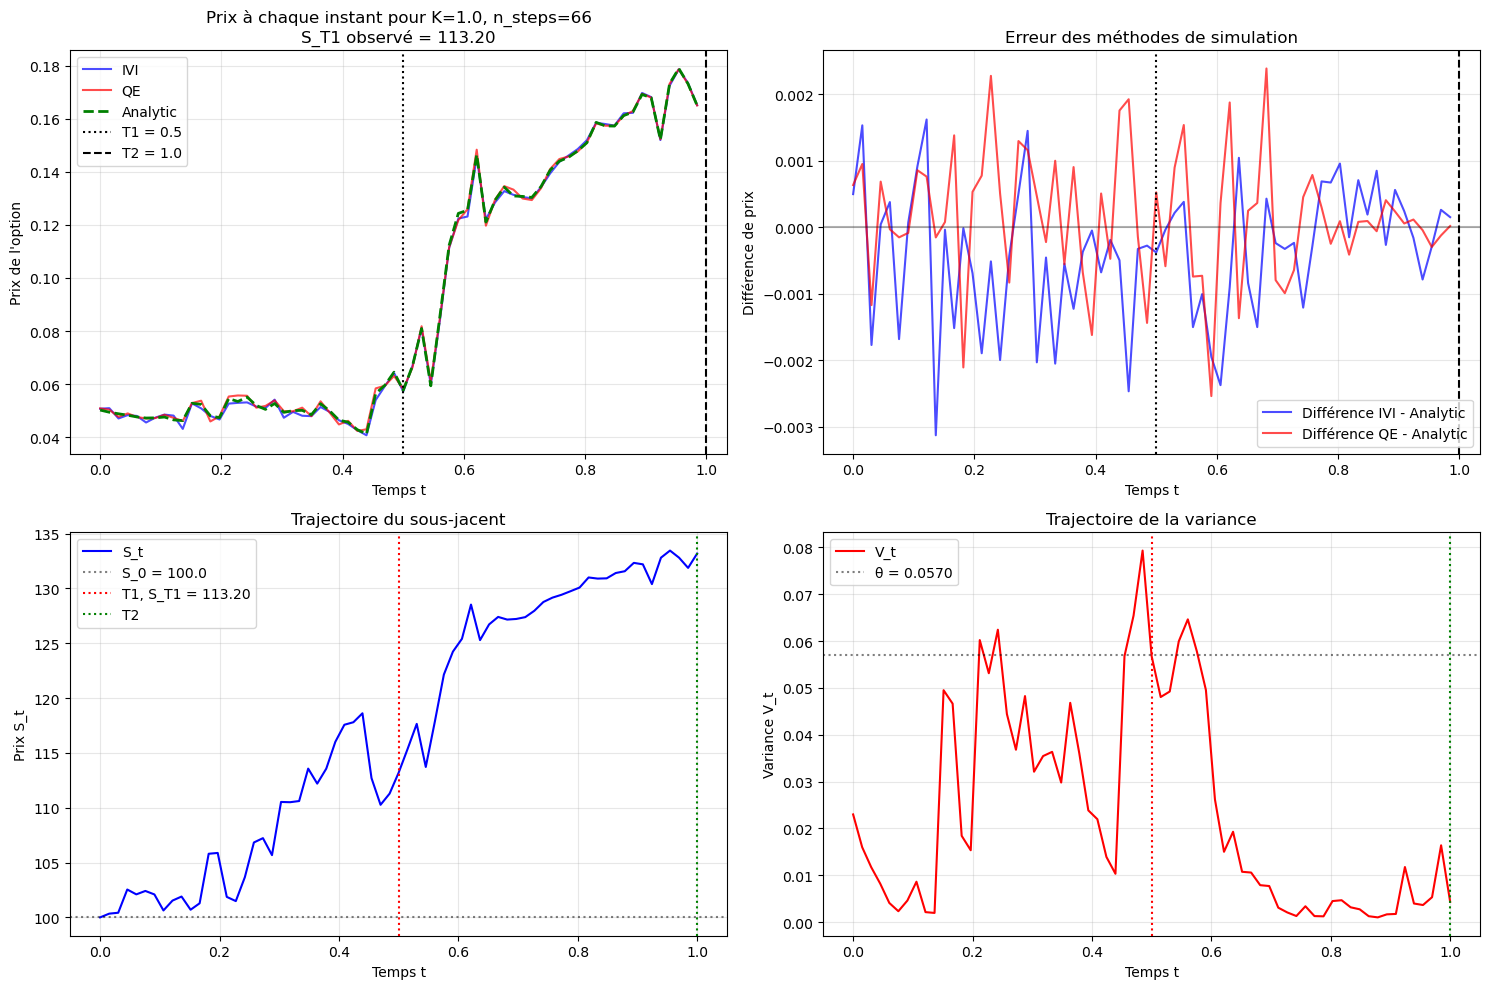


Analyse pour n_steps=66:
  Prix initial (t=0):
    IVI: 0.050700
    QE: 0.050836
    Analytic: 0.050203
  Prix à t=T1: (index 33)
    IVI: 0.057252
    QE: 0.058156
    Analytic: 0.057631
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.006965
    QE: -0.004900
    Analytic: -0.006862
n_steps = 80
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.051073, QE: 0.049217, Analytic: 0.050203
  Calcul du prix à t = 0.013 (index 1)
    IVI: 0.049336, QE: 0.050749, Analytic: 0.049451
  Calcul du prix à t = 0.025 (index 2)
    IVI: 0.049479, QE: 0.047741, Analytic: 0.048908
  Calcul du prix à t = 0.038 (index 3)
    IVI: 0.049159, QE: 0.049697, Analytic: 0.048400
  Calcul du prix à t = 0.050 (index 4)
    IVI: 0.048571, QE: 0.047672, Analytic: 0.047783
  Calcul du prix à t = 0.062 (index 5)
    IVI: 0.048570, QE: 0.047599, Analytic: 0.047390
  Calcul du prix à t = 0.075 (index 6)
    IVI: 0.047454, QE: 0.047765, Analytic: 0.047448
  Calcul du prix à t = 0.088 (index 7)
    IVI: 0.046688, QE:

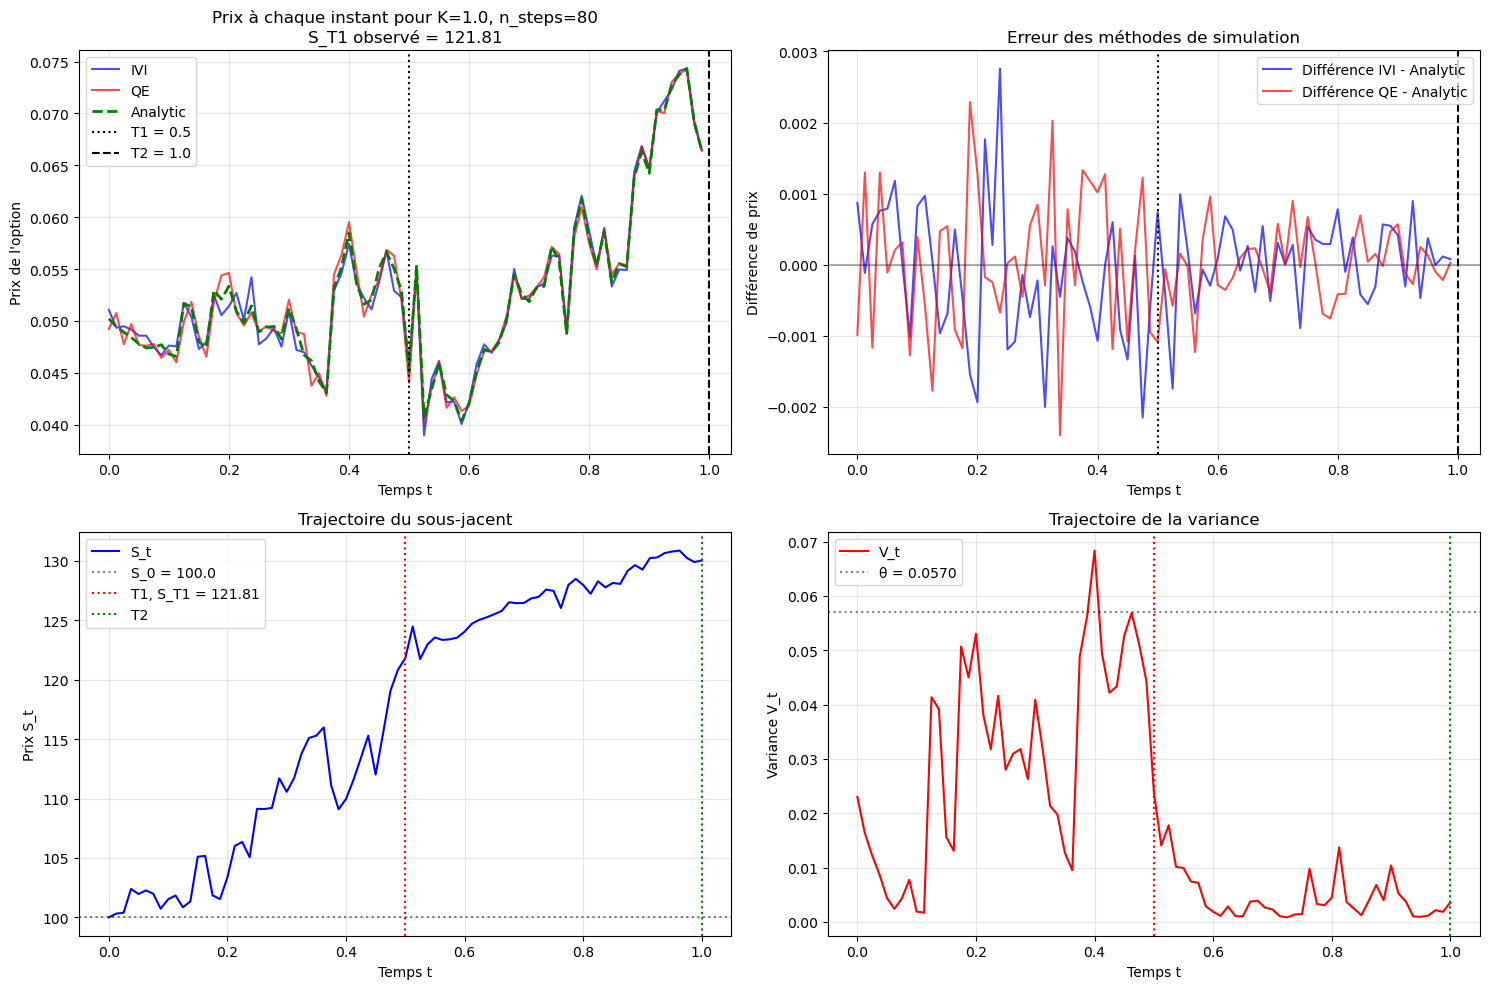


Analyse pour n_steps=80:
  Prix initial (t=0):
    IVI: 0.051073
    QE: 0.049217
    Analytic: 0.050203
  Prix à t=T1: (index 40)
    IVI: 0.045847
    QE: 0.044021
    Analytic: 0.045107
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.006420
    QE: -0.007902
    Analytic: -0.007766


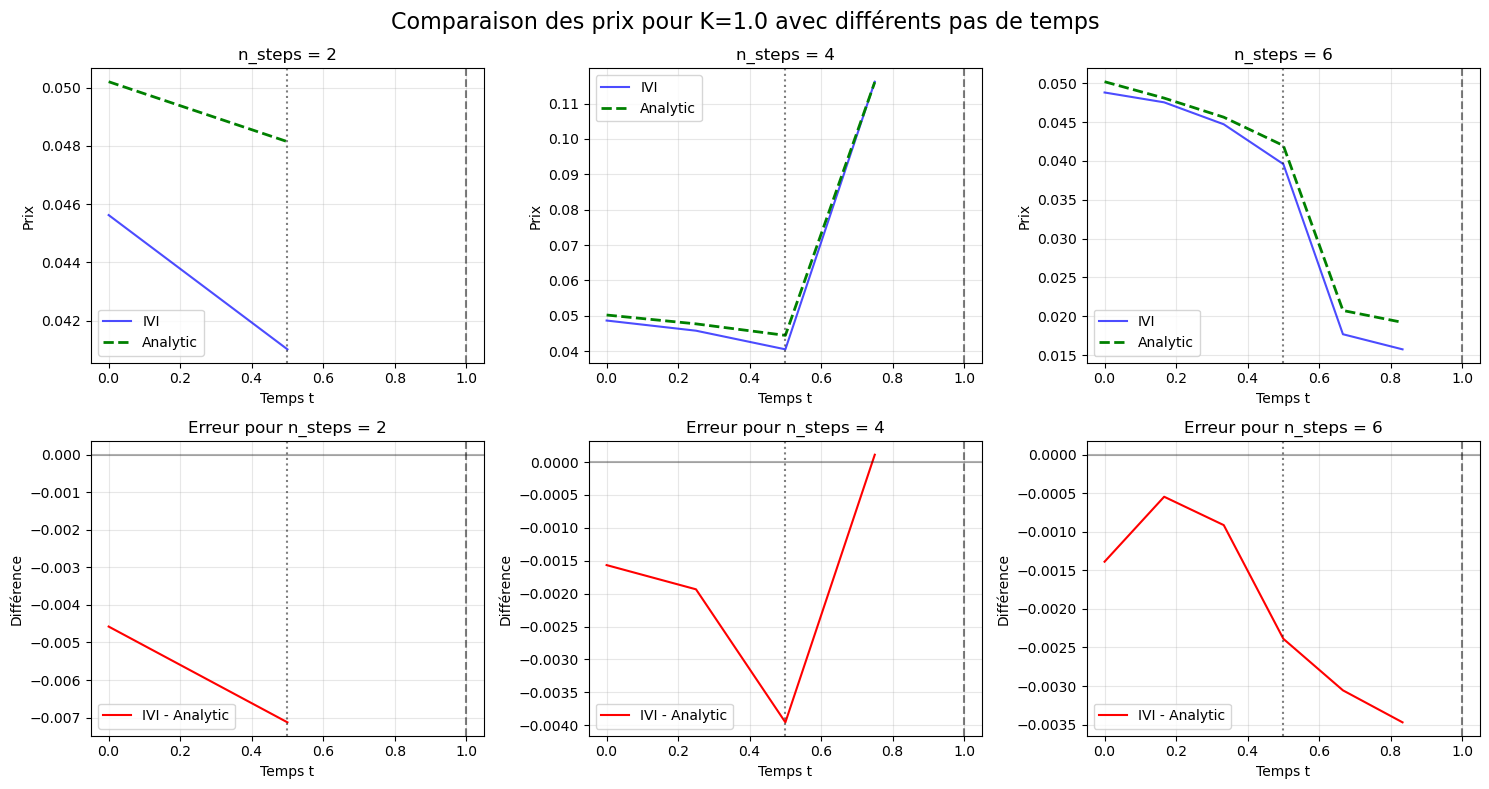


RÉCAPITULATIF DES RÉSULTATS

Paramètres du modèle:
  S_0 = 100.0
  V_0 = 0.023
  K = 1.0
  T1 = 0.5, T2 = 1.0
  kappa = 2.1500, theta = 0.0570, sigma = 0.8600, rho = -0.7000

Comparaison des méthodes (prix initial à t=0):
 n_steps          IVI           QE     Analytic     Diff IVI      Diff QE
       2     0.045627     0.050086     0.050203    -0.004576    -0.000118
       4     0.048637     0.051925     0.050203    -0.001566     0.001722
       6     0.048816     0.050717     0.050203    -0.001387     0.000514
       8     0.049190     0.049490     0.050203    -0.001014    -0.000713
      16     0.049659     0.050250     0.050203    -0.000544     0.000047
      26     0.050250     0.049488     0.050203     0.000047    -0.000715
      36     0.050876     0.049463     0.050203     0.000673    -0.000740
      50     0.051185     0.051766     0.050203     0.000981     0.001563
      66     0.050700     0.050836     0.050203     0.000497     0.000633
      80     0.051073     0.049217   

In [ ]:
# FIXER K
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[1]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K = 1.0  # Strike fixé
r = 0

# Liste pour stocker les résultats par n_steps
results_by_nsteps = {}

for n_steps in N_steps:
    print(f"n_steps = {n_steps}")
    
    # Indices temporels
    T1_idx = int(n_steps/2)
    T2_idx = n_steps
    
    # On génère UNE trajectoire de référence
    t_vec, V_paths, U_paths, Z_paths, S_paths = simulate_paths(
        a, b, c, rho, V_0, T2, n_steps, n_paths=1, S_0=S_0
    )
    
    # Valeur de S_T1 observée sur cette trajectoire
    S_T1 = S_paths[T1_idx, 0]
    
    # Initialisation des listes pour chaque instant
    times = []
    ivi_prices_at_t = []
    QE_prices_at_t = []
    analytic_prices_at_t = []
    
    # On calcule le prix à CHAQUE instant (sauf le dernier)
    for i in range(len(t_vec)):
        t_i = t_vec[i]
        
        # On ne peut pas calculer le prix à T2 (payoff connu)
        if i == T2_idx:
            continue
            
        print(f"  Calcul du prix à t = {t_i:.3f} (index {i})")
        
        # Valeurs à l'instant t_i
        S_ti = S_paths[i, 0]
        V_ti = V_paths[i, 0]
        
       
        # DÉTERMINER SI ON EST AVANT OU APRÈS T1
      
        if i <= T1_idx:
            # AVANT T1: S_T1 est encore inconnu
            # Pour les simulations, on doit simuler jusqu'à T1 ET jusqu'à T2
            
            # 1. SIMULATION IVI
            _, _, _, _, S_curr = simulate_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,  # Réduit pour performance
                S_idx=S_ti,
                U_idx=U_paths[i, 0], 
                Z_idx=Z_paths[i, 0]
            )
            
            # À t < T1, on doit extraire S_T1 et S_T2
            relative_T1_idx = T1_idx - i
            S_T1_sim = S_curr[relative_T1_idx, :]  # S_T1 simulé
            S_T2_sim = S_curr[-1, :]  # S_T2
            
            payoff_ivi = np.maximum(S_T2_sim / S_T1_sim - K, 0)
            price_ivi = np.mean(payoff_ivi)
            
            # 2. SIMULATION QE
            S_curr_qe, _, _ = simulate_QE_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0]
            )
            
            S_T1_sim_qe = S_curr_qe[relative_T1_idx, :]
            S_T2_sim_qe = S_curr_qe[-1, :]
            
            payoff_qe = np.maximum(S_T2_sim_qe / S_T1_sim_qe - K, 0)
            price_qe = np.mean(payoff_qe)
            
            # 3. FORMULE ANALYTIQUE (t < T1)
            # Pour t < T1, on utilise char_func_t_t1 qui nécessite v0
            price_analytic = conditional_expectation(
                t=t_i, 
                T1=T1, 
                T2=T2, 
                K=K, 
                v_t=V_ti, 
                s_t=S_ti,
                s_T1=S_T1,  # Cette valeur ne sera pas utilisée pour t < T1 dans char_func_t_t1
                kappa=kappa, 
                theta=theta, 
                sigma=sigma, 
                rho=rho, 
                r=r,
                v0=V_0  # Nécessaire pour t < T1
            )
            
        else:
            # APRÈS T1: S_T1 est connu
            # 1. SIMULATION IVI
            _, _, _, _, S_curr = simulate_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0], 
                Z_idx=Z_paths[i, 0]
            )
            
            # À t >= T1, S_T1 est fixé (celui de la trajectoire de référence)
            S_T1_fixed = S_T1 * np.ones(5000)
            S_T2_sim = S_curr[-1, :]
            
            payoff_ivi = np.maximum(S_T2_sim / S_T1_fixed - K, 0)
            price_ivi = np.mean(payoff_ivi)
            
            # 2. SIMULATION QE
            S_curr_qe, _, _ = simulate_QE_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0]
            )
            
            S_T1_fixed_qe = S_T1 * np.ones(5000)
            S_T2_sim_qe = S_curr_qe[-1, :]
            
            payoff_qe = np.maximum(S_T2_sim_qe / S_T1_fixed_qe - K, 0)
            price_qe = np.mean(payoff_qe)
            
            # 3. FORMULE ANALYTIQUE (t >= T1)
            price_analytic = conditional_expectation(
                t=t_i, 
                T1=T1, 
                T2=T2, 
                K=K, 
                v_t=V_ti, 
                s_t=S_ti,
                s_T1=S_T1,  # S_T1 connu
                kappa=kappa, 
                theta=theta, 
                sigma=sigma, 
                rho=rho, 
                r=r
                # v0 pas nécessaire pour t >= T1
            )
        
        # Stocker les résultats
        times.append(t_i)
        ivi_prices_at_t.append(price_ivi)
        QE_prices_at_t.append(price_qe)
        analytic_prices_at_t.append(price_analytic)
        
        print(f"    IVI: {price_ivi:.6f}, QE: {price_qe:.6f}, Analytic: {price_analytic:.6f}")
    
    # Stocker les résultats pour ce n_steps
    results_by_nsteps[n_steps] = {
        'times': times,
        'ivi_prices': ivi_prices_at_t,
        'qe_prices': QE_prices_at_t,
        'analytic_prices': analytic_prices_at_t,
        'S_path': S_paths[:, 0],
        'V_path': V_paths[:, 0],
        't_vec': t_vec,
        'S_T1': S_T1
    }
    
    
    # VISUALISATION POUR CE n_steps
  
    plt.figure(figsize=(15, 10))
    
    # Sous-figure 1: Prix à chaque instant
    plt.subplot(2, 2, 1)
    plt.plot(times, ivi_prices_at_t, 'b-', label='IVI', alpha=0.7)
    plt.plot(times, QE_prices_at_t, 'r-', label='QE', alpha=0.7)
    plt.plot(times, analytic_prices_at_t, 'g--', label='Analytic', linewidth=2)
    
    # Marquer T1 et T2
    plt.axvline(x=T1, color='k', linestyle=':', label=f'T1 = {T1}')
    plt.axvline(x=T2, color='k', linestyle='--', label=f'T2 = {T2}')
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix de l\'option')
    plt.title(f'Prix à chaque instant pour K={K}, n_steps={n_steps}\nS_T1 observé = {S_T1:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 2: Différences par rapport à la formule analytique
    plt.subplot(2, 2, 2)
    diff_ivi = np.array(ivi_prices_at_t) - np.array(analytic_prices_at_t)
    diff_qe = np.array(QE_prices_at_t) - np.array(analytic_prices_at_t)
    
    plt.plot(times, diff_ivi, 'b-', label='Différence IVI - Analytic', alpha=0.7)
    plt.plot(times, diff_qe, 'r-', label='Différence QE - Analytic', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=T1, color='k', linestyle=':')
    plt.axvline(x=T2, color='k', linestyle='--')
    
    plt.xlabel('Temps t')
    plt.ylabel('Différence de prix')
    plt.title('Erreur des méthodes de simulation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 3: Trajectoire du sous-jacent
    plt.subplot(2, 2, 3)
    plt.plot(t_vec, S_paths[:, 0], 'b-', label='S_t')
    plt.axhline(y=S_0, color='k', linestyle=':', alpha=0.5, label=f'S_0 = {S_0}')
    plt.axvline(x=T1, color='r', linestyle=':', label=f'T1, S_T1 = {S_T1:.2f}')
    plt.axvline(x=T2, color='g', linestyle=':', label=f'T2')
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix S_t')
    plt.title('Trajectoire du sous-jacent')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 4: Trajectoire de la variance
    plt.subplot(2, 2, 4)
    plt.plot(t_vec, V_paths[:, 0], 'r-', label='V_t')
    plt.axhline(y=theta, color='k', linestyle=':', alpha=0.5, label=f'θ = {theta:.4f}')
    plt.axvline(x=T1, color='r', linestyle=':')
    plt.axvline(x=T2, color='g', linestyle=':')
    
    plt.xlabel('Temps t')
    plt.ylabel('Variance V_t')
    plt.title('Trajectoire de la variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
   
    # ANALYSE DES RÉSULTATS
   
    print(f"\nAnalyse pour n_steps={n_steps}:")
    print(f"  Prix initial (t=0):")
    print(f"    IVI: {ivi_prices_at_t[0]:.6f}")
    print(f"    QE: {QE_prices_at_t[0]:.6f}")
    print(f"    Analytic: {analytic_prices_at_t[0]:.6f}")
    
    print(f"  Prix à t=T1: (index {T1_idx})")
    print(f"    IVI: {ivi_prices_at_t[T1_idx]:.6f}")
    print(f"    QE: {QE_prices_at_t[T1_idx]:.6f}")
    print(f"    Analytic: {analytic_prices_at_t[T1_idx]:.6f}")
    
    # Vérifier la continuité à T1
    if T1_idx > 0 and T1_idx < len(times)-1:
        jump_ivi = ivi_prices_at_t[T1_idx] - ivi_prices_at_t[T1_idx-1]
        jump_qe = QE_prices_at_t[T1_idx] - QE_prices_at_t[T1_idx-1]
        jump_analytic = analytic_prices_at_t[T1_idx] - analytic_prices_at_t[T1_idx-1]
        
        print(f"  Saut à T1 (prix(T1) - prix(T1-dt)):")
        print(f"    IVI: {jump_ivi:.6f}")
        print(f"    QE: {jump_qe:.6f}")
        print(f"    Analytic: {jump_analytic:.6f}")


# VISUALISATION COMPARATIVE POUR DIFFÉRENTS n_steps

plt.figure(figsize=(15, 8))

for idx, n_steps in enumerate(list(results_by_nsteps.keys())[:3]):  # Limiter à 3 n_steps pour lisibilité
    results = results_by_nsteps[n_steps]
    
    plt.subplot(2, 3, idx+1)
    plt.plot(results['times'], results['ivi_prices'], 'b-', label='IVI', alpha=0.7)
    plt.plot(results['times'], results['analytic_prices'], 'g--', label='Analytic', linewidth=2)
    plt.axvline(x=T1, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=T2, color='k', linestyle='--', alpha=0.5)
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix')
    plt.title(f'n_steps = {n_steps}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, idx+4)
    diff = np.array(results['ivi_prices']) - np.array(results['analytic_prices'])
    plt.plot(results['times'], diff, 'r-', label='IVI - Analytic')
    plt.axvline(x=T1, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=T2, color='k', linestyle='--', alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    plt.xlabel('Temps t')
    plt.ylabel('Différence')
    plt.title(f'Erreur pour n_steps = {n_steps}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle(f'Comparaison des prix pour K={K} avec différents pas de temps', fontsize=16)
plt.tight_layout()
plt.show()

# ============================================
# TABLEAU RÉCAPITULATIF
# ============================================
print("\n" + "="*80)
print("RÉCAPITULATIF DES RÉSULTATS")
print("="*80)

print(f"\nParamètres du modèle:")
print(f"  S_0 = {S_0}")
print(f"  V_0 = {V_0}")
print(f"  K = {K}")
print(f"  T1 = {T1}, T2 = {T2}")
print(f"  kappa = {kappa:.4f}, theta = {theta:.4f}, sigma = {sigma:.4f}, rho = {rho:.4f}")

print(f"\nComparaison des méthodes (prix initial à t=0):")
print(f"{'n_steps':>8} {'IVI':>12} {'QE':>12} {'Analytic':>12} {'Diff IVI':>12} {'Diff QE':>12}")

for n_steps in results_by_nsteps:
    results = results_by_nsteps[n_steps]
    price_ivi_0 = results['ivi_prices'][0]
    price_qe_0 = results['qe_prices'][0]
    price_analytic_0 = results['analytic_prices'][0]
    
    diff_ivi = price_ivi_0 - price_analytic_0
    diff_qe = price_qe_0 - price_analytic_0
    
    print(f"{n_steps:>8} {price_ivi_0:>12.6f} {price_qe_0:>12.6f} {price_analytic_0:>12.6f} {diff_ivi:>12.6f} {diff_qe:>12.6f}")

## Case 3

n_steps = 2
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.072418, QE: 0.084283, Analytic: 0.080308
  Calcul du prix à t = 5.000 (index 1)
    IVI: 0.069662, QE: 0.075277, Analytic: 0.083733


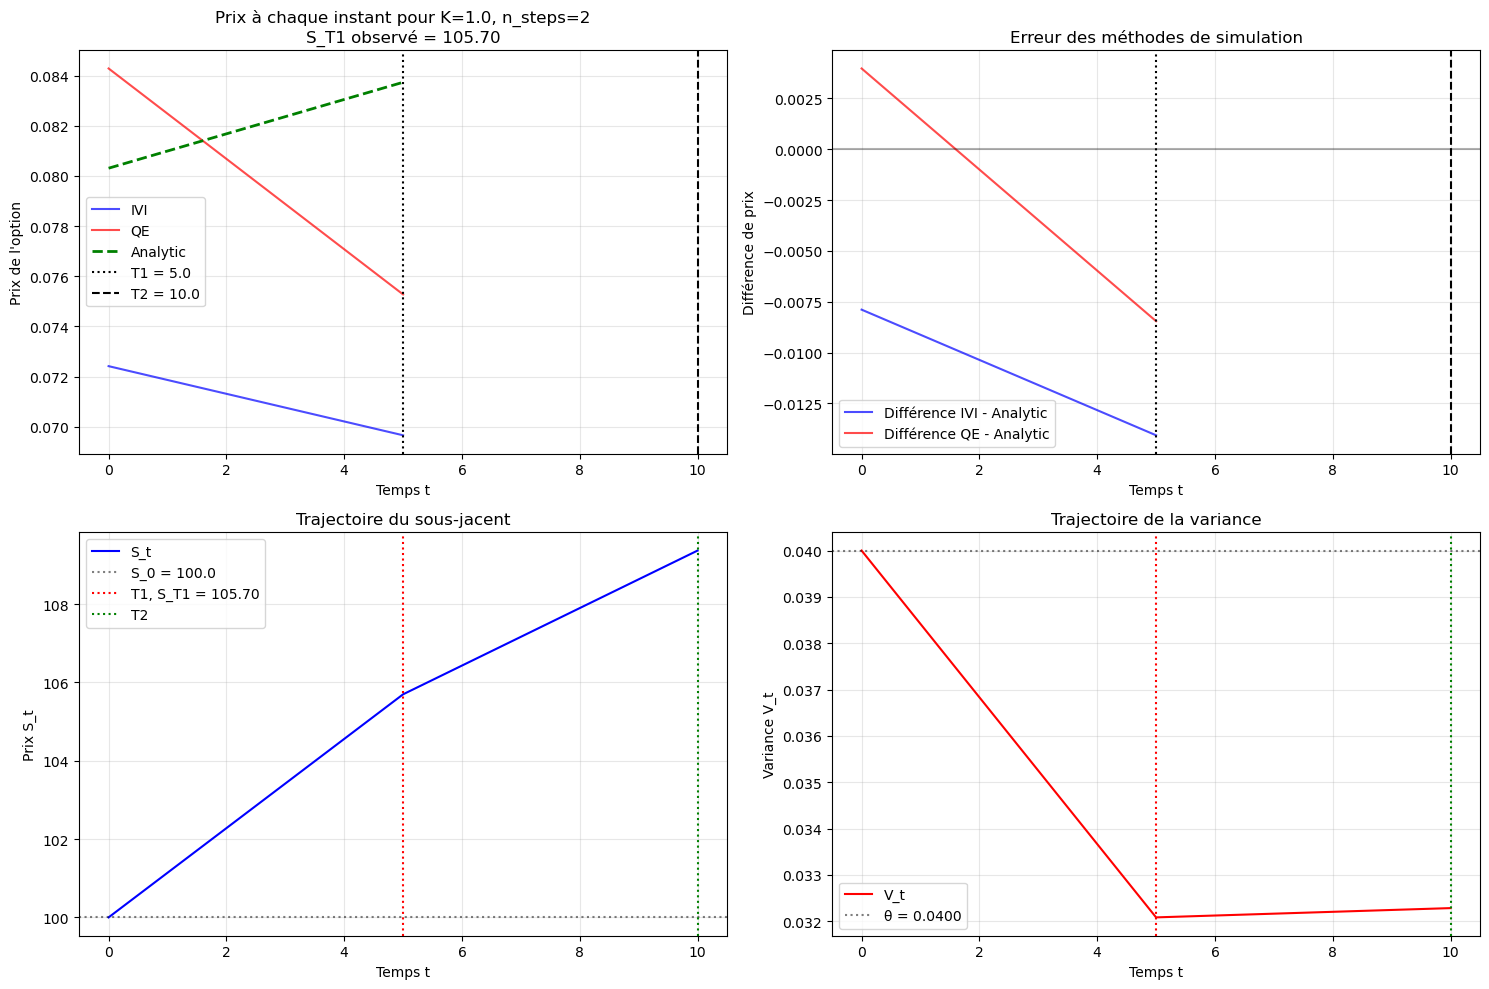


Analyse pour n_steps=2:
  Prix initial (t=0):
    IVI: 0.072418
    QE: 0.084283
    Analytic: 0.080308
  Prix à t=T1: (index 1)
    IVI: 0.069662
    QE: 0.075277
    Analytic: 0.083733
n_steps = 4
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.077718, QE: 0.083485, Analytic: 0.080308
  Calcul du prix à t = 2.500 (index 1)
    IVI: 0.075883, QE: 0.083264, Analytic: 0.079090
  Calcul du prix à t = 5.000 (index 2)
    IVI: 0.068458, QE: 0.082802, Analytic: 0.078495
  Calcul du prix à t = 7.500 (index 3)
    IVI: 0.153913, QE: 0.162662, Analytic: 0.162309


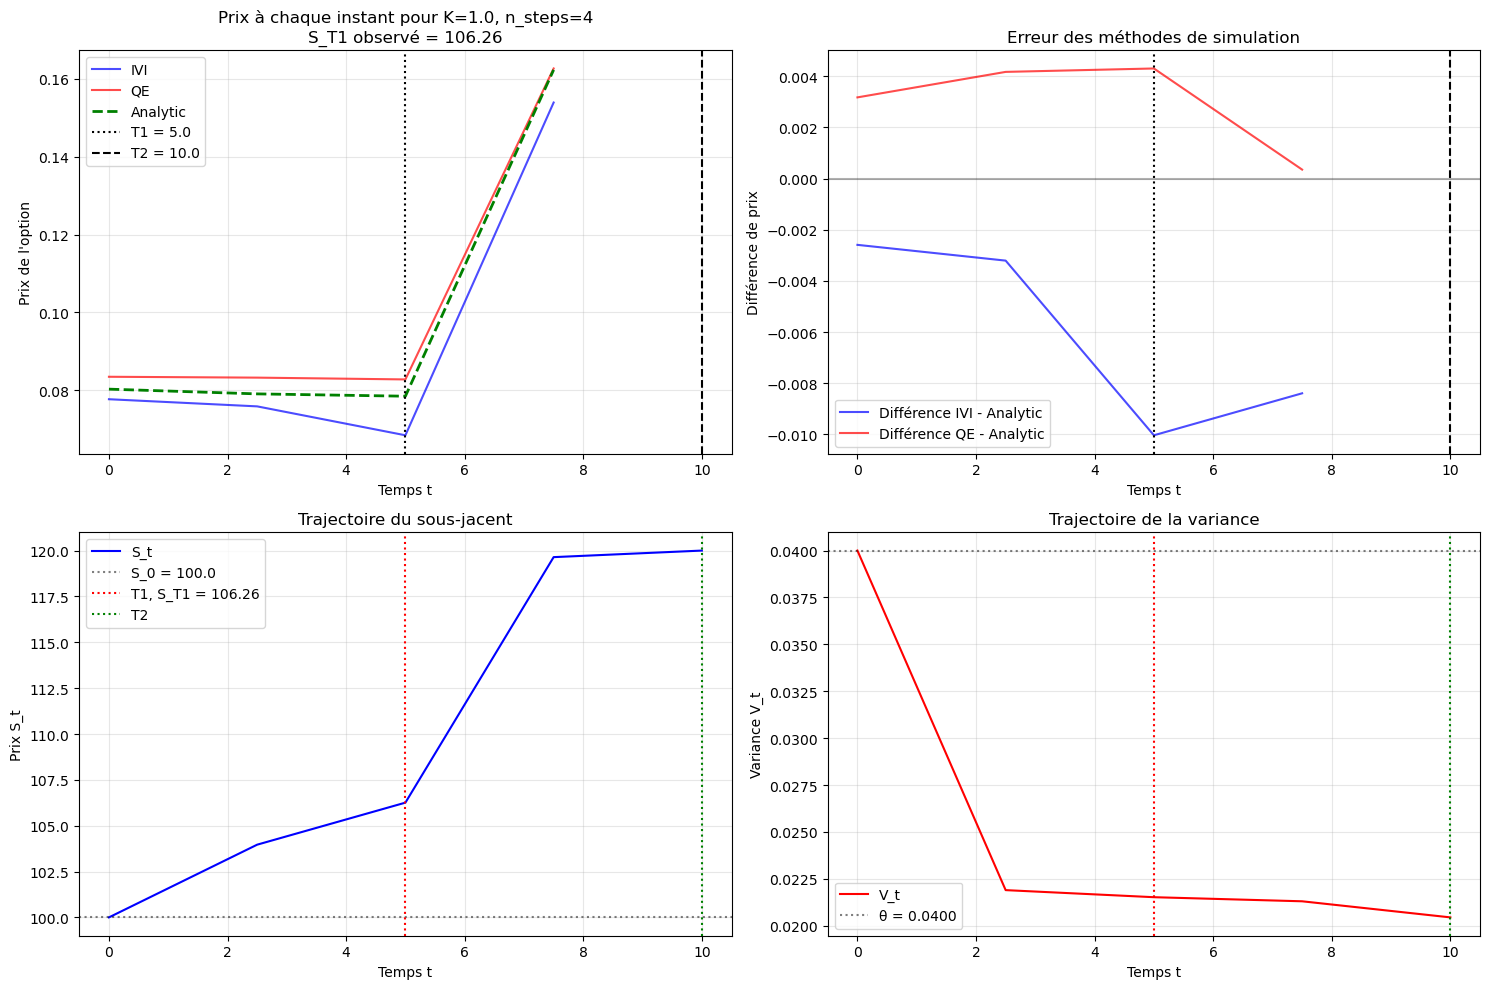


Analyse pour n_steps=4:
  Prix initial (t=0):
    IVI: 0.077718
    QE: 0.083485
    Analytic: 0.080308
  Prix à t=T1: (index 2)
    IVI: 0.068458
    QE: 0.082802
    Analytic: 0.078495
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.007425
    QE: -0.000462
    Analytic: -0.000595
n_steps = 6
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.076245, QE: 0.085373, Analytic: 0.080308
  Calcul du prix à t = 1.667 (index 1)
    IVI: 0.074964, QE: 0.083092, Analytic: 0.079256
  Calcul du prix à t = 3.333 (index 2)
    IVI: 0.074237, QE: 0.084969, Analytic: 0.077751
  Calcul du prix à t = 5.000 (index 3)
    IVI: 0.068624, QE: 0.080668, Analytic: 0.075501
  Calcul du prix à t = 6.667 (index 4)
    IVI: 0.051817, QE: 0.062235, Analytic: 0.059004
  Calcul du prix à t = 8.333 (index 5)
    IVI: 0.055634, QE: 0.064659, Analytic: 0.064204


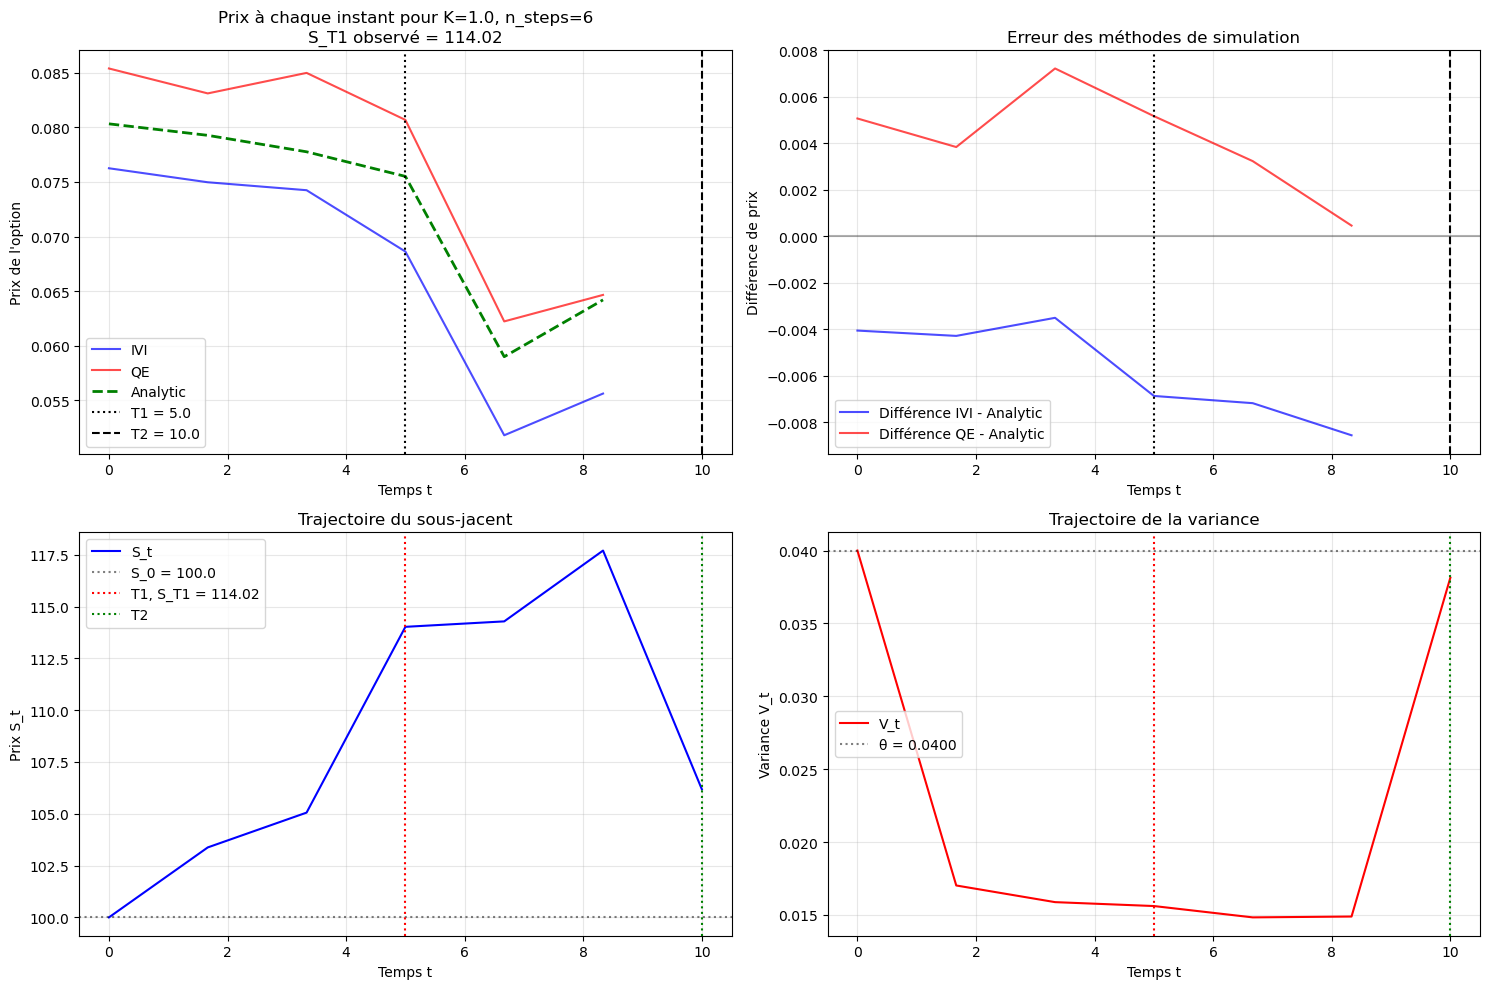


Analyse pour n_steps=6:
  Prix initial (t=0):
    IVI: 0.076245
    QE: 0.085373
    Analytic: 0.080308
  Prix à t=T1: (index 3)
    IVI: 0.068624
    QE: 0.080668
    Analytic: 0.075501
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.005612
    QE: -0.004301
    Analytic: -0.002250
n_steps = 8
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.078660, QE: 0.090798, Analytic: 0.080308
  Calcul du prix à t = 1.250 (index 1)
    IVI: 0.075683, QE: 0.083599, Analytic: 0.079352
  Calcul du prix à t = 2.500 (index 2)
    IVI: 0.076035, QE: 0.082305, Analytic: 0.078374
  Calcul du prix à t = 3.750 (index 3)
    IVI: 0.072009, QE: 0.083142, Analytic: 0.076566
  Calcul du prix à t = 5.000 (index 4)
    IVI: 0.068835, QE: 0.080961, Analytic: 0.073438
  Calcul du prix à t = 6.250 (index 5)
    IVI: 0.073960, QE: 0.085450, Analytic: 0.078502
  Calcul du prix à t = 7.500 (index 6)
    IVI: 0.016070, QE: 0.024808, Analytic: 0.021235
  Calcul du prix à t = 8.750 (index 7)
    IVI: 0.000017, QE: 0.

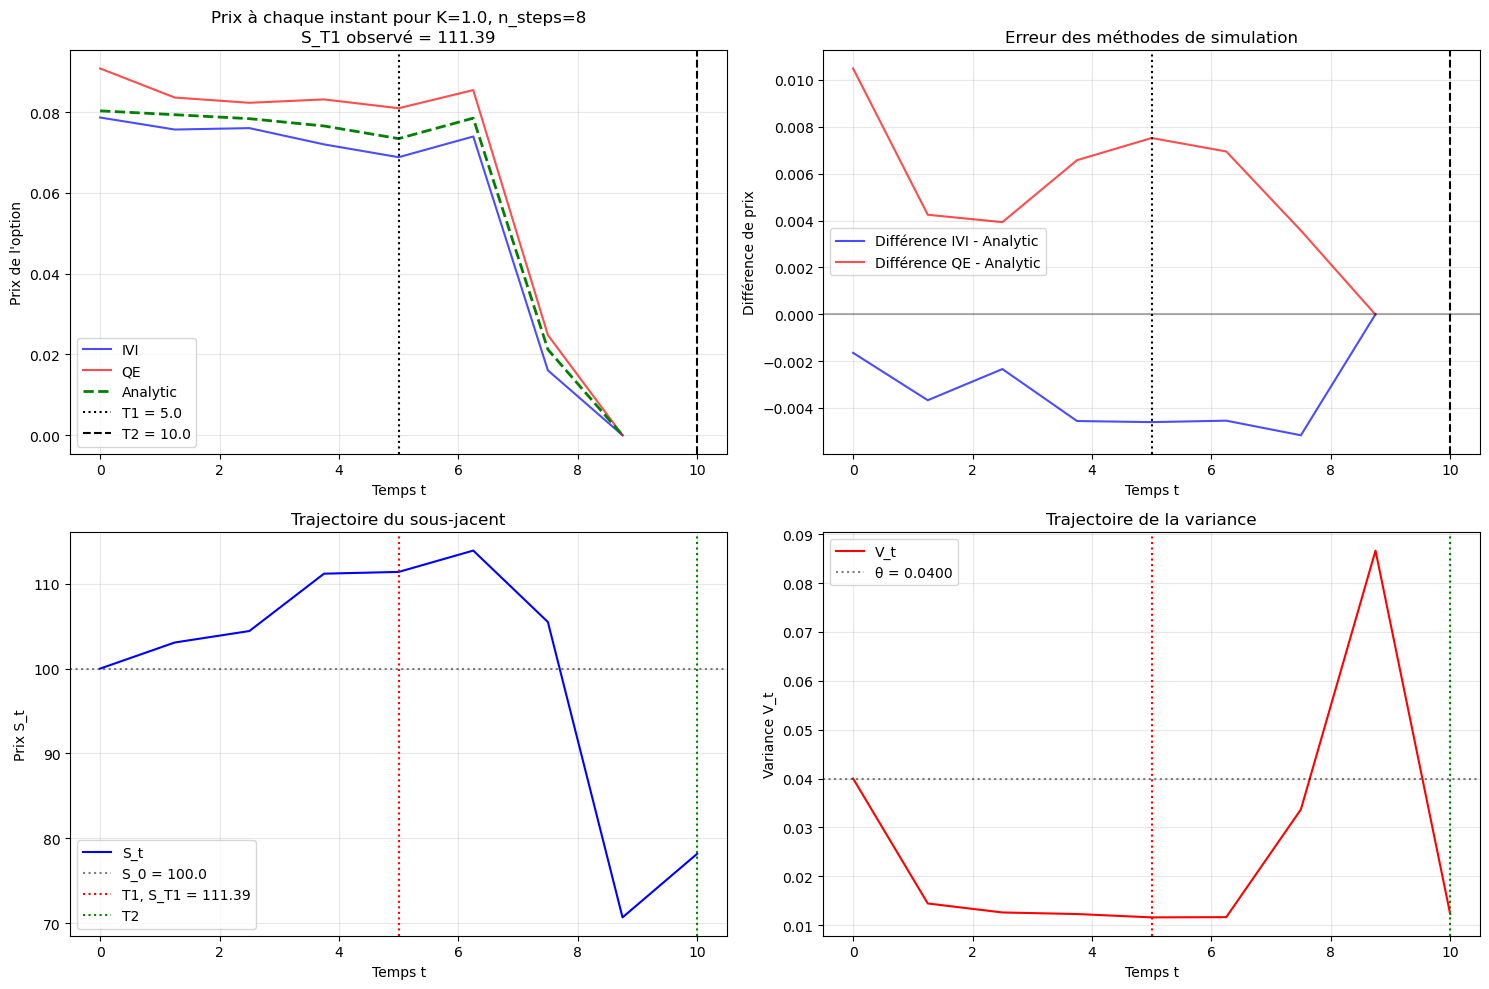


Analyse pour n_steps=8:
  Prix initial (t=0):
    IVI: 0.078660
    QE: 0.090798
    Analytic: 0.080308
  Prix à t=T1: (index 4)
    IVI: 0.068835
    QE: 0.080961
    Analytic: 0.073438
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.003174
    QE: -0.002181
    Analytic: -0.003127
n_steps = 16
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.080736, QE: 0.083412, Analytic: 0.080308
  Calcul du prix à t = 0.625 (index 1)
    IVI: 0.078279, QE: 0.088475, Analytic: 0.079516
  Calcul du prix à t = 1.250 (index 2)
    IVI: 0.079151, QE: 0.081813, Analytic: 0.079072
  Calcul du prix à t = 1.875 (index 3)
    IVI: 0.077811, QE: 0.079168, Analytic: 0.078576
  Calcul du prix à t = 2.500 (index 4)
    IVI: 0.077033, QE: 0.082479, Analytic: 0.077877
  Calcul du prix à t = 3.125 (index 5)
    IVI: 0.076587, QE: 0.081733, Analytic: 0.076926
  Calcul du prix à t = 3.750 (index 6)
    IVI: 0.077573, QE: 0.081745, Analytic: 0.078154
  Calcul du prix à t = 4.375 (index 7)
    IVI: 0.091141, QE: 0

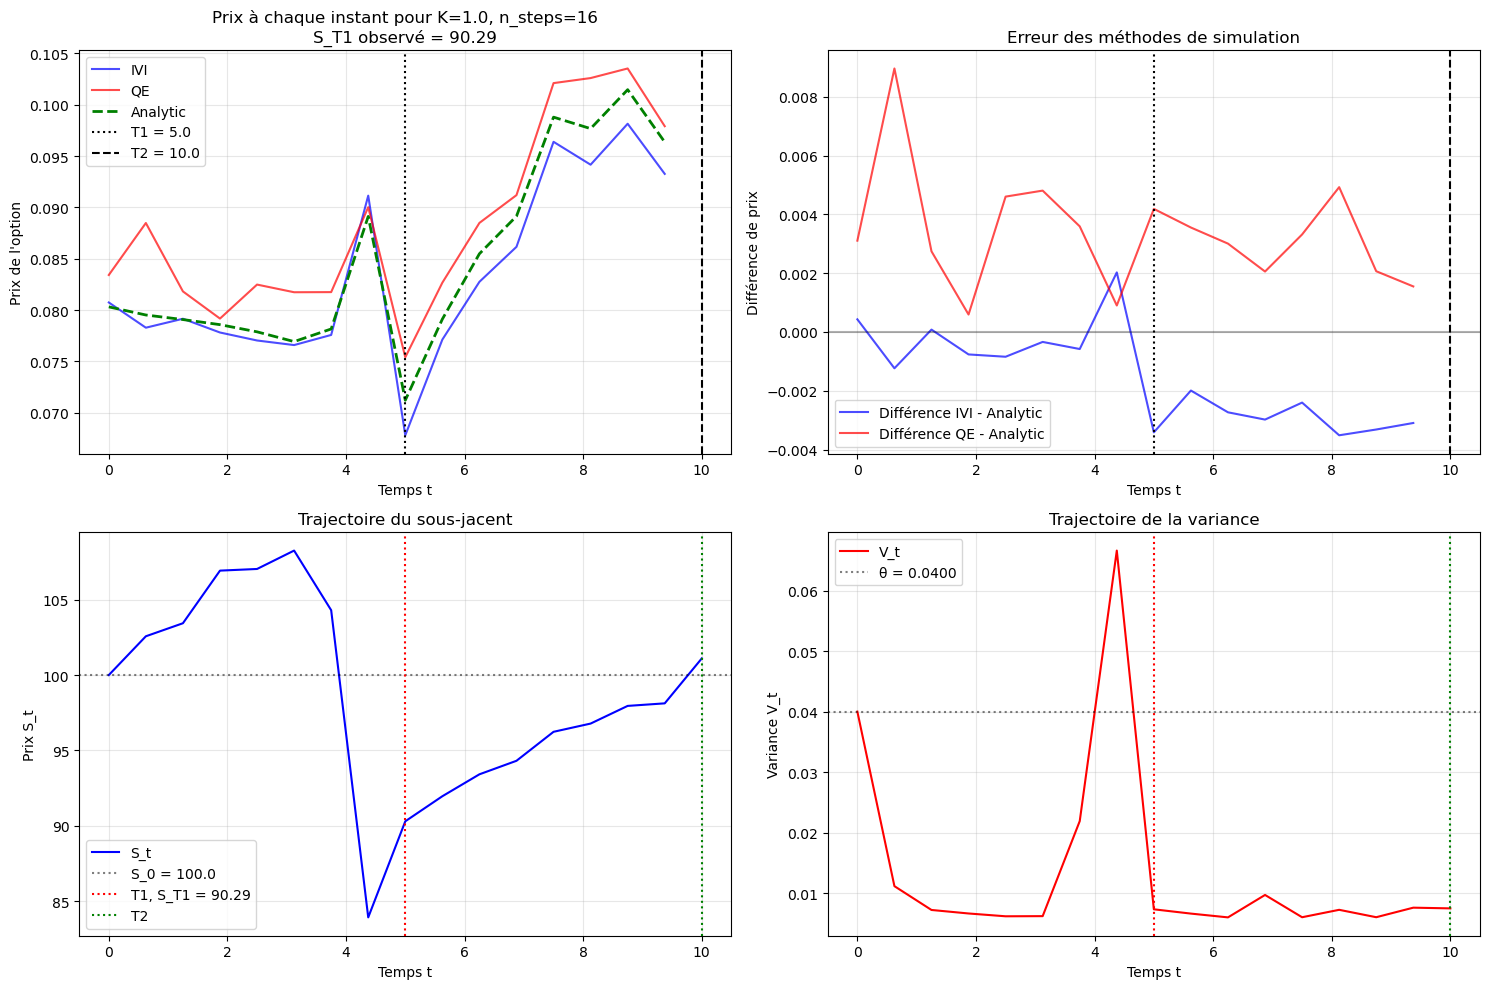


Analyse pour n_steps=16:
  Prix initial (t=0):
    IVI: 0.080736
    QE: 0.083412
    Analytic: 0.080308
  Prix à t=T1: (index 8)
    IVI: 0.067800
    QE: 0.075399
    Analytic: 0.071214
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.023341
    QE: -0.014618
    Analytic: -0.017903
n_steps = 26
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.078999, QE: 0.083177, Analytic: 0.080308
  Calcul du prix à t = 0.385 (index 1)
    IVI: 0.082454, QE: 0.078423, Analytic: 0.079600
  Calcul du prix à t = 0.769 (index 2)
    IVI: 0.078553, QE: 0.079414, Analytic: 0.079278
  Calcul du prix à t = 1.154 (index 3)
    IVI: 0.077786, QE: 0.080366, Analytic: 0.079022
  Calcul du prix à t = 1.538 (index 4)
    IVI: 0.077344, QE: 0.078453, Analytic: 0.078726
  Calcul du prix à t = 1.923 (index 5)
    IVI: 0.080868, QE: 0.077560, Analytic: 0.078380
  Calcul du prix à t = 2.308 (index 6)
    IVI: 0.078372, QE: 0.078921, Analytic: 0.078720
  Calcul du prix à t = 2.692 (index 7)
    IVI: 0.080957, QE: 

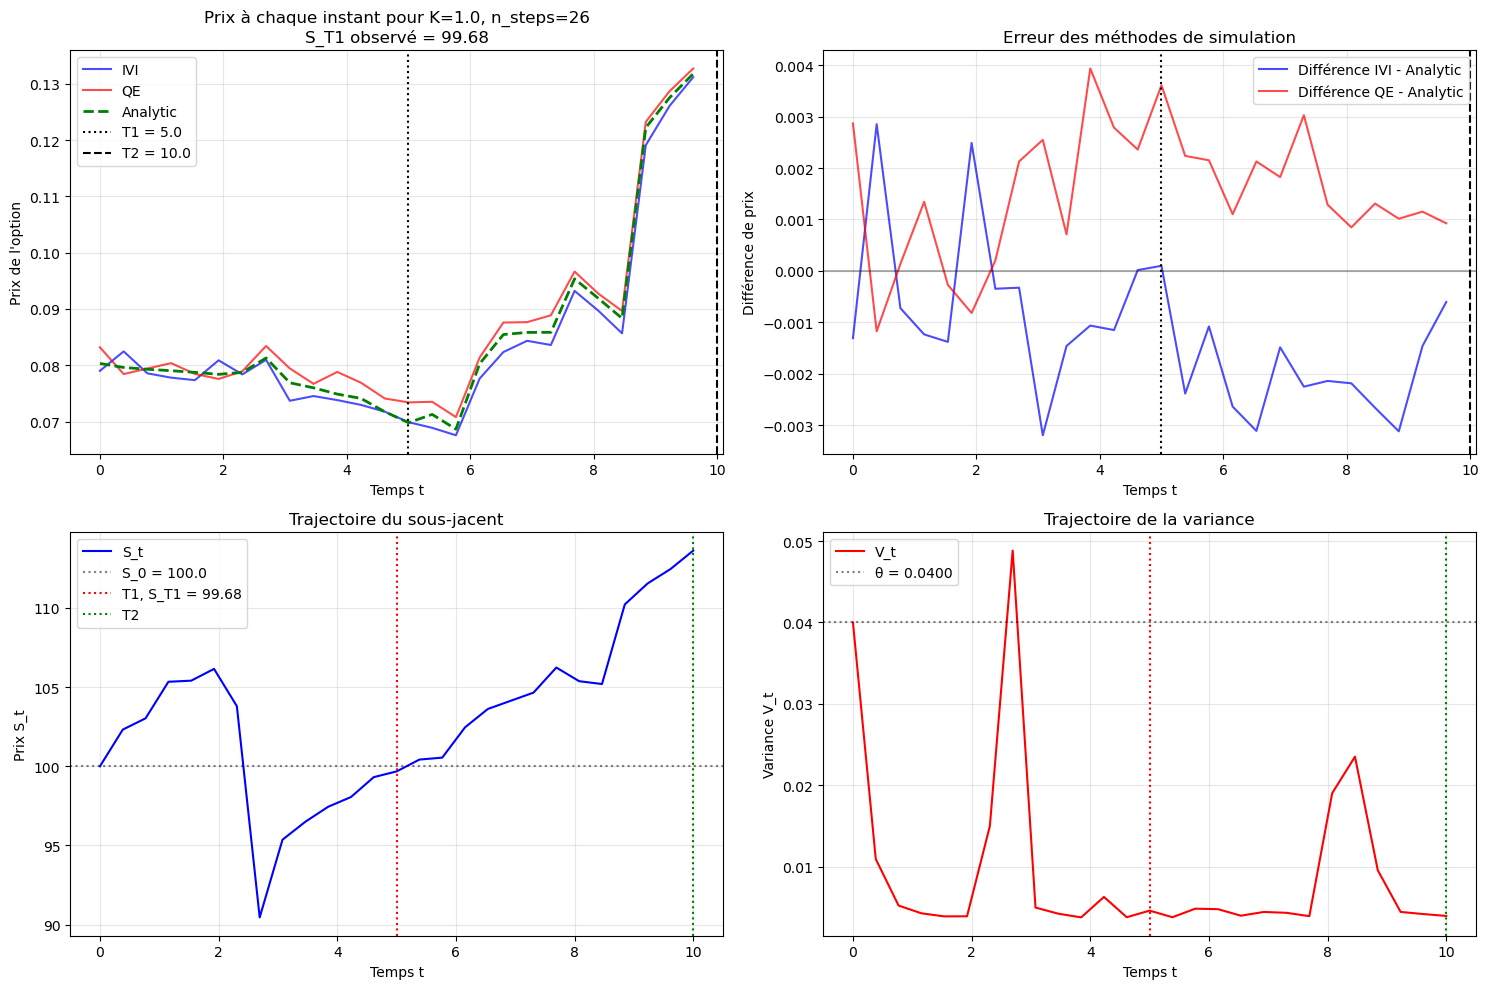


Analyse pour n_steps=26:
  Prix initial (t=0):
    IVI: 0.078999
    QE: 0.083177
    Analytic: 0.080308
  Prix à t=T1: (index 13)
    IVI: 0.069883
    QE: 0.073396
    Analytic: 0.069785
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.001865
    QE: -0.000697
    Analytic: -0.001948
n_steps = 36
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.076690, QE: 0.084547, Analytic: 0.080308
  Calcul du prix à t = 0.278 (index 1)
    IVI: 0.078967, QE: 0.082289, Analytic: 0.079651
  Calcul du prix à t = 0.556 (index 2)
    IVI: 0.079831, QE: 0.080859, Analytic: 0.079366
  Calcul du prix à t = 0.833 (index 3)
    IVI: 0.080507, QE: 0.080428, Analytic: 0.079182
  Calcul du prix à t = 1.111 (index 4)
    IVI: 0.077491, QE: 0.081288, Analytic: 0.078998
  Calcul du prix à t = 1.389 (index 5)
    IVI: 0.079916, QE: 0.078157, Analytic: 0.078799
  Calcul du prix à t = 1.667 (index 6)
    IVI: 0.079279, QE: 0.080922, Analytic: 0.078981
  Calcul du prix à t = 1.944 (index 7)
    IVI: 0.082582, QE:

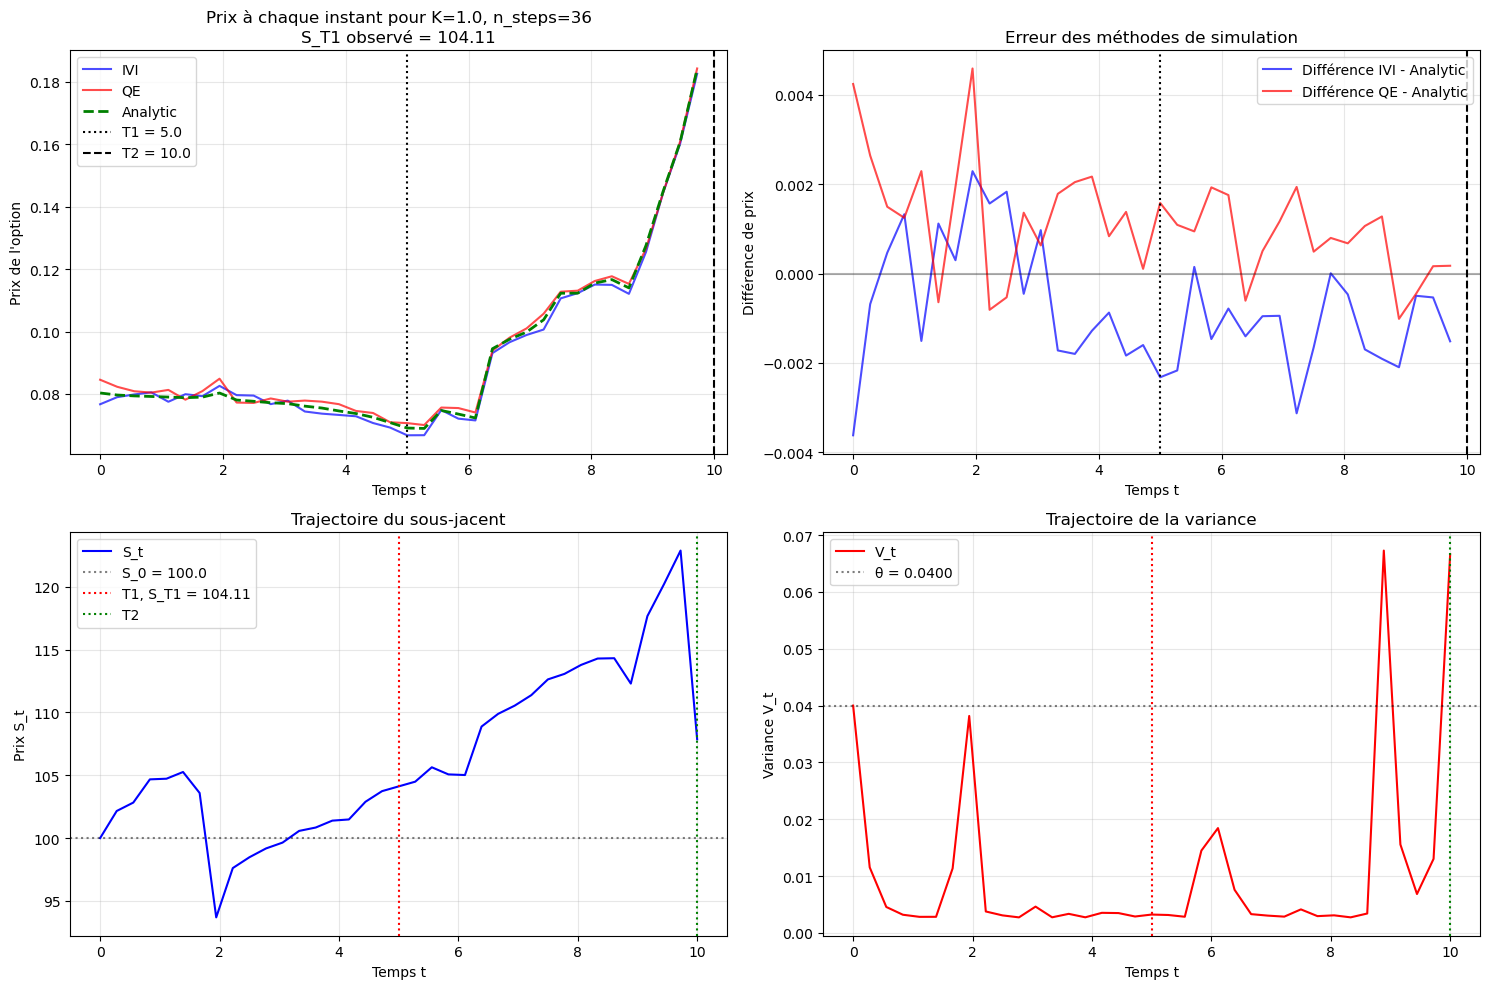


Analyse pour n_steps=36:
  Prix initial (t=0):
    IVI: 0.076690
    QE: 0.084547
    Analytic: 0.080308
  Prix à t=T1: (index 18)
    IVI: 0.066749
    QE: 0.070649
    Analytic: 0.069069
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.002469
    QE: -0.000273
    Analytic: -0.001748
n_steps = 50
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.081563, QE: 0.078660, Analytic: 0.080308
  Calcul du prix à t = 0.200 (index 1)
    IVI: 0.077802, QE: 0.080558, Analytic: 0.079700
  Calcul du prix à t = 0.400 (index 2)
    IVI: 0.079542, QE: 0.082593, Analytic: 0.079434
  Calcul du prix à t = 0.600 (index 3)
    IVI: 0.079189, QE: 0.079192, Analytic: 0.079287
  Calcul du prix à t = 0.800 (index 4)
    IVI: 0.077540, QE: 0.081758, Analytic: 0.079166
  Calcul du prix à t = 1.000 (index 5)
    IVI: 0.082357, QE: 0.079160, Analytic: 0.079044
  Calcul du prix à t = 1.200 (index 6)
    IVI: 0.077997, QE: 0.077990, Analytic: 0.079151
  Calcul du prix à t = 1.400 (index 7)
    IVI: 0.078680, QE:

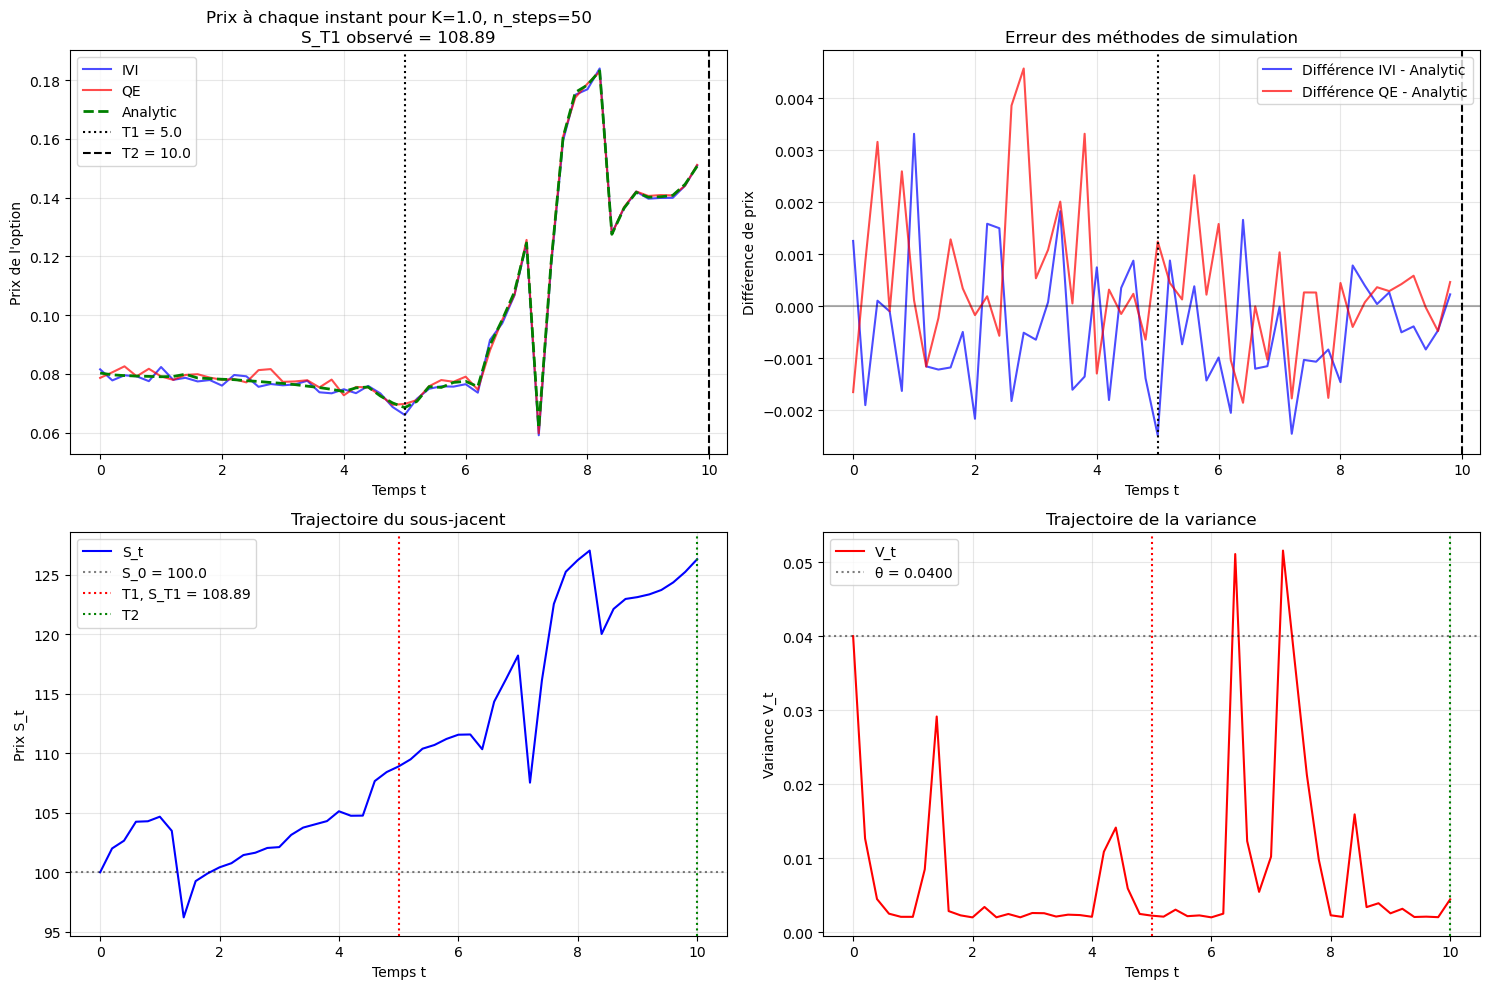


Analyse pour n_steps=50:
  Prix initial (t=0):
    IVI: 0.081563
    QE: 0.078660
    Analytic: 0.080308
  Prix à t=T1: (index 25)
    IVI: 0.066053
    QE: 0.069776
    Analytic: 0.068530
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.002711
    QE: 0.000270
    Analytic: -0.001616
n_steps = 66
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.081682, QE: 0.079776, Analytic: 0.080308
  Calcul du prix à t = 0.152 (index 1)
    IVI: 0.078969, QE: 0.085277, Analytic: 0.079742
  Calcul du prix à t = 0.303 (index 2)
    IVI: 0.081791, QE: 0.079713, Analytic: 0.079483
  Calcul du prix à t = 0.455 (index 3)
    IVI: 0.076436, QE: 0.081391, Analytic: 0.079350
  Calcul du prix à t = 0.606 (index 4)
    IVI: 0.079395, QE: 0.078071, Analytic: 0.079259
  Calcul du prix à t = 0.758 (index 5)
    IVI: 0.079301, QE: 0.081933, Analytic: 0.079175
  Calcul du prix à t = 0.909 (index 6)
    IVI: 0.076542, QE: 0.077124, Analytic: 0.079247
  Calcul du prix à t = 1.061 (index 7)
    IVI: 0.082472, QE: 

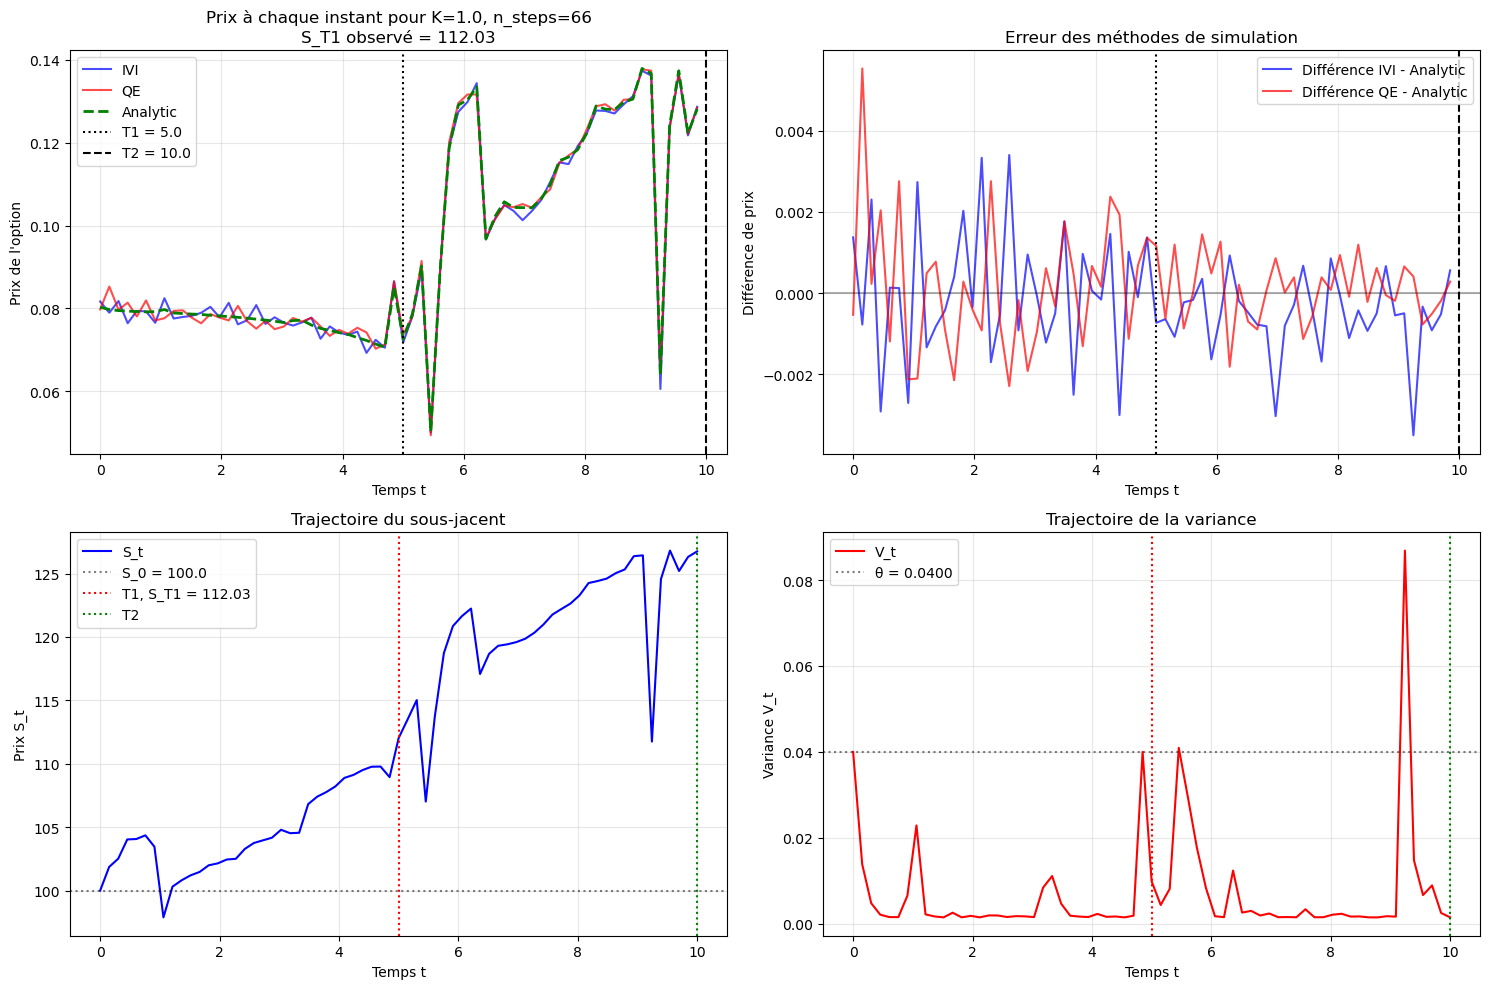


Analyse pour n_steps=66:
  Prix initial (t=0):
    IVI: 0.081682
    QE: 0.079776
    Analytic: 0.080308
  Prix à t=T1: (index 33)
    IVI: 0.071824
    QE: 0.073717
    Analytic: 0.072554
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.014723
    QE: -0.012822
    Analytic: -0.012621
n_steps = 80
  Calcul du prix à t = 0.000 (index 0)
    IVI: 0.082685, QE: 0.078331, Analytic: 0.080308
  Calcul du prix à t = 0.125 (index 1)
    IVI: 0.077891, QE: 0.077802, Analytic: 0.079770
  Calcul du prix à t = 0.250 (index 2)
    IVI: 0.076298, QE: 0.079438, Analytic: 0.079516
  Calcul du prix à t = 0.375 (index 3)
    IVI: 0.078743, QE: 0.078414, Analytic: 0.079385
  Calcul du prix à t = 0.500 (index 4)
    IVI: 0.078406, QE: 0.079170, Analytic: 0.079307
  Calcul du prix à t = 0.625 (index 5)
    IVI: 0.079513, QE: 0.078237, Analytic: 0.079241
  Calcul du prix à t = 0.750 (index 6)
    IVI: 0.079820, QE: 0.079061, Analytic: 0.079296
  Calcul du prix à t = 0.875 (index 7)
    IVI: 0.078777, QE:

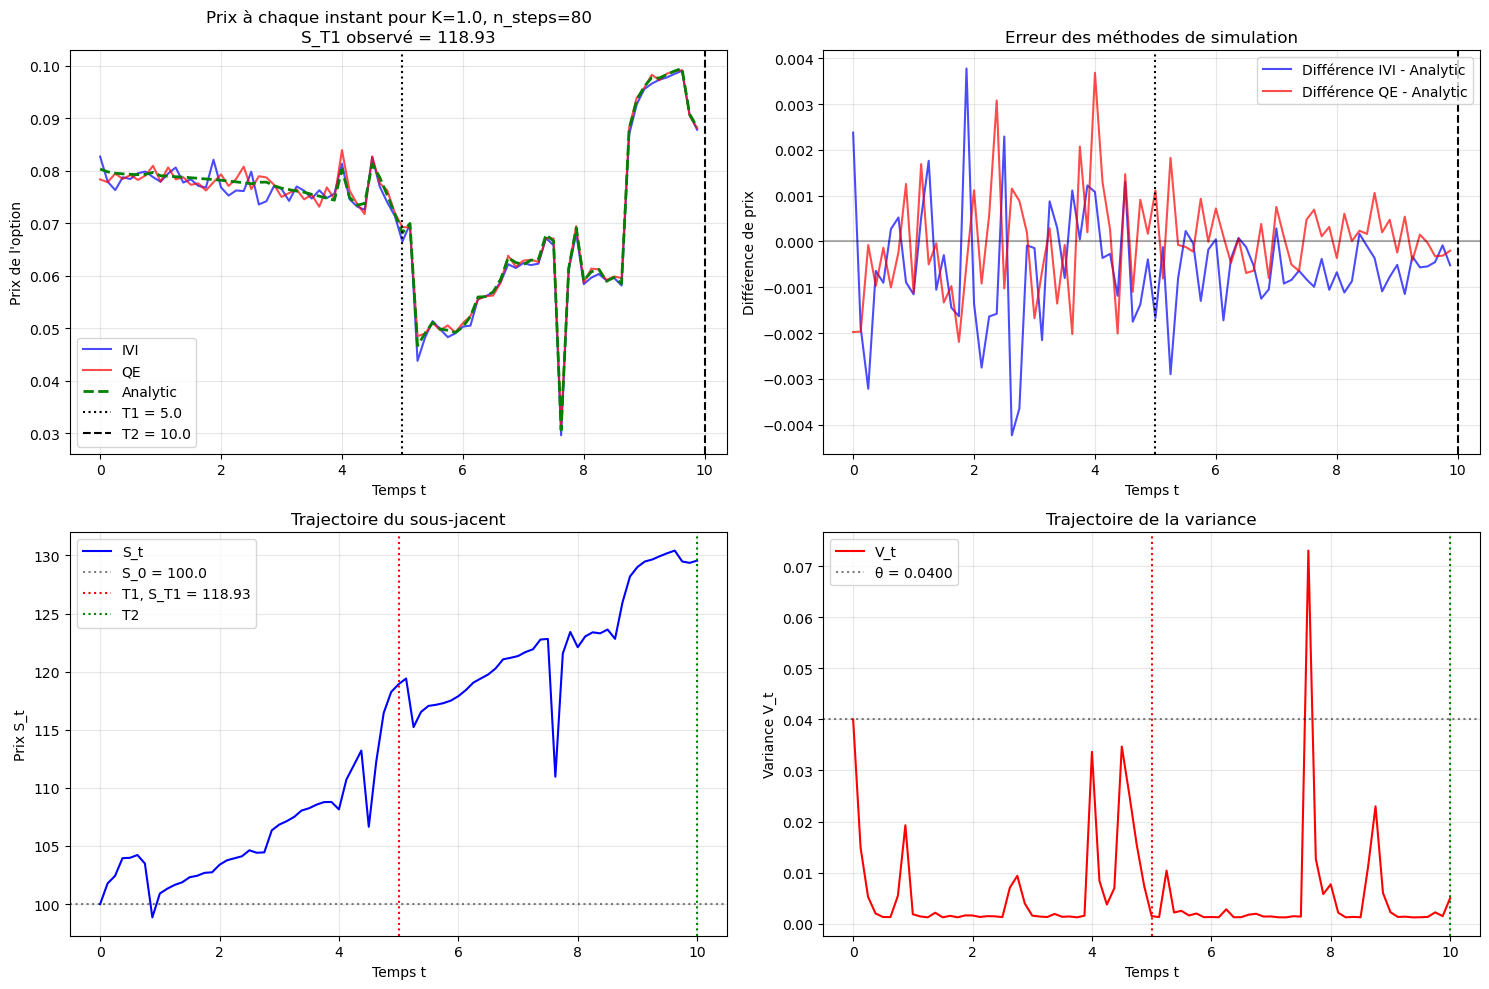


Analyse pour n_steps=80:
  Prix initial (t=0):
    IVI: 0.082685
    QE: 0.078331
    Analytic: 0.080308
  Prix à t=T1: (index 40)
    IVI: 0.066475
    QE: 0.069262
    Analytic: 0.068146
  Saut à T1 (prix(T1) - prix(T1-dt)):
    IVI: -0.004895
    QE: -0.002666
    Analytic: -0.003614


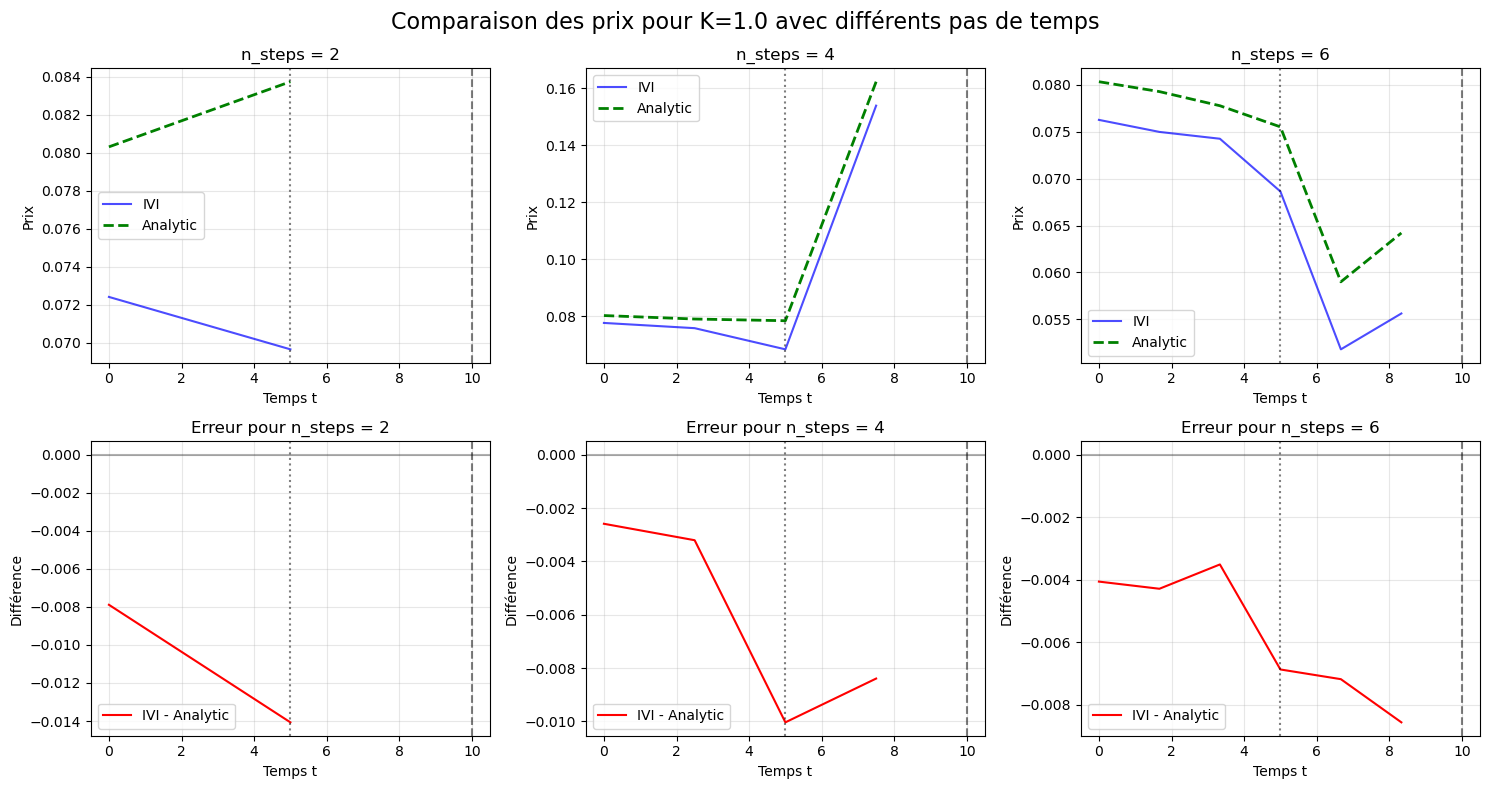


RÉCAPITULATIF DES RÉSULTATS

Paramètres du modèle:
  S_0 = 100.0
  V_0 = 0.04
  K = 1.0
  T1 = 5.0, T2 = 10.0
  kappa = 0.5000, theta = 0.0400, sigma = 1.0000, rho = -0.9000

Comparaison des méthodes (prix initial à t=0):
 n_steps          IVI           QE     Analytic     Diff IVI      Diff QE
       2     0.072418     0.084283     0.080308    -0.007890     0.003975
       4     0.077718     0.083485     0.080308    -0.002590     0.003177
       6     0.076245     0.085373     0.080308    -0.004063     0.005066
       8     0.078660     0.090798     0.080308    -0.001647     0.010490
      16     0.080736     0.083412     0.080308     0.000428     0.003104
      26     0.078999     0.083177     0.080308    -0.001309     0.002869
      36     0.076690     0.084547     0.080308    -0.003618     0.004239
      50     0.081563     0.078660     0.080308     0.001256    -0.001648
      66     0.081682     0.079776     0.080308     0.001374    -0.000532
      80     0.082685     0.078331   

In [ ]:
# FIXER K
S_0 = 100. 
a, b, c, rho, V_0, T2 = case[2]
kappa, theta, sigma = -b, a/(-b), c 
T1 = T2 / 2
K = 1.0  # Strike fixé
r = 0

# Liste pour stocker les résultats par n_steps
results_by_nsteps = {}

for n_steps in N_steps:
    print(f"n_steps = {n_steps}")
    
    # Indices temporels
    T1_idx = int(n_steps/2)
    T2_idx = n_steps
    
    # On génère UNE trajectoire de référence
    t_vec, V_paths, U_paths, Z_paths, S_paths = simulate_paths(
        a, b, c, rho, V_0, T2, n_steps, n_paths=1, S_0=S_0
    )
    
    # Valeur de S_T1 observée sur cette trajectoire
    S_T1 = S_paths[T1_idx, 0]
    
    # Initialisation des listes pour chaque instant
    times = []
    ivi_prices_at_t = []
    QE_prices_at_t = []
    analytic_prices_at_t = []
    
    # On calcule le prix à CHAQUE instant (sauf le dernier)
    for i in range(len(t_vec)):
        t_i = t_vec[i]
        
        # On ne peut pas calculer le prix à T2 (payoff connu)
        if i == T2_idx:
            continue
            
        print(f"  Calcul du prix à t = {t_i:.3f} (index {i})")
        
        # Valeurs à l'instant t_i
        S_ti = S_paths[i, 0]
        V_ti = V_paths[i, 0]
        
        
        if i <= T1_idx:
            # AVANT T1: S_T1 est encore inconnu
            # Pour les simulations, on doit simuler jusqu'à T1 ET jusqu'à T2
            
            # 1. SIMULATION IVI
            _, _, _, _, S_curr = simulate_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,  # Réduit pour performance
                S_idx=S_ti,
                U_idx=U_paths[i, 0], 
                Z_idx=Z_paths[i, 0]
            )
            
            # À t < T1, on doit extraire S_T1 et S_T2
            relative_T1_idx = T1_idx - i
            S_T1_sim = S_curr[relative_T1_idx, :]  # S_T1 simulé
            S_T2_sim = S_curr[-1, :]  # S_T2
            
            payoff_ivi = np.maximum(S_T2_sim / S_T1_sim - K, 0)
            price_ivi = np.mean(payoff_ivi)
            
            # 2. SIMULATION QE
            S_curr_qe, _, _ = simulate_QE_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0]
            )
            
            S_T1_sim_qe = S_curr_qe[relative_T1_idx, :]
            S_T2_sim_qe = S_curr_qe[-1, :]
            
            payoff_qe = np.maximum(S_T2_sim_qe / S_T1_sim_qe - K, 0)
            price_qe = np.mean(payoff_qe)
            
            # 3. FORMULE ANALYTIQUE (t < T1)
            # Pour t < T1, on utilise char_func_t_t1 qui nécessite v0
            price_analytic = conditional_expectation(
                t=t_i, 
                T1=T1, 
                T2=T2, 
                K=K, 
                v_t=V_ti, 
                s_t=S_ti,
                s_T1=S_T1,  # Cette valeur ne sera pas utilisée pour t < T1 dans char_func_t_t1
                kappa=kappa, 
                theta=theta, 
                sigma=sigma, 
                rho=rho, 
                r=r,
                v0=V_0  # Nécessaire pour t < T1
            )
            
        else:
            # APRÈS T1: S_T1 est connu
            # 1. SIMULATION IVI
            _, _, _, _, S_curr = simulate_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0], 
                Z_idx=Z_paths[i, 0]
            )
            
            # À t >= T1, S_T1 est fixé (celui de la trajectoire de référence)
            S_T1_fixed = S_T1 * np.ones(5000)
            S_T2_sim = S_curr[-1, :]
            
            payoff_ivi = np.maximum(S_T2_sim / S_T1_fixed - K, 0)
            price_ivi = np.mean(payoff_ivi)
            
            # 2. SIMULATION QE
            S_curr_qe, _, _ = simulate_QE_paths_from_idx(
                a=a, b=b, c=c, rho=rho, 
                V_idx=V_ti, 
                idx=i, 
                T=T2, 
                n_steps=n_steps, 
                n_paths=5000,
                S_idx=S_ti,
                U_idx=U_paths[i, 0]
            )
            
            S_T1_fixed_qe = S_T1 * np.ones(5000)
            S_T2_sim_qe = S_curr_qe[-1, :]
            
            payoff_qe = np.maximum(S_T2_sim_qe / S_T1_fixed_qe - K, 0)
            price_qe = np.mean(payoff_qe)
            
            # 3. FORMULE ANALYTIQUE (t >= T1)
            price_analytic = conditional_expectation(
                t=t_i, 
                T1=T1, 
                T2=T2, 
                K=K, 
                v_t=V_ti, 
                s_t=S_ti,
                s_T1=S_T1,  # S_T1 connu
                kappa=kappa, 
                theta=theta, 
                sigma=sigma, 
                rho=rho, 
                r=r
                # v0 pas nécessaire pour t >= T1
            )
        
        # Stocker les résultats
        times.append(t_i)
        ivi_prices_at_t.append(price_ivi)
        QE_prices_at_t.append(price_qe)
        analytic_prices_at_t.append(price_analytic)
        
        print(f"    IVI: {price_ivi:.6f}, QE: {price_qe:.6f}, Analytic: {price_analytic:.6f}")
    
    # Stocker les résultats pour ce n_steps
    results_by_nsteps[n_steps] = {
        'times': times,
        'ivi_prices': ivi_prices_at_t,
        'qe_prices': QE_prices_at_t,
        'analytic_prices': analytic_prices_at_t,
        'S_path': S_paths[:, 0],
        'V_path': V_paths[:, 0],
        't_vec': t_vec,
        'S_T1': S_T1
    }
    
    # ============================================
    # VISUALISATION POUR CE n_steps
    # ============================================
    plt.figure(figsize=(15, 10))
    
    # Sous-figure 1: Prix à chaque instant
    plt.subplot(2, 2, 1)
    plt.plot(times, ivi_prices_at_t, 'b-', label='IVI', alpha=0.7)
    plt.plot(times, QE_prices_at_t, 'r-', label='QE', alpha=0.7)
    plt.plot(times, analytic_prices_at_t, 'g--', label='Analytic', linewidth=2)
    
    # Marquer T1 et T2
    plt.axvline(x=T1, color='k', linestyle=':', label=f'T1 = {T1}')
    plt.axvline(x=T2, color='k', linestyle='--', label=f'T2 = {T2}')
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix de l\'option')
    plt.title(f'Prix à chaque instant pour K={K}, n_steps={n_steps}\nS_T1 observé = {S_T1:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 2: Différences par rapport à la formule analytique
    plt.subplot(2, 2, 2)
    diff_ivi = np.array(ivi_prices_at_t) - np.array(analytic_prices_at_t)
    diff_qe = np.array(QE_prices_at_t) - np.array(analytic_prices_at_t)
    
    plt.plot(times, diff_ivi, 'b-', label='Différence IVI - Analytic', alpha=0.7)
    plt.plot(times, diff_qe, 'r-', label='Différence QE - Analytic', alpha=0.7)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=T1, color='k', linestyle=':')
    plt.axvline(x=T2, color='k', linestyle='--')
    
    plt.xlabel('Temps t')
    plt.ylabel('Différence de prix')
    plt.title('Erreur des méthodes de simulation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 3: Trajectoire du sous-jacent
    plt.subplot(2, 2, 3)
    plt.plot(t_vec, S_paths[:, 0], 'b-', label='S_t')
    plt.axhline(y=S_0, color='k', linestyle=':', alpha=0.5, label=f'S_0 = {S_0}')
    plt.axvline(x=T1, color='r', linestyle=':', label=f'T1, S_T1 = {S_T1:.2f}')
    plt.axvline(x=T2, color='g', linestyle=':', label=f'T2')
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix S_t')
    plt.title('Trajectoire du sous-jacent')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Sous-figure 4: Trajectoire de la variance
    plt.subplot(2, 2, 4)
    plt.plot(t_vec, V_paths[:, 0], 'r-', label='V_t')
    plt.axhline(y=theta, color='k', linestyle=':', alpha=0.5, label=f'θ = {theta:.4f}')
    plt.axvline(x=T1, color='r', linestyle=':')
    plt.axvline(x=T2, color='g', linestyle=':')
    
    plt.xlabel('Temps t')
    plt.ylabel('Variance V_t')
    plt.title('Trajectoire de la variance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ============================================
    # ANALYSE DES RÉSULTATS
    # ============================================
    print(f"\nAnalyse pour n_steps={n_steps}:")
    print(f"  Prix initial (t=0):")
    print(f"    IVI: {ivi_prices_at_t[0]:.6f}")
    print(f"    QE: {QE_prices_at_t[0]:.6f}")
    print(f"    Analytic: {analytic_prices_at_t[0]:.6f}")
    
    print(f"  Prix à t=T1: (index {T1_idx})")
    print(f"    IVI: {ivi_prices_at_t[T1_idx]:.6f}")
    print(f"    QE: {QE_prices_at_t[T1_idx]:.6f}")
    print(f"    Analytic: {analytic_prices_at_t[T1_idx]:.6f}")
    
    # Vérifier la continuité à T1
    if T1_idx > 0 and T1_idx < len(times)-1:
        jump_ivi = ivi_prices_at_t[T1_idx] - ivi_prices_at_t[T1_idx-1]
        jump_qe = QE_prices_at_t[T1_idx] - QE_prices_at_t[T1_idx-1]
        jump_analytic = analytic_prices_at_t[T1_idx] - analytic_prices_at_t[T1_idx-1]
        
        print(f"  Saut à T1 (prix(T1) - prix(T1-dt)):")
        print(f"    IVI: {jump_ivi:.6f}")
        print(f"    QE: {jump_qe:.6f}")
        print(f"    Analytic: {jump_analytic:.6f}")

# ============================================
# VISUALISATION COMPARATIVE POUR DIFFÉRENTS n_steps
# ============================================
plt.figure(figsize=(15, 8))

for idx, n_steps in enumerate(list(results_by_nsteps.keys())[:3]):  # Limiter à 3 n_steps pour lisibilité
    results = results_by_nsteps[n_steps]
    
    plt.subplot(2, 3, idx+1)
    plt.plot(results['times'], results['ivi_prices'], 'b-', label='IVI', alpha=0.7)
    plt.plot(results['times'], results['analytic_prices'], 'g--', label='Analytic', linewidth=2)
    plt.axvline(x=T1, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=T2, color='k', linestyle='--', alpha=0.5)
    
    plt.xlabel('Temps t')
    plt.ylabel('Prix')
    plt.title(f'n_steps = {n_steps}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, idx+4)
    diff = np.array(results['ivi_prices']) - np.array(results['analytic_prices'])
    plt.plot(results['times'], diff, 'r-', label='IVI - Analytic')
    plt.axvline(x=T1, color='k', linestyle=':', alpha=0.5)
    plt.axvline(x=T2, color='k', linestyle='--', alpha=0.5)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    plt.xlabel('Temps t')
    plt.ylabel('Différence')
    plt.title(f'Erreur pour n_steps = {n_steps}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle(f'Comparaison des prix pour K={K} avec différents pas de temps', fontsize=16)
plt.tight_layout()
plt.show()

# ============================================
# TABLEAU RÉCAPITULATIF
# ============================================
print("\n" + "="*80)
print("RÉCAPITULATIF DES RÉSULTATS")
print("="*80)

print(f"\nParamètres du modèle:")
print(f"  S_0 = {S_0}")
print(f"  V_0 = {V_0}")
print(f"  K = {K}")
print(f"  T1 = {T1}, T2 = {T2}")
print(f"  kappa = {kappa:.4f}, theta = {theta:.4f}, sigma = {sigma:.4f}, rho = {rho:.4f}")

print(f"\nComparaison des méthodes (prix initial à t=0):")
print(f"{'n_steps':>8} {'IVI':>12} {'QE':>12} {'Analytic':>12} {'Diff IVI':>12} {'Diff QE':>12}")

for n_steps in results_by_nsteps:
    results = results_by_nsteps[n_steps]
    price_ivi_0 = results['ivi_prices'][0]
    price_qe_0 = results['qe_prices'][0]
    price_analytic_0 = results['analytic_prices'][0]
    
    diff_ivi = price_ivi_0 - price_analytic_0
    diff_qe = price_qe_0 - price_analytic_0
    
    print(f"{n_steps:>8} {price_ivi_0:>12.6f} {price_qe_0:>12.6f} {price_analytic_0:>12.6f} {diff_ivi:>12.6f} {diff_qe:>12.6f}")